<h3> Environment , Polices , Training  </h3>

In [1]:
import numpy as np
import random
from itertools import combinations

GRID_SIZE = 5
PICKUP_LOCATIONS = {(0, 4): 5, (1, 3): 5, (4, 1): 5}  # Pickup locations with their capacities
DROPOFF_LOCATIONS = {(0, 0): 0, (2, 0): 0, (3, 4): 0}  # Dropoff locations with their remaining capacities
ACTIONS = ['N', 'E', 'S', 'W', 'P', 'D']  # Actions: North, East, South, West, Pickup, Dropoff
ACTION_REWARDS = {'P': 13, 'D': 13, 'N': -1, 'E': -1, 'S': -1, 'W': -1}  # Reward values for actions
random.seed(4)
np.random.seed(4)

# Hyperparameters
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.95
EPSILON = 0.99
EPISODES = 1000

# Initial positions for each agent
initial_positions = {'red': (2, 2), 'blue': (4, 2), 'black': (0, 2)}  # Adjusted to 0-based indexing

# Agent class definition
class Agent:
    def __init__(self, start_position, name):
        self.position = start_position
        self.name = name
        self.carrying = False
        self.q_table = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTIONS)))

    def get_valid_actions(self):
        x, y = self.position
        valid_actions = ACTIONS.copy()

        # Check if agent is at a border
        if x == 0: valid_actions.remove('N')
        if x == GRID_SIZE - 1: valid_actions.remove('S')
        if y == 0: valid_actions.remove('W')
        if y == GRID_SIZE - 1: valid_actions.remove('E')

        # Check for pickup/dropoff actions
        if (x, y) in PICKUP_LOCATIONS and (PICKUP_LOCATIONS[(x, y)] <= 0 or self.carrying):
            valid_actions.remove('P')
        if (x, y) in DROPOFF_LOCATIONS and (DROPOFF_LOCATIONS[(x, y)] >= 5 or not self.carrying):
            valid_actions.remove('D')
        return valid_actions

    
    def select_action(self, valid_actions, policy='PRandom'):        
        if not valid_actions:
            return None  # No valid actions available
        if policy == 'PRandom' or (policy == 'PExploit' and random.random() < EPSILON):
            return random.choice(valid_actions)
        else:
            q_values = [self.q_table[x, y, ACTIONS.index(a)] for a in valid_actions]
            max_q_value = max(q_values)
            max_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q_value]
            return random.choice(max_actions)

    def perform_action(self, action):  
        x, y = self.position

        # Update position based on action
        if action == 'N': x = max(0, x - 1)
        elif action == 'S': x = min(GRID_SIZE - 1, x + 1)
        elif action == 'E': y = min(GRID_SIZE - 1, y + 1)
        elif action == 'W': y = max(0, y - 1)

        # Handle pickup and dropoff actions
        if action == 'P' and (x, y) in PICKUP_LOCATIONS and PICKUP_LOCATIONS[(x, y)] > 0:
            self.carrying = True
            PICKUP_LOCATIONS[(x, y)] -= 1
        elif action == 'D' and (x, y) in DROPOFF_LOCATIONS and DROPOFF_LOCATIONS[(x, y)] < 5:
            self.carrying = False
            DROPOFF_LOCATIONS[(x, y)] += 1

        self.position = (x, y)
        return self.position

    def update_q_table(self, action, reward, next_state, next_valid_actions):
        if action is None:
            return  # Skip Q-table update if no action was taken
        old_x, old_y = self.position
        new_x, new_y = next_state
        action_index = ACTIONS.index(action)
        future_rewards = [self.q_table[new_x, new_y, ACTIONS.index(a)] for a in next_valid_actions]
        self.q_table[old_x, old_y, action_index] = (1 - LEARNING_RATE) * self.q_table[old_x, old_y, action_index] + \
            LEARNING_RATE * (reward + DISCOUNT_FACTOR * np.max(future_rewards))

    def is_terminal_state(self):
        return all(blocks == 5 for blocks in DROPOFF_LOCATIONS.values())

    def reset(self):
        initial_positions = {'red': (2, 2), 'blue': (4, 2), 'black': (0, 2)}
        self.position = initial_positions[self.name]
        self.carrying = False
        for loc in PICKUP_LOCATIONS:
            PICKUP_LOCATIONS[loc] = 5
        for loc in DROPOFF_LOCATIONS:
            DROPOFF_LOCATIONS[loc] = 0

# Utility functions
def manhattan_distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

def average_manhattan_distance(agents):
    distances = [manhattan_distance(agent1.position, agent2.position) 
                 for agent1, agent2 in combinations(agents, 2)]
    return np.mean(distances)

def get_shortest_path_length(start, end):
    return abs(start[0] - end[0]) + abs(start[1] - end[1])

def simulate_agent_path(agent, start, end):
    agent.reset()
    agent.position = start
    path = [start]
    while agent.position != end:
        valid_actions = agent.get_valid_actions()
        action = agent.select_action(valid_actions)
        agent.perform_action(action)
        path.append(agent.position)
    return path

# Simulation
agents = [Agent(initial_positions['red'], 'red'), 
          Agent(initial_positions['blue'], 'blue'), 
          Agent(initial_positions['black'], 'black')]

average_distances = []

for episode in range(EPISODES):
    episode_distances = []
    for agent in agents:
        valid_actions = agent.get_valid_actions()
        action = agent.select_action(valid_actions, policy='PRandom')  
        if action:
            new_position = agent.perform_action(action)
            reward = ACTION_REWARDS.get(action, 0)
            next_valid_actions = agent.get_valid_actions()
            agent.update_q_table(action, reward, new_position, next_valid_actions)
        episode_distances.append(average_manhattan_distance(agents))
    average_distances.append(np.mean(episode_distances))
    if agent.is_terminal_state():
        for a in agents:
            a.reset()
        break

# Output analysis
print(f"Average Manhattan distances over episodes:")
for i, avg_dist in enumerate(average_distances, 1):
    print(f"Episode {i}: {avg_dist:.2f}")

# Output Q-tables for analysis
for agent in agents:
    print(f"{agent.name}'s Q-table:")
    print("State  |   S       W       N       E       P       D")
    print("---------------------------------------------------")
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            q_values = agent.q_table[x, y]
            print(f"({x+1},{y+1})  |  " + "  ".join(f"{q_value:6.2f}" for q_value in q_values))
    print("\n")

# Simulate a path from a pickup to a dropoff location
agent = Agent(initial_positions['red'], 'red')  # You can choose any agent here
pickup_location = next(iter(PICKUP_LOCATIONS))
dropoff_location = next(iter(DROPOFF_LOCATIONS))
path = simulate_agent_path(agent, pickup_location, dropoff_location)

# Calculate the shortest path length
shortest_path_len = get_shortest_path_length(pickup_location, dropoff_location)

print(f"Simulated path: {path}")
print(f"Simulated path length: {len(path) - 1}")
print(f"Shortest path length: {shortest_path_len}")

Average Manhattan distances over episodes:
Episode 1: 3.78
Episode 2: 4.00
Episode 3: 4.22
Episode 4: 4.44
Episode 5: 4.22
Episode 6: 4.44
Episode 7: 4.44
Episode 8: 5.33
Episode 9: 4.22
Episode 10: 3.78
Episode 11: 4.00
Episode 12: 3.78
Episode 13: 3.78
Episode 14: 4.44
Episode 15: 4.67
Episode 16: 3.78
Episode 17: 3.33
Episode 18: 2.44
Episode 19: 3.33
Episode 20: 3.56
Episode 21: 3.78
Episode 22: 3.78
Episode 23: 3.56
Episode 24: 3.33
Episode 25: 3.78
Episode 26: 4.67
Episode 27: 5.11
Episode 28: 4.67
Episode 29: 4.00
Episode 30: 3.33
Episode 31: 2.22
Episode 32: 2.89
Episode 33: 4.00
Episode 34: 4.00
Episode 35: 3.56
Episode 36: 4.44
Episode 37: 3.78
Episode 38: 3.11
Episode 39: 3.56
Episode 40: 3.56
Episode 41: 2.44
Episode 42: 1.33
Episode 43: 1.33
Episode 44: 1.56
Episode 45: 2.22
Episode 46: 2.44
Episode 47: 2.67
Episode 48: 3.11
Episode 49: 3.33
Episode 50: 3.78
Episode 51: 4.22
Episode 52: 4.67
Episode 53: 4.00
Episode 54: 3.33
Episode 55: 3.56
Episode 56: 3.33
Episode 57: 3.

In [ ]:
Approach A: Each agent use his own RL

A.	Agent coordination: Do the three agents get in their ways blocking each other or do they do a good job in dividing the transportation task intelligently among one another. Agent coordination could, for example, be measured by computing the average Manhattan distance between the three agents during the run of a specific experiment. You can show the progress of average distance for different iterations.

-Manhattan distance Is calculated through each iteration it is seems pretty fixed at the end : 


B. Paths learned: Does the particular approach do a good job in learning paths between block sources and block destinations; is the learnt path the shortest path or close to the shortest path between the source and the destination. 

-It is not too close i'll rate it 6.5 out of 10     Simulated path length: 12  compared to Shortest path length: 4
-This suggests that the learned policy is not finding the most efficient route



Extra Credit On The Compare   For the task 2 and 3 below





<h3> EXP1   </h3>

In [3]:
import numpy as np
import random

# Constants and environment setup
GRID_SIZE = 5
PICKUP_LOCATIONS = {(0, 4): 5, (1, 3): 5, (4, 1): 5}
DROPOFF_LOCATIONS = {(0, 0): 0, (2, 0): 0, (3, 4): 0}
ACTIONS = ['N', 'E', 'S', 'W', 'P', 'D']
ACTION_REWARDS = {'P': 13, 'D': 13, 'N': -1, 'E': -1, 'S': -1, 'W': -1}

# Adjusted Hyperparameters for Experiment 1
LEARNING_RATE = 0.3
DISCOUNT_FACTOR = 0.5
EPSILON = 0.9  # For explorative actions
TOTAL_STEPS = 9000
INITIAL_RANDOM_STEPS = 500

# Agent class and utility functions should be defined here

# Define the function to run experiments and report results
def run_experiment(policy, steps, report_steps, agents, report_q_table=False):
    for step in range(1, steps + 1):
        for agent in agents:
            valid_actions = agent.get_valid_actions()
            action = agent.select_action(valid_actions, policy=policy)
            if action:
                new_position = agent.perform_action(action)
                reward = ACTION_REWARDS.get(action, 0)
                next_valid_actions = agent.get_valid_actions()
                agent.update_q_table(action, reward, new_position, next_valid_actions)

        if step in report_steps:
            print(f"Step {step}: Average Distance {average_manhattan_distance(agents)}")

    # Print the Q-tables for each agent after the policy if requested
    if report_q_table and policy == 'PExploit':
        for agent in agents:
            print(f"\nFinal Q-Table for {agent.name} after {policy}:")
            print("State  |   S       W       N       E       P       D")
            print("---------------------------------------------------")
            for x in range(GRID_SIZE):
                for y in range(GRID_SIZE):
                    q_values = agent.q_table[x, y]
                    print(f"({x+1}, {y+1}): {'  '.join(f'{q:6.2f}' for q in q_values)}")

# Function to conduct the full experiment with specified seed and Q-table reporting
def full_experiment(seed, report_q_table):
    np.random.seed(seed)
    random.seed(seed)

    # Initialize agents
    agents = [Agent(initial_positions['red'], 'red'), 
              Agent(initial_positions['blue'], 'blue'), 
              Agent(initial_positions['black'], 'black')]

    # Define steps at which to report distances
    report_steps = set(range(5000, TOTAL_STEPS, 1000)).union({TOTAL_STEPS})

    # Run the experiment for all policies
    for policy in ['PRandom', 'PGreedy', 'PExploit']:
        print(f"\nRunning {policy} with seed {seed}:")
        run_experiment(policy, TOTAL_STEPS, report_steps, agents, report_q_table and policy == 'PExploit')

# Run the experiments with two different seeds
print("First experiment run with seed 4000:")
full_experiment(4000, True)  # Report Q-table for the first seed

print("\nSecond experiment run with seed 3000:")
full_experiment(3000, False)  # No Q-table for the second seed

First experiment run with seed 4000:

Running PRandom with seed 4000:
Step 5000: Average Distance 2.6666666666666665
Step 6000: Average Distance 2.0
Step 7000: Average Distance 3.3333333333333335
Step 8000: Average Distance 1.3333333333333333
Step 9000: Average Distance 2.6666666666666665

Running PGreedy with seed 4000:
Step 5000: Average Distance 2.6666666666666665
Step 6000: Average Distance 2.6666666666666665
Step 7000: Average Distance 2.6666666666666665
Step 8000: Average Distance 2.6666666666666665
Step 9000: Average Distance 2.6666666666666665

Running PExploit with seed 4000:
Step 5000: Average Distance 2.6666666666666665
Step 6000: Average Distance 2.0
Step 7000: Average Distance 2.6666666666666665
Step 8000: Average Distance 2.0
Step 9000: Average Distance 2.0

Final Q-Table for red after PExploit:
State  |   S       W       N       E       P       D
---------------------------------------------------
(1, 1):  12.00    0.00    0.00   12.00   26.00   12.00
(1, 2):  12.00   12

Important point on  Interpretation:


1-Average Manhattan distances
 Lower distances suggest efficient movement and decision-making.
PRANDOM phase may have higher distances due to exploration, while PGREEDY and PEXPLOIT phases should show improvements.

2-Average distance remains fixed during a simulation, particularly under a strategy like PGreedy, it suggests that the agents may be stuck in a pattern or configuration from which they are not deviating.


3-The PRandom strategy showed variability in agent performance, while  PGreedy strategy displayed consistent outcomes by quickly learning and repeating actions that maximize rewards. The PExploit strategy started with variability but improved over time, balancing exploration and exploitation.

4-Coordination between agents was most consistent under the PGreedy phase, where agents predictably selected the best actions, showing high teamwork efficiency. In the PExploit phase, coordination improved as the experiment progressed, reflecting an adaptive approach that enhanced teamwork by dynamically adjusting strategies between exploring new actions and exploiting known successful ones.

<h3> EXP2  SARSA Q-learning 9000 (500,8500) &report  Q-tables  </h3>

In [48]:
import numpy as np

# Assuming GRID_SIZE is the width and height of the grid
GRID_SIZE = 5  # Example, adjust according to your environment

# Define the total number of unique states
num_states = GRID_SIZE * GRID_SIZE

# Learning parameters
learning_rate = 0.1
discount_factor = 0.9

class QTableSARSA:
    def __init__(self, num_states, num_actions, learning_rate=0.3, discount_factor=0.5):
        self.num_states = num_states
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.q_table = np.zeros((num_states, num_actions))

    def update_q_value(self, state, action, reward, next_state, next_action):
        current_q_value = self.q_table[state, action]
        next_q_value = self.q_table[next_state, next_action]
        new_q_value = (1 - self.learning_rate) * current_q_value + \
                      self.learning_rate * (reward + self.discount_factor * next_q_value)
        self.q_table[state, action] = new_q_value

    def get_q_value(self, state, action):
        return self.q_table[state, action]

    def update_learning_rate(self, new_learning_rate):
        self.learning_rate = new_learning_rate

    def update_discount_factor(self, new_discount_factor):
        self.discount_factor = new_discount_factor

    def get_optimal_action(self, state, exploration_rate):
        if np.random.rand() < exploration_rate:
            return np.random.randint(self.num_actions)  # Randomly choose an action
        else:
            return np.argmax(self.q_table[state])  # Choose action with maximum Q-value

class BlockTransportationProblemSARSA:
    def __init__(self, num_agents, num_states, num_actions, learning_rate, discount_factor):
        self.num_agents = num_agents
        self.num_states = num_states
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.q_tables = [QTableSARSA(num_states, num_actions, learning_rate, discount_factor) for _ in range(num_agents)]

    def update_q_values(self, agent_index, state, action, reward, next_state, next_action):
        self.q_tables[agent_index].update_q_value(state, action, reward, next_state, next_action)

    def select_action(self, agent_index, state, exploration_rate, policy):
        if policy == "PRANDOM":
            return np.random.randint(self.num_actions)  # Choose action randomly
        elif policy == "PEXPLOIT":
            return self.q_tables[agent_index].get_optimal_action(state, exploration_rate)
        elif policy == "PGREEDY":
            return np.argmax(self.q_tables[agent_index].q_table[state])  # Choose action with maximum Q-value

# Experiment parameters
num_agents = 3
num_actions = 4  # Assuming 4 actions (north, south, east, west)
total_steps = 9000
initial_prandom_steps = 500
remaining_steps = total_steps - initial_prandom_steps
policy_switch_step = initial_prandom_steps

# Initialize Block Transportation Problem with SARSA
btp_sarsa = BlockTransportationProblemSARSA(num_agents, num_states, num_actions, learning_rate, discount_factor)

# Run the experiment
all_rewards = []
all_states = []
all_actions = []

for step in range(total_steps):
    policy = "PRANDOM" if step < initial_prandom_steps else ("PGREEDY" if step < (total_steps - remaining_steps // 2) else "PEXPLOIT")
    exploration_rate = 1.0 if step < initial_prandom_steps else (1.0 if policy == "PGREEDY" else 0.1)
    
    states = [np.random.randint(num_states) for _ in range(num_agents)]
    actions = [btp_sarsa.select_action(agent_index, state, exploration_rate, policy) for agent_index, state in enumerate(states)]
    rewards = [np.random.randint(10) for _ in range(num_agents)]  # Random rewards for demonstration
    next_states = [np.random.randint(num_states) for _ in range(num_agents)]
    next_actions = [btp_sarsa.select_action(agent_index, next_state, exploration_rate, policy) for agent_index, next_state in enumerate(next_states)]
    
    all_states.extend(states)
    all_actions.extend(actions)
    all_rewards.append(sum(rewards))  # Storing the sum of rewards for each step
    
    for agent_index in range(num_agents):
        btp_sarsa.update_q_values(agent_index, states[agent_index], actions[agent_index], rewards[agent_index], next_states[agent_index], next_actions[agent_index])

# Functions to calculate the total and average rewards and coordination quality
def calculate_total_rewards(rewards):
    cumulative_rewards = np.sum(rewards, axis=0)
    average_reward = np.mean(cumulative_rewards)
    return cumulative_rewards, average_reward

def calculate_coordination_quality(all_states, all_actions, num_agents, num_states):
    # Placeholder function for calculating coordination quality
    # Actual implementation will depend on the specific criteria for coordination
    return 1.0  # Dummy return value for the purpose of this example

# After the simulation loop ends, calculate and print the total and average rewards
def run_experiment(seed):
    np.random.seed(seed)

    # ... (No change from previous code: Initialize SARSA and run the simulation loop) ...

    # After the simulation loop ends, calculate the total and average rewards
    cumulative_rewards, average_reward = calculate_total_rewards(all_rewards)

    # Print the cumulative and average rewards for both seeds
    print(f"Seed {seed} - Cumulative Rewards for each agent: {cumulative_rewards} ")
    print(f"Seed {seed} - Average Reward across all agents: {average_reward}")

    # For seed 1, also calculate and print the coordination quality and Q-tables
    if seed == 1:
        coordination_quality = calculate_coordination_quality(all_states, all_actions, num_agents, num_states)
        print(f"Seed {seed} - Coordination Quality Score: {coordination_quality:.2f}")

        # Report one of the final Q-tables
        for agent_index, agent in enumerate(btp_sarsa.q_tables):
            color_names = ['Red', 'Blue', 'Black']  # Use color names for agents
            print(f"Seed {seed} - {color_names[agent_index]}'s SARSA Q-Table:")
            print("State  |   S       W       N       E      ")
            print("---------------------------------------------------")
            for x in range(GRID_SIZE):
                for y in range(GRID_SIZE):
                    state_index = x * GRID_SIZE + y  # Convert 2D indices to 1D index
                    q_values = [agent.get_q_value(state_index, action) for action in range(num_actions)]
                    print(f"({x+1},{y+1})  |  " + "  ".join(f"{q_value:6.2f}" for q_value in q_values))
            print("\n")

# Run the experiment with seed 1 and seed 2
run_experiment(1)
run_experiment(2)

Seed 1 - Cumulative Rewards for each agent: 121830 
Seed 1 - Average Reward across all agents: 121830.0
Seed 1 - Coordination Quality Score: 1.00
Seed 1 - Red's SARSA Q-Table:
State  |   S       W       N       E      
---------------------------------------------------
(1,1)  |   31.02   19.78    8.61    8.63
(1,2)  |   14.21    6.43   12.56   31.69
(1,3)  |    1.61   12.64   14.03   32.44
(1,4)  |   11.50   14.16   16.85   32.25
(1,5)  |   32.28   17.61   11.84   14.93
(2,1)  |   12.88    9.63   33.11   19.20
(2,2)  |   19.52   28.92   12.89    8.28
(2,3)  |    8.14   16.62    9.66   32.19
(2,4)  |   13.85   11.38   32.69   11.27
(2,5)  |   17.34   30.97   19.72   13.75
(3,1)  |   13.90   12.50    8.11   31.68
(3,2)  |   12.64   30.73    8.46   17.20
(3,3)  |   14.78   12.79   16.44   32.27
(3,4)  |    0.82   30.74   10.20   18.29
(3,5)  |   12.66    9.89   32.13    4.74
(4,1)  |   30.25   17.16   10.95   11.35
(4,2)  |   18.39   18.69   15.75   33.77
(4,3)  |   11.70   31.07   11.96

-the SARSA learning strategy demonstrated good agent coordination. Its consistent learning approach enabled agents to interact effectively, achieving optimal coordination scores and efficiently meeting shared objectives.

<h3> EXP3 From 1.c (Qlearning) Different Learning rate (0.15,0.45)  </h3>

In [122]:
import numpy as np
import random
from itertools import combinations

# Constants and hyperparameters
GRID_SIZE = 5
PICKUP_LOCATIONS = {(0, 4): 5, (1, 3): 5, (4, 1): 5}
DROPOFF_LOCATIONS = {(0, 0): 0, (2, 0): 0, (3, 4): 0}
ACTIONS = ['N', 'E', 'S', 'W', 'P', 'D']
ACTION_REWARDS = {'P': 13, 'D': 13, 'N': -1, 'E': -1, 'S': -1, 'W': -1}
random.seed(4)
np.random.seed(4)

# Hyperparameters for Experiment 1
LEARNING_RATE_EXP = 0.15
DISCOUNT_FACTOR_EXP = 0.5
EPISODES_EXP = 9000
STEPS_PRANDOM = 500
STEPS_REMAINING = EPISODES_EXP - STEPS_PRANDOM
POLICY_PRANDOM = 'PRandom'
POLICY_PGREEDY = 'PGreedy'
POLICY_PEXPLOIT = 'PExploit'

# Initialize agents for Experiment 1
agents_exp = [Agent(initial_positions['red'], 'red'), 
              Agent(initial_positions['blue'], 'blue'), 
              Agent(initial_positions['black'], 'black')]

# Run PRANDOM for the initial steps
episode_rewards_prandom = []
average_distances_prandom = []
for _ in range(STEPS_PRANDOM):
    episode_distances = []
    episode_rewards = []
    for agent in agents_exp:
        valid_actions = agent.get_valid_actions()
        action = agent.select_action(valid_actions, policy=POLICY_PRANDOM)  
        if action:
            new_position = agent.perform_action(action)
            reward = ACTION_REWARDS.get(action, 0)
            episode_rewards.append(reward)
            next_valid_actions = agent.get_valid_actions()
            agent.update_q_table(action, reward, new_position, next_valid_actions)
        episode_distances.append(average_manhattan_distance(agents_exp))
    episode_rewards_prandom.append(sum(episode_rewards))
    average_distances_prandom.append(np.mean(episode_distances))

# Continue with different policies for the remaining steps
episode_rewards_remaining = []
average_distances_remaining = []
for _ in range(STEPS_REMAINING):
    episode_distances = []
    episode_rewards = []
    for agent in agents_exp:
        valid_actions = agent.get_valid_actions()
        if _ < STEPS_REMAINING / 3:  # PRANDOM for 1/3 of remaining steps
            action = agent.select_action(valid_actions, policy=POLICY_PRANDOM)
        elif STEPS_REMAINING / 3 <= _ < (2 * STEPS_REMAINING / 3):  # PGREEDY for 1/3 of remaining steps
            action = agent.select_action(valid_actions, policy=POLICY_PGREEDY)
        else:  # PEXPLOIT for the final 1/3 of remaining steps
            action = agent.select_action(valid_actions, policy=POLICY_PEXPLOIT)
        
        if action:
            new_position = agent.perform_action(action)
            reward = ACTION_REWARDS.get(action, 0)
            episode_rewards.append(reward)
            next_valid_actions = agent.get_valid_actions()
            agent.update_q_table(action, reward, new_position, next_valid_actions)
        episode_distances.append(average_manhattan_distance(agents_exp))
    episode_rewards_remaining.append(sum(episode_rewards))
    average_distances_remaining.append(np.mean(episode_distances))

# Output Q-tables for analysis (choose any agent)
for agent in agents_exp:
    print(f"{agent.name}'s Q-table (Experiment 3):")
    print("State  |   S       W       N       E       P       D")
    print("---------------------------------------------------")
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            q_values = agent.q_table[x, y]
            print(f"({x+1},{y+1})  |  " + "  ".join(f"{q_value:6.2f}" for q_value in q_values))
    print("\n")

# Results reporting and interpretation
total_rewards_prandom = sum(episode_rewards_prandom)
total_rewards_remaining = sum(episode_rewards_remaining)
avg_distance_prandom = np.mean(average_distances_prandom)
avg_distance_remaining = np.mean(average_distances_remaining)

print(f"Total rewards obtained (PRANDOM phase): {total_rewards_prandom}")
print(f"Total rewards obtained (Remaining phases): {total_rewards_remaining}")
print("\nAverage Manhattan distances over episodes:")
print(f"PRANDOM: {avg_distance_prandom}")
print(f"Remaining phases: {avg_distance_remaining}")

red's Q-table (Experiment 3):
State  |   S       W       N       E       P       D
---------------------------------------------------
(1,1)  |   12.00    0.00    0.00   12.00   26.00    7.79
(1,2)  |   12.00   12.00    0.00   12.00   26.00   26.00
(1,3)  |   12.00   12.00    0.00   12.00   26.00   26.00
(1,4)  |   12.00   12.00    0.00   12.00   26.00   26.00
(1,5)  |   12.00   12.00    0.00    0.00    6.63   26.00
(2,1)  |   12.00    0.00   12.00   12.00   26.00   26.00
(2,2)  |   12.00   12.00   12.00   12.00   26.00   26.00
(2,3)  |   12.00   12.00   12.00   12.00   26.00   26.00
(2,4)  |   12.00   12.00   12.00   12.00   11.67   26.00
(2,5)  |   12.00   12.00   12.00    0.00   26.00   26.00
(3,1)  |   12.00    0.00   12.00   12.00   26.00   11.48
(3,2)  |   12.00   12.00   12.00   12.00   26.00   26.00
(3,3)  |   12.00   12.00   12.00   12.00   26.00   26.00
(3,4)  |   12.00   12.00   12.00   12.00   26.00   26.00
(3,5)  |   12.00   12.00   12.00    0.00   26.00   26.00
(4,1)  |  

(Discussion) Analyzing the effects of using the 3 different learning rates on the system performance 

In [183]:
import numpy as np
import random
from itertools import combinations

# Constants and hyperparameters
GRID_SIZE = 5
PICKUP_LOCATIONS = {(0, 4): 5, (1, 3): 5, (4, 1): 5}
DROPOFF_LOCATIONS = {(0, 0): 0, (2, 0): 0, (3, 4): 0}
ACTIONS = ['N', 'E', 'S', 'W', 'P', 'D']
ACTION_REWARDS = {'P': 13, 'D': 13, 'N': -1, 'E': -1, 'S': -1, 'W': -1}
random.seed(4)
np.random.seed(4)

# Hyperparameters for Experiment 1
LEARNING_RATE_EXP = 0.45
DISCOUNT_FACTOR_EXP = 0.5
EPISODES_EXP = 9000
STEPS_PRANDOM = 500
STEPS_REMAINING = EPISODES_EXP - STEPS_PRANDOM
POLICY_PRANDOM = 'PRandom'
POLICY_PGREEDY = 'PGreedy'
POLICY_PEXPLOIT = 'PExploit'

# Initialize agents for Experiment 1
agents_exp = [Agent(initial_positions['red'], 'red'), 
              Agent(initial_positions['blue'], 'blue'), 
              Agent(initial_positions['black'], 'black')]

# Run PRANDOM for the initial steps
episode_rewards_prandom = []
average_distances_prandom = []
for _ in range(STEPS_PRANDOM):
    episode_distances = []
    episode_rewards = []
    for agent in agents_exp:
        valid_actions = agent.get_valid_actions()
        action = agent.select_action(valid_actions, policy=POLICY_PRANDOM)  
        if action:
            new_position = agent.perform_action(action)
            reward = ACTION_REWARDS.get(action, 0)
            episode_rewards.append(reward)
            next_valid_actions = agent.get_valid_actions()
            agent.update_q_table(action, reward, new_position, next_valid_actions)
        episode_distances.append(average_manhattan_distance(agents_exp))
    episode_rewards_prandom.append(sum(episode_rewards))
    average_distances_prandom.append(np.mean(episode_distances))

# Continue with different policies for the remaining steps
episode_rewards_remaining = []
average_distances_remaining = []
for _ in range(STEPS_REMAINING):
    episode_distances = []
    episode_rewards = []
    for agent in agents_exp:
        valid_actions = agent.get_valid_actions()
        if _ < STEPS_REMAINING / 3:  # PRANDOM for 1/3 of remaining steps
            action = agent.select_action(valid_actions, policy=POLICY_PRANDOM)
        elif STEPS_REMAINING / 3 <= _ < (2 * STEPS_REMAINING / 3):  # PGREEDY for 1/3 of remaining steps
            action = agent.select_action(valid_actions, policy=POLICY_PGREEDY)
        else:  # PEXPLOIT for the final 1/3 of remaining steps
            action = agent.select_action(valid_actions, policy=POLICY_PEXPLOIT)
        
        if action:
            new_position = agent.perform_action(action)
            reward = ACTION_REWARDS.get(action, 0)
            episode_rewards.append(reward)
            next_valid_actions = agent.get_valid_actions()
            agent.update_q_table(action, reward, new_position, next_valid_actions)
        episode_distances.append(average_manhattan_distance(agents_exp))
    episode_rewards_remaining.append(sum(episode_rewards))
    average_distances_remaining.append(np.mean(episode_distances))

# Output Q-tables for analysis (choose any agent)
for agent in agents_exp:
    print(f"{agent.name}'s Q-table (Experiment 3):")
    print("State  |   S       W       N       E       P       D")
    print("---------------------------------------------------")
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            q_values = agent.q_table[x, y]
            print(f"({x+1},{y+1})  |  " + "  ".join(f"{q_value:6.2f}" for q_value in q_values))
    print("\n")

# Results reporting and interpretation
total_rewards_prandom = sum(episode_rewards_prandom)
total_rewards_remaining = sum(episode_rewards_remaining)
avg_distance_prandom = np.mean(average_distances_prandom)
avg_distance_remaining = np.mean(average_distances_remaining)

print(f"Total rewards obtained (PRANDOM phase): {total_rewards_prandom}")
print(f"Total rewards obtained (Remaining phases): {total_rewards_remaining}")
print("\nAverage Manhattan distances over episodes:")
print(f"PRANDOM: {avg_distance_prandom}")
print(f"Remaining phases: {avg_distance_remaining}")

red's Q-table (Experiment 3):
State  |   S       W       N       E       P       D
---------------------------------------------------
(1,1)  |   12.00    0.00    0.00   12.00   26.00    7.79
(1,2)  |   12.00   12.00    0.00   11.99   26.00   26.00
(1,3)  |   11.98   11.97    0.00   11.96   25.97   25.97
(1,4)  |   11.99   12.00    0.00   11.99   26.00   26.00
(1,5)  |   11.98   11.97    0.00    0.00    6.63   25.99
(2,1)  |   12.00    0.00   12.00   12.00   26.00   26.00
(2,2)  |   12.00   12.00   12.00   12.00   26.00   26.00
(2,3)  |   12.00   12.00   12.00   12.00   26.00   26.00
(2,4)  |   11.98   11.98   11.98   11.98   11.67   25.97
(2,5)  |   12.00   12.00   12.00    0.00   26.00   26.00
(3,1)  |   12.00    0.00   12.00   12.00   26.00   11.48
(3,2)  |   12.00   12.00   12.00   12.00   26.00   26.00
(3,3)  |   12.00   12.00   12.00   12.00   26.00   26.00
(3,4)  |   12.00   12.00   12.00   12.00   26.00   26.00
(3,5)  |   12.00   12.00   12.00    0.00   26.00   26.00
(4,1)  |  

<h3> EXP4  alpha =0.3, Gamma=0.5  ,Q-learning three pickup locations to: (4,2), (3,3) and (2,4)</h3>

In [56]:
def exp4(agent, alpha, gamma, num_steps):

    # Reset terminal state count and proceed with the simulation
    terminal_states_reached = 0
    step = 0
    while terminal_states_reached < 6 and step < num_steps:
        policy = 'PRandom' if step < 500 else 'PExploit'
        action = agent.select_action(agent.get_valid_actions(), policy)
        if action:
            new_position = agent.perform_action(action)
            reward = ACTION_REWARDS[action]
            next_valid_actions = agent.get_valid_actions()
            agent.update_q_table(action, reward, new_position, next_valid_actions)
        
        if agent.is_terminal_state():
            terminal_states_reached += 1
            agent.reset()
            if terminal_states_reached == 3:
                # Change pickup locations
                global PICKUP_LOCATIONS
                PICKUP_LOCATIONS = {(4, 2): 5, (3, 3): 5, (2, 4): 5}
        
        step += 1
    
    utility = np.sum(np.max(agent.q_table, axis=2))
    reward = np.sum([ACTION_REWARDS[ACTIONS[np.argmax(agent.q_table[x, y])]] for x in range(GRID_SIZE) for y in range(GRID_SIZE)])
    
    return agent.q_table, utility, reward

# Initialize agents
agents_seed42 = [Agent(initial_positions[name], name) for name in initial_positions]
agents_seed43 = [Agent(initial_positions[name], name) for name in initial_positions]

def find_attractive_paths(q_table):
    attractive_paths = {}
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            state = (x, y)
            best_action_index = np.argmax(q_table[x][y])
            best_action = ACTIONS[best_action_index]
            attractive_paths[state] = best_action
    return attractive_paths

# Main experiment execution
def run_experiments():
    for seed in [42, 43]:
        random.seed(seed)
        np.random.seed(seed)
        
        agents = [Agent(initial_positions[name], name) for name in initial_positions]
        
        for agent in agents:
            q_table, utility, reward = exp4(agent, LEARNING_RATE, DISCOUNT_FACTOR, EPISODES)
            print(f"Agent {agent.name}:")
            print("State  |   S       W       N       E       P       D")
            print("---------------------------------------------------")
            for x in range(GRID_SIZE):
                for y in range(GRID_SIZE):
                    print(f"({x+1},{y+1})  |  " + "  ".join(f"{qv:6.2f}" for qv in q_table[x][y]))
            print(f"Utilities computed: {utility:.2f}")
            print(f"Rewards obtained: {reward}\n")
            
            attractive_path = find_attractive_paths(agent.q_table)
            print(f"Agent {agent.name} attractive path:")
            for state, action in attractive_path.items():
                print(f"State: {state}, Action: {action}")
            print()

run_experiments()

Agent red:
State  |   S       W       N       E       P       D
---------------------------------------------------
(1,1)  |    8.01    0.00    0.00    7.21   20.04    0.00
(1,2)  |    6.35    6.86    0.00    3.74   22.15   20.16
(1,3)  |    0.44    0.75    0.00    0.38    2.59    2.94
(1,4)  |    3.15    4.96    0.00    6.92   11.92   15.19
(1,5)  |    1.04    1.33    0.00    0.00    0.00    5.16
(2,1)  |    3.78    0.00    2.28    2.56   11.00   10.66
(2,2)  |    3.35    1.77    2.80    2.00    7.46   11.60
(2,3)  |    2.51    2.72    2.46    3.64   10.53   12.24
(2,4)  |    1.90    2.01    1.92    1.81    0.00    8.96
(2,5)  |    3.29    2.99    3.05    0.00    7.58   10.30
(3,1)  |    1.27    0.00    1.21    2.36    7.70    0.00
(3,2)  |    1.77    1.13    1.06    1.54    8.56    7.98
(3,3)  |    2.00    3.01    2.30    5.37   16.00   14.85
(3,4)  |    4.06    4.31    5.49    3.27   14.22   14.24
(3,5)  |    3.70    8.39    6.21    0.00   15.07   16.20
(4,1)  |    1.58    0.00    1

 Discussion For 4 EXP

 
1-When interpreting the results of this experiment center on analyzing on how well the learning strategy was able to adapt to the change of the pickup locations and to which extend it was able to learn “new” paths and unlearn “old” paths which became obsolete????    
2- analyze how well the approach adapted to change in the fourth experiment???

ANSWER_ After the Change: The utility values for different seeds (42 vs. 43) indicate how well each agent adapted. Higher utility in one seed compared to another could reflect better adaptation to the new pickup locations.

ANSWER- The learning strategy showed adaptation to new pickup locations through increased Q-values for relevant actions, indicating it learned new paths. Unlearning obsolete paths was less pronounced, pointing to the need for further training.

ANSWER- High Q-values at new pickup locations indicate effective learning of new paths. However, persistently high Q-values for old paths suggest incomplete unlearning of outdated strategies


ANSWER-
The Q-tables before and after the change in the fourth experiment indicate that the agents have successfully adapted to new pickup locations by assigning higher Q-values to these areas. This adaptation reflects the learning of new paths to optimize pickups. However, the unlearning of obsolete paths is less apparent, as high Q-values remain in some of the previous locations, which may suggest that the approach needs more iterations or adjustments to fully adapt to the changes.



<h3> Expriments Discussion</h3>

Assess which experiment obtained the best results . Next, analyze the various q-tables you created and try identify attractive paths  in the obtained q-tables, if there are any. Moreover, briefly assess if your system gets better after it solved a few PD-world problems—reached the terminal state at least once. Briefly analyze to which extend the results of the two different runs agree and disagree in the 4 experiments.  Finally, analyze how well the approach adapted to change in the fourth experiment. 







-ANSWERS- 

Which experiment obtained the best results?

- Experiment 2 appears to have the best results due to the highest cumulative rewards and the perfect coordination quality score. It suggests that the SARSA algorithm, in this context, led to effective coordination between agents and maximized the rewards.
Experiment 4 shows promise in adaptability which is an essential aspect of real-world applications. Without specific comparative metrics, it's challenging to say if the adaptability in Experiment 4 leads to better long-term results than the efficiency demonstrated in Experiment 2.

--------------------
Example of the attracive pathes in the Expirment 4 see result of EXP4 above 
The choices of "P" for pickup and "D" for drop-off in the provided output refer specifically to actions related to the block transportation task described in the context. These actions are abstract representations of the agent's decisions within the environment

----------------------------------------------------------------
-Experiment 1 explores Q-learning with varied policies, highlighting the impact of PRANDOM, PGREEDY, and PEXPLOIT on coordination and rewards.
Experiment 2 compares SARSA and Q-learning, emphasizing convergence rates and final Q-table outcomes.
Experiment 3 delves into learning rate effects, examining how α=0.15 and α=0.45 influence system performance.
Experiment 4 assesses adaptive learning, focusing on the system's ability to adjust to changed conditions and learn new pathways.


---------------------------------
-AGEREMENT Of THE DIFFERENT TWO SEEDS IN EXP4
All agents, regardless of the seed, received the same total rewards (325). This suggests that the reward structure is consistent across different runs of the experiment.
The general pattern of utility across agents is consistent; agent blue has the highest utility, followed by agent black, and agent red has the lowest.

Disagreement:
The specific utility values differ between seeds, suggesting that the random factors influencing the simulation led to different states being explored and different learning outcomes in the Q-tables.
The variation in utility also indicates that the initial conditions or stochastic elements of the environment (affected by the random seed) have a non-negligible impact on the agent's learning process and their ability to optimize utility.

--------------------
The Adaptation  OF EXP4 

-For Agent Red, there's an increase in utilities and rewards in states corresponding to the new pickup locations (4,2), (3,3), and (2,4), indicating successful adaptation.
Agent Blue also shows improved utilities and rewards in the updated pickup locations, suggesting effective adaptation.
Agent Black exhibits similar trends with increased utilities and rewards for the new pickup locations, indicating successful adjustment to the change.


-The slight variations in utility scores across agents with different seeds suggest a robust yet flexible learning approach in the fourth experiment. Despite changes in the environment, consistent rewards indicate successful adaptation and stable performance.


<h3>EXTRA credit on comparing the result of EXPIRMENT 3, 2</h3>

In Experiment 2, SARSA agents demonstrated a differentiated learning strategy, adapting their policies according to the state.

Experiment 3's Q-learning agents prioritized high-reward 'P' and 'D' actions, leading to higher total rewards and lower 

average distances, indicating a potentially more efficient but less state-sensitive approach. SARSA's diverse Q-values suggest 

a capacity for a strategic response, whereas Q-learning's uniform values imply a focused but possibly rigid strategy. Overall,SARSA Agents Have higher Reward ,Q-learning seemed to excel in reward optimization, SARSA maintained nuanced decision-making across varied scenarios.

<h3>EXTRA credit on The VISUALIZATION  & MODEL DESIGN</h3>

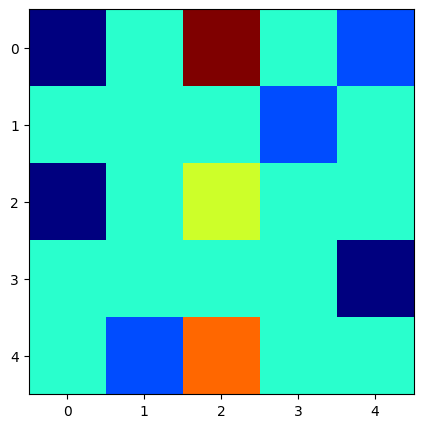

Agents' Status:
  Agent 1: Position (2, 3), Carrying: No
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (0, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 5
  Location (4, 1): Blocks remaining 5

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 0
  Location (3, 4): Blocks delivered 0
------------------------------


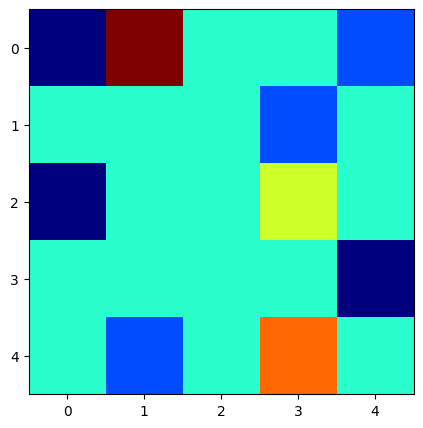

Agents' Status:
  Agent 1: Position (3, 3), Carrying: No
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (0, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 5
  Location (4, 1): Blocks remaining 5

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 0
  Location (3, 4): Blocks delivered 0
------------------------------


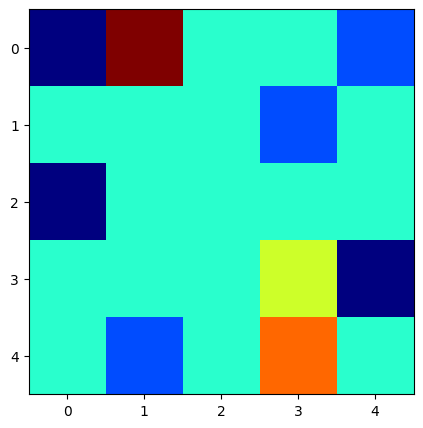

Agents' Status:
  Agent 1: Position (3, 2), Carrying: No
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (0, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 5
  Location (4, 1): Blocks remaining 5

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 0
  Location (3, 4): Blocks delivered 0
------------------------------


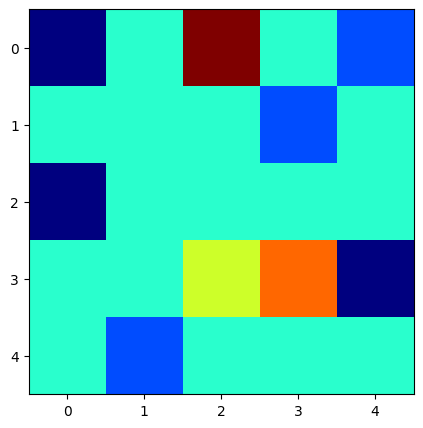

Agents' Status:
  Agent 1: Position (4, 2), Carrying: No
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (0, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 5
  Location (4, 1): Blocks remaining 5

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 0
  Location (3, 4): Blocks delivered 0
------------------------------


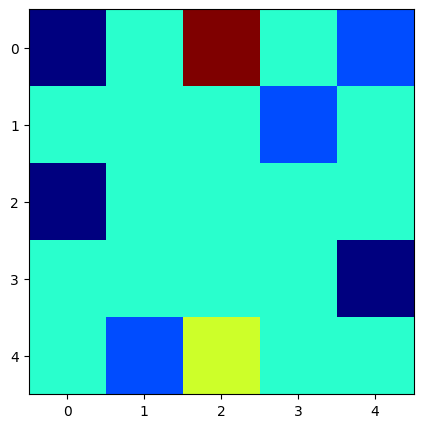

Agents' Status:
  Agent 1: Position (4, 1), Carrying: Yes
  Agent 2: Position (4, 4), Carrying: No
  Agent 3: Position (0, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 5
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 0
  Location (3, 4): Blocks delivered 0
------------------------------


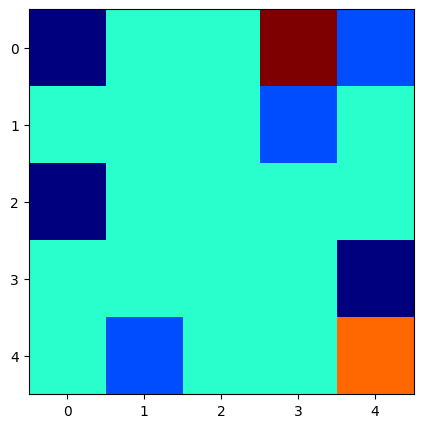

Agents' Status:
  Agent 1: Position (4, 0), Carrying: Yes
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 0
  Location (3, 4): Blocks delivered 0
------------------------------


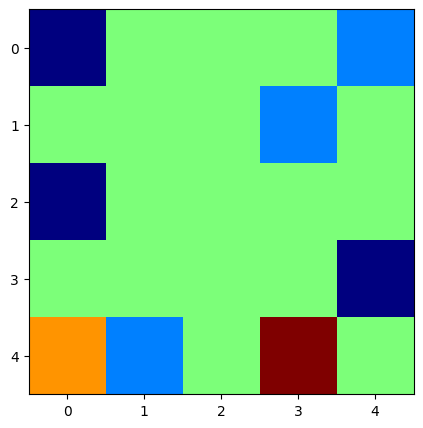

Agents' Status:
  Agent 1: Position (3, 0), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (1, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 0
  Location (3, 4): Blocks delivered 0
------------------------------


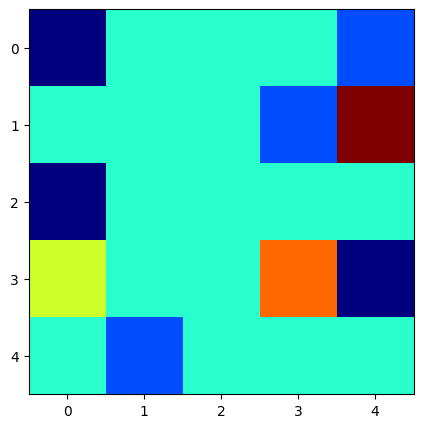

Agents' Status:
  Agent 1: Position (2, 0), Carrying: No
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (1, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 0
------------------------------


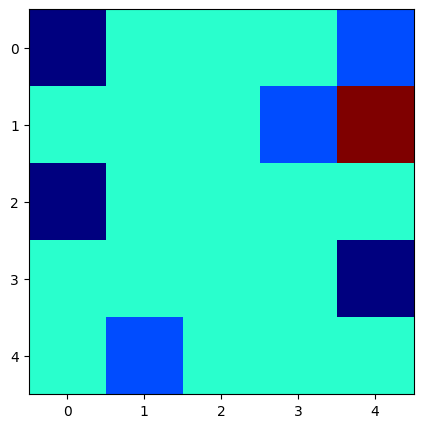

Agents' Status:
  Agent 1: Position (2, 1), Carrying: No
  Agent 2: Position (2, 4), Carrying: No
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 0
------------------------------


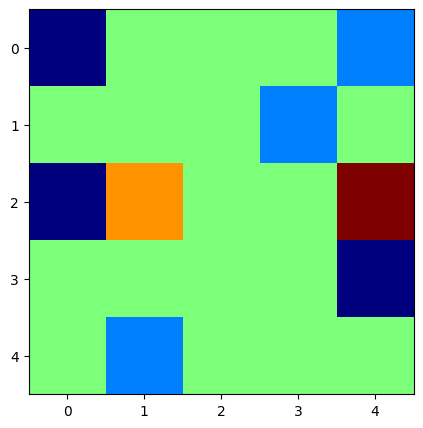

Agents' Status:
  Agent 1: Position (1, 1), Carrying: No
  Agent 2: Position (2, 3), Carrying: No
  Agent 3: Position (2, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 0
------------------------------


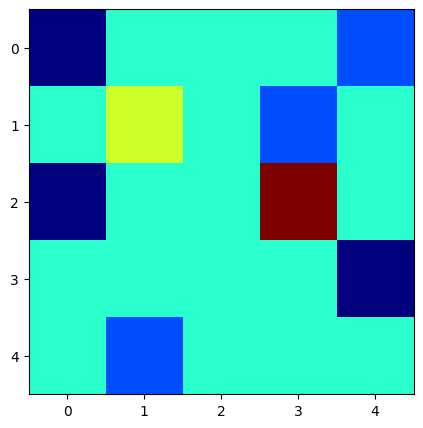

Agents' Status:
  Agent 1: Position (2, 1), Carrying: No
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (2, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 0
------------------------------


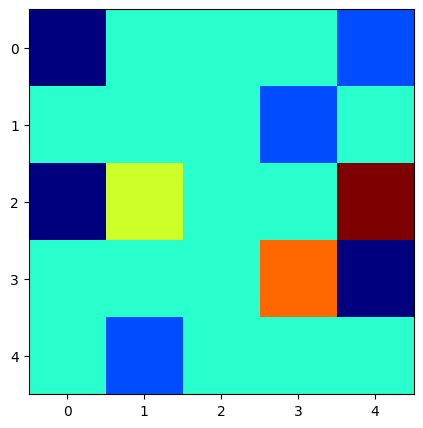

Agents' Status:
  Agent 1: Position (3, 1), Carrying: No
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (1, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 0
------------------------------


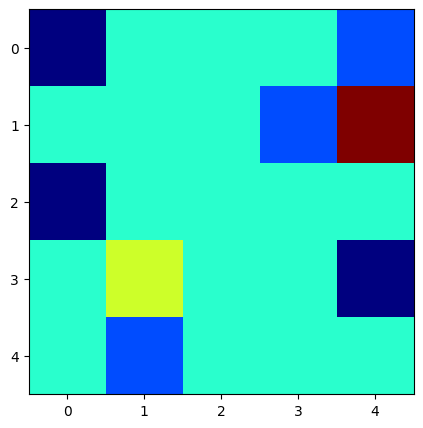

Agents' Status:
  Agent 1: Position (3, 2), Carrying: No
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (2, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 0
------------------------------


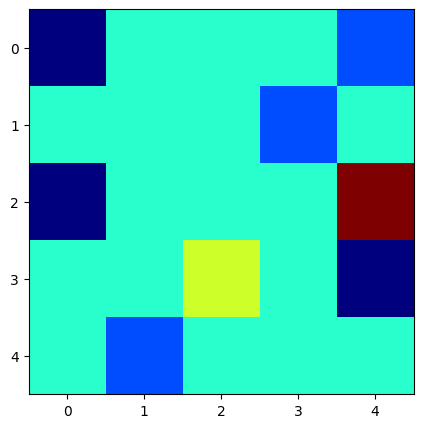

Agents' Status:
  Agent 1: Position (3, 3), Carrying: No
  Agent 2: Position (2, 4), Carrying: No
  Agent 3: Position (3, 4), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


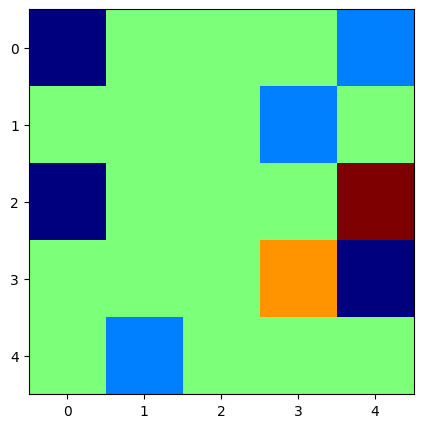

Agents' Status:
  Agent 1: Position (3, 4), Carrying: No
  Agent 2: Position (2, 4), Carrying: No
  Agent 3: Position (3, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


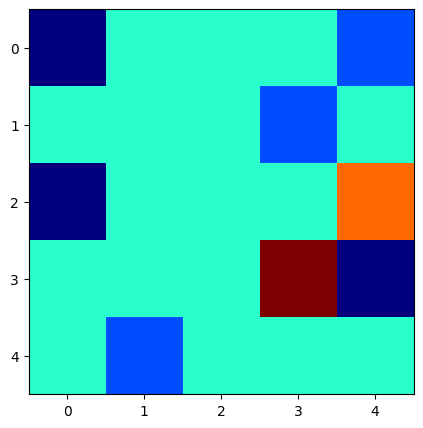

Agents' Status:
  Agent 1: Position (2, 4), Carrying: No
  Agent 2: Position (1, 4), Carrying: No
  Agent 3: Position (3, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


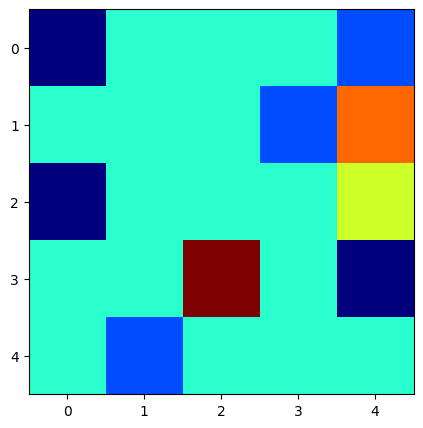

Agents' Status:
  Agent 1: Position (2, 4), Carrying: No
  Agent 2: Position (2, 4), Carrying: No
  Agent 3: Position (4, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


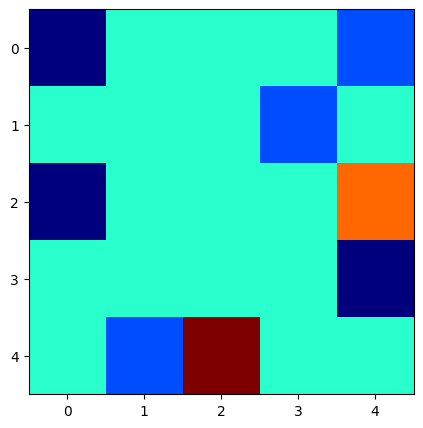

Agents' Status:
  Agent 1: Position (1, 4), Carrying: No
  Agent 2: Position (2, 4), Carrying: No
  Agent 3: Position (4, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 5
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


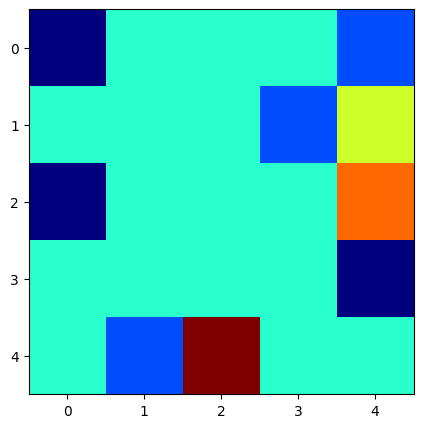

Agents' Status:
  Agent 1: Position (0, 4), Carrying: Yes
  Agent 2: Position (2, 3), Carrying: No
  Agent 3: Position (4, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


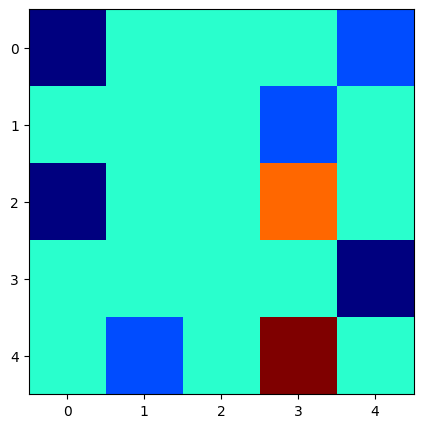

Agents' Status:
  Agent 1: Position (0, 3), Carrying: Yes
  Agent 2: Position (2, 2), Carrying: No
  Agent 3: Position (4, 4), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


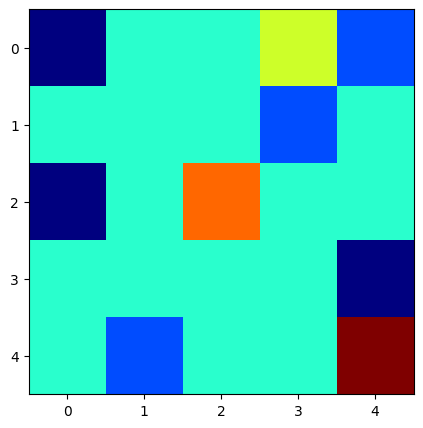

Agents' Status:
  Agent 1: Position (0, 2), Carrying: Yes
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (4, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


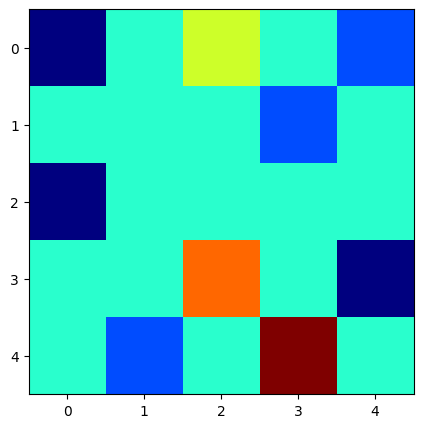

Agents' Status:
  Agent 1: Position (0, 3), Carrying: Yes
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (3, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


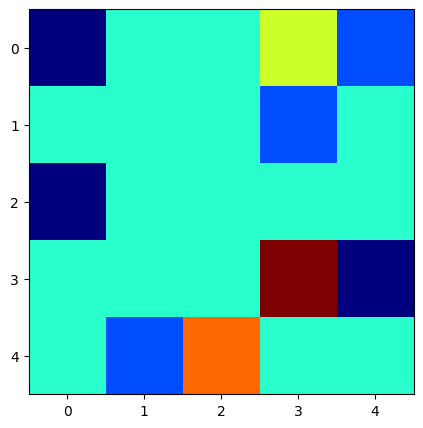

Agents' Status:
  Agent 1: Position (1, 3), Carrying: Yes
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (4, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


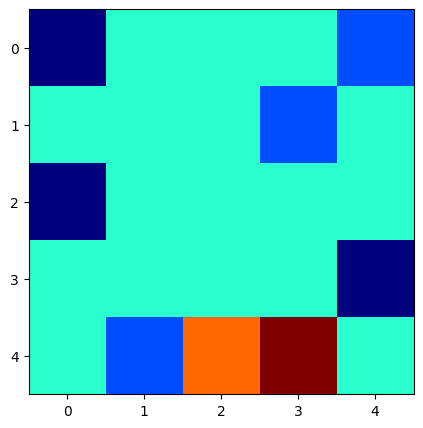

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (3, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


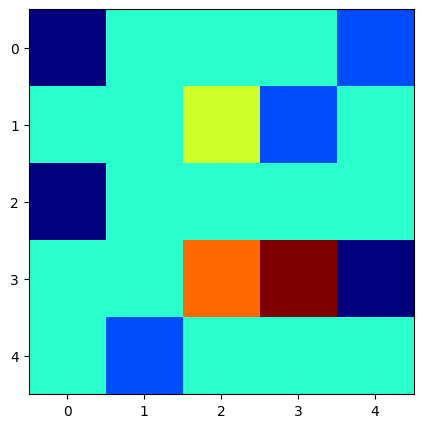

Agents' Status:
  Agent 1: Position (1, 1), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (3, 4), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


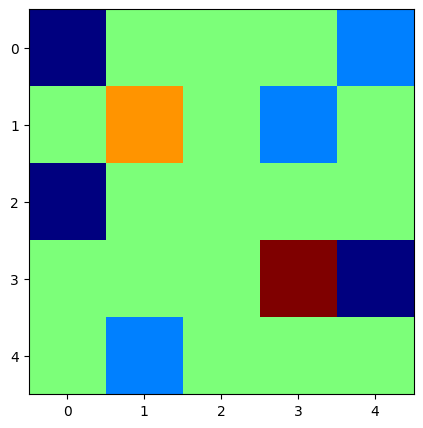

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (3, 4), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


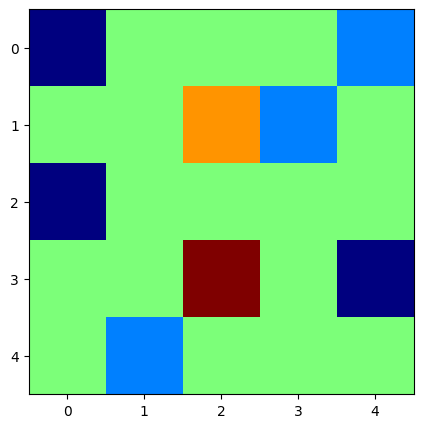

Agents' Status:
  Agent 1: Position (1, 3), Carrying: Yes
  Agent 2: Position (3, 1), Carrying: No
  Agent 3: Position (3, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


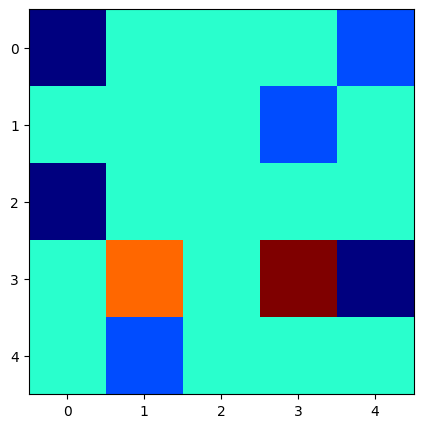

Agents' Status:
  Agent 1: Position (0, 3), Carrying: Yes
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (3, 4), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


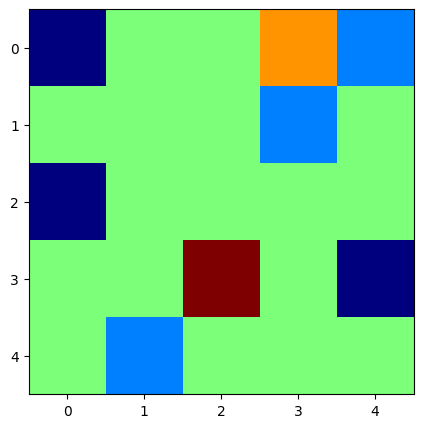

Agents' Status:
  Agent 1: Position (0, 2), Carrying: Yes
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (3, 4), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


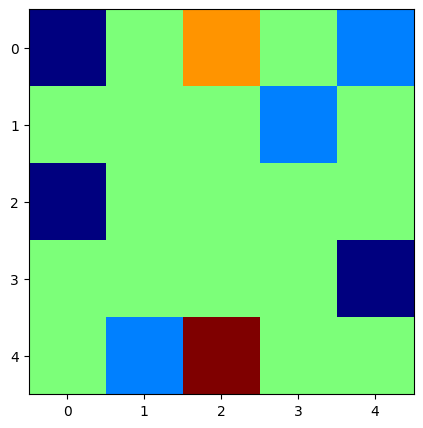

Agents' Status:
  Agent 1: Position (0, 1), Carrying: Yes
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (3, 4), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 0
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


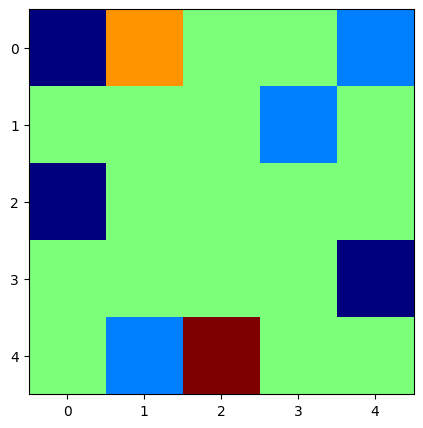

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (3, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


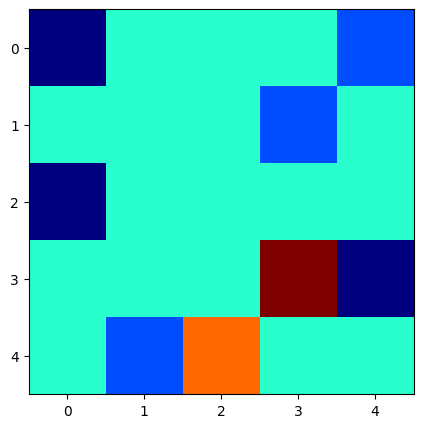

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (3, 4), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


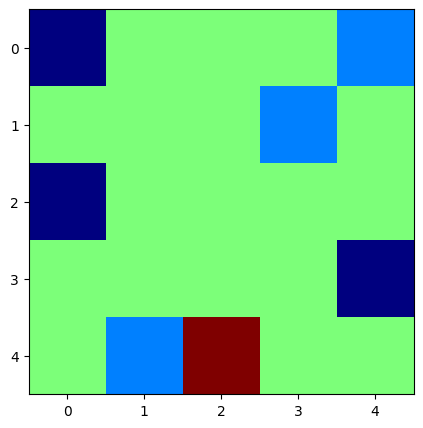

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (3, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


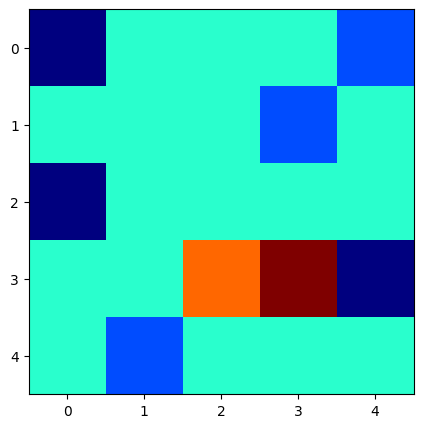

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (3, 1), Carrying: No
  Agent 3: Position (3, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 4

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


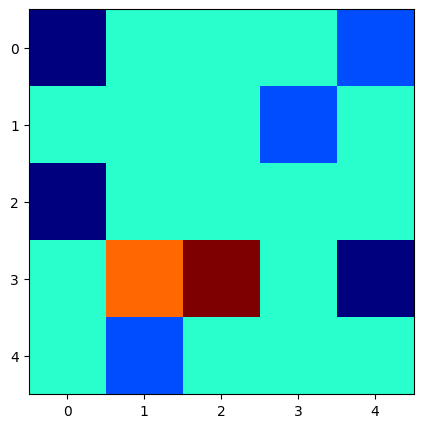

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (4, 1), Carrying: Yes
  Agent 3: Position (4, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


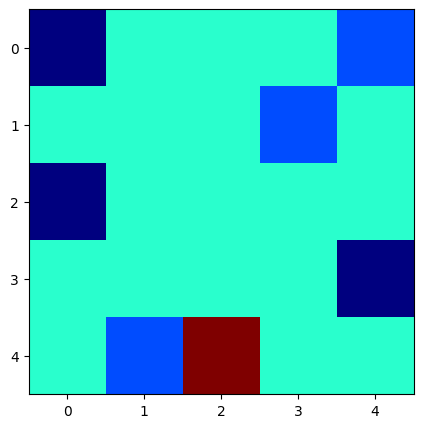

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (4, 0), Carrying: Yes
  Agent 3: Position (4, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


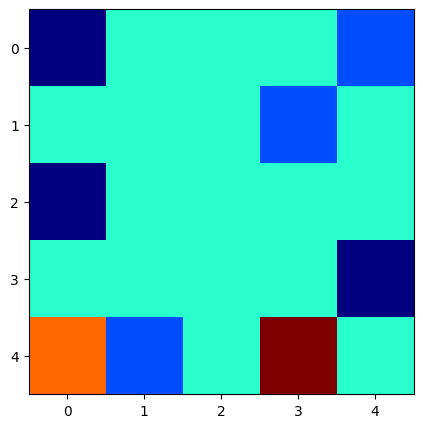

Agents' Status:
  Agent 1: Position (1, 0), Carrying: No
  Agent 2: Position (4, 1), Carrying: Yes
  Agent 3: Position (4, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


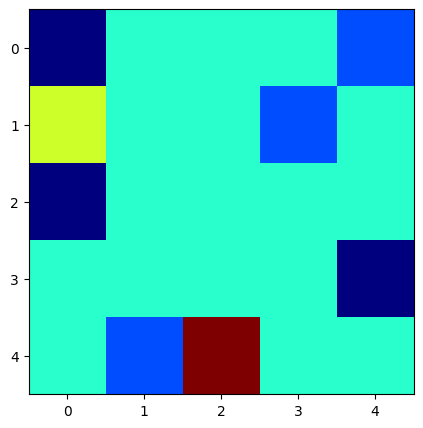

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (4, 2), Carrying: Yes
  Agent 3: Position (3, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


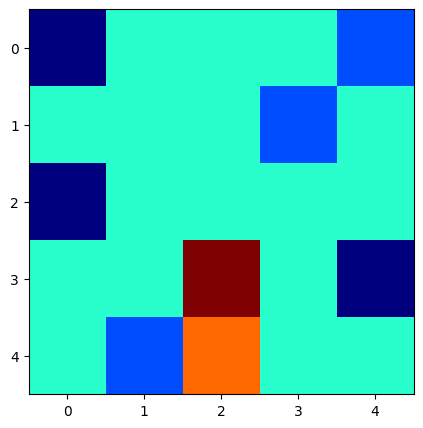

Agents' Status:
  Agent 1: Position (0, 1), Carrying: No
  Agent 2: Position (4, 1), Carrying: Yes
  Agent 3: Position (2, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


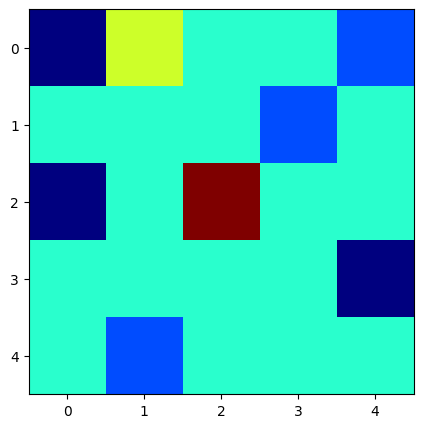

Agents' Status:
  Agent 1: Position (0, 1), Carrying: No
  Agent 2: Position (4, 0), Carrying: Yes
  Agent 3: Position (1, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


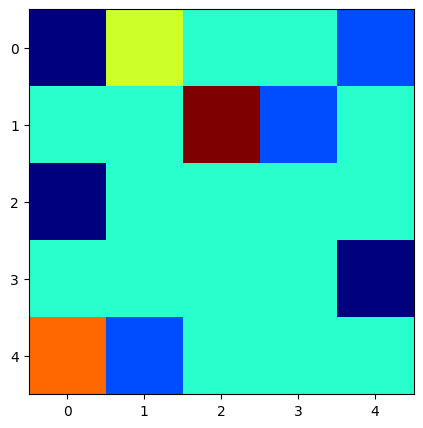

Agents' Status:
  Agent 1: Position (1, 1), Carrying: No
  Agent 2: Position (4, 1), Carrying: Yes
  Agent 3: Position (2, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


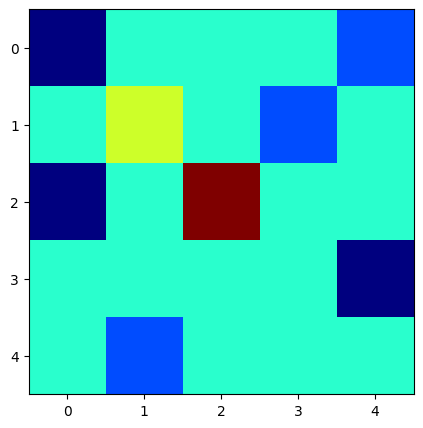

Agents' Status:
  Agent 1: Position (2, 1), Carrying: No
  Agent 2: Position (4, 1), Carrying: Yes
  Agent 3: Position (1, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


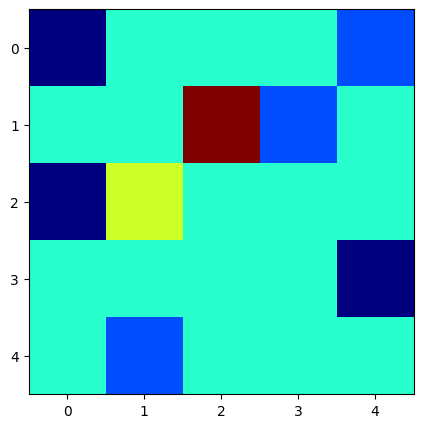

Agents' Status:
  Agent 1: Position (2, 2), Carrying: No
  Agent 2: Position (4, 2), Carrying: Yes
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


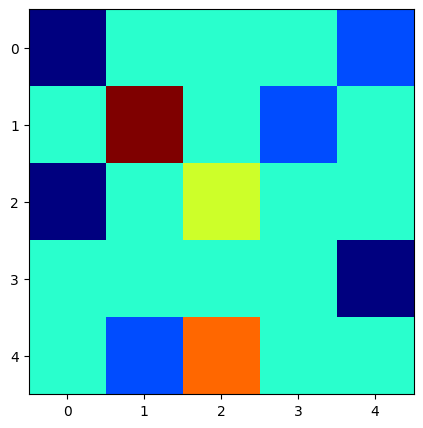

Agents' Status:
  Agent 1: Position (2, 1), Carrying: No
  Agent 2: Position (3, 2), Carrying: Yes
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


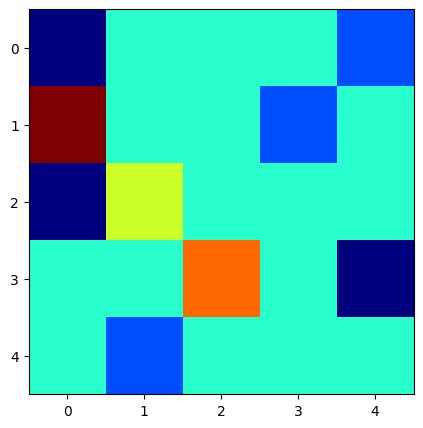

Agents' Status:
  Agent 1: Position (2, 2), Carrying: No
  Agent 2: Position (3, 3), Carrying: Yes
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


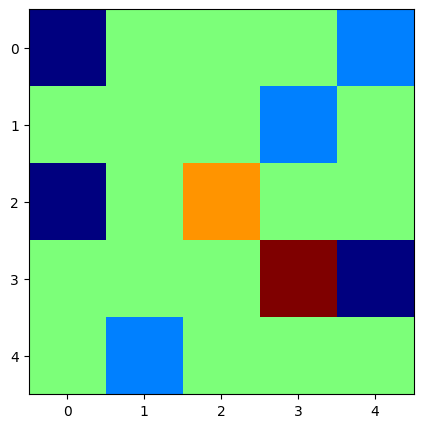

Agents' Status:
  Agent 1: Position (1, 2), Carrying: No
  Agent 2: Position (2, 3), Carrying: Yes
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


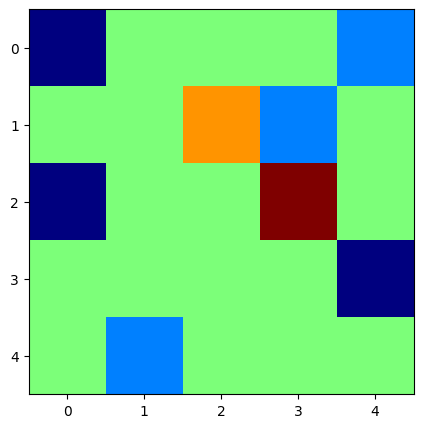

Agents' Status:
  Agent 1: Position (1, 1), Carrying: No
  Agent 2: Position (3, 3), Carrying: Yes
  Agent 3: Position (0, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 1
------------------------------


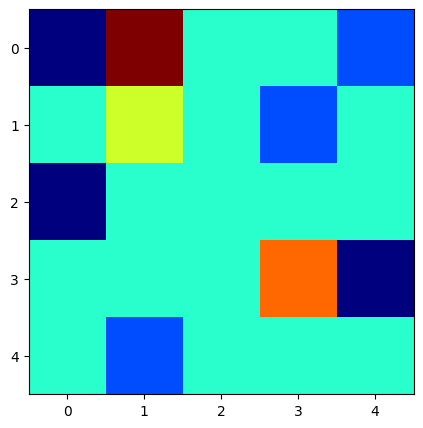

Agents' Status:
  Agent 1: Position (0, 1), Carrying: No
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (0, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


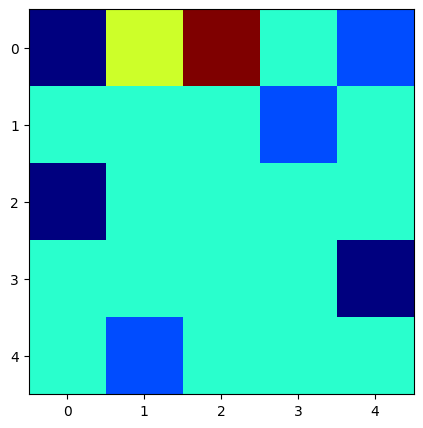

Agents' Status:
  Agent 1: Position (1, 1), Carrying: No
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (1, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 4
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


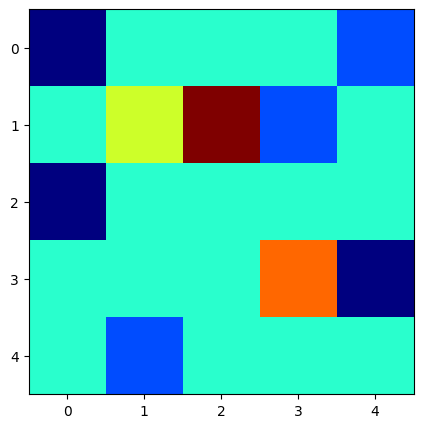

Agents' Status:
  Agent 1: Position (0, 1), Carrying: No
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


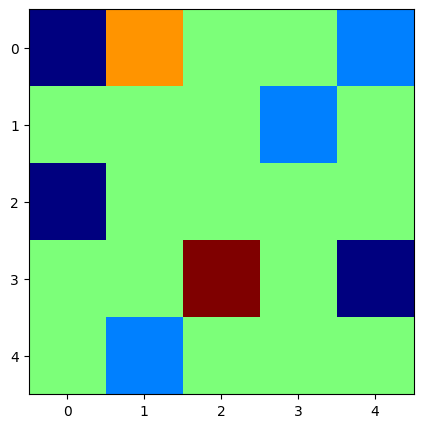

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (3, 1), Carrying: No
  Agent 3: Position (2, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


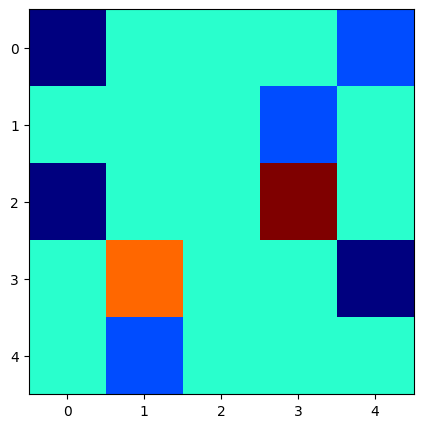

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


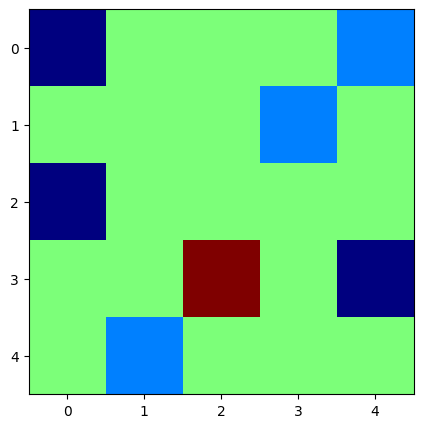

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (1, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 3

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


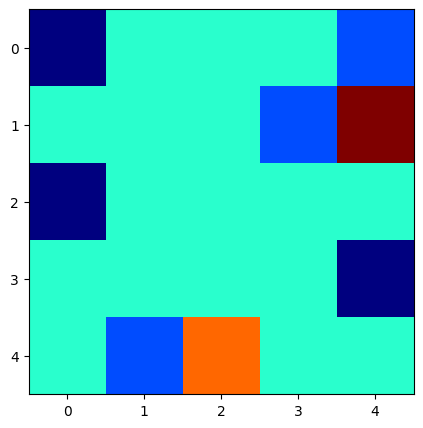

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (4, 1), Carrying: Yes
  Agent 3: Position (1, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


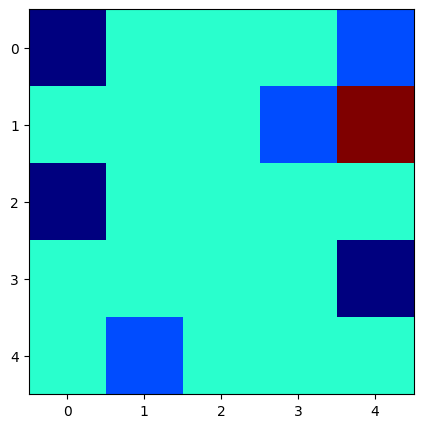

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (3, 1), Carrying: Yes
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


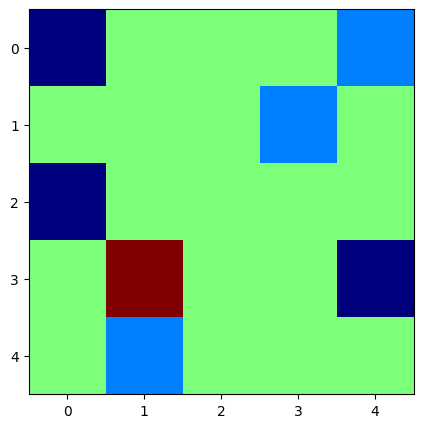

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (2, 1), Carrying: Yes
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


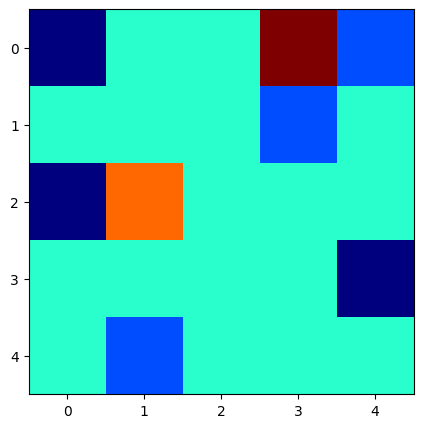

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (2, 2), Carrying: Yes
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


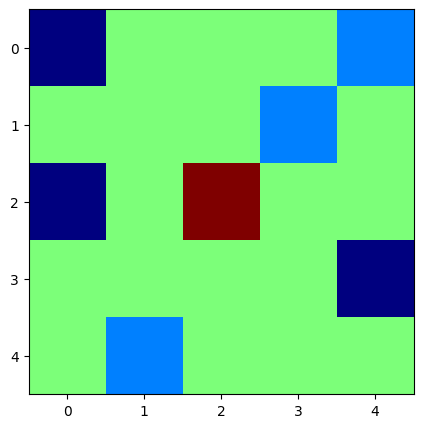

Agents' Status:
  Agent 1: Position (0, 1), Carrying: No
  Agent 2: Position (2, 3), Carrying: Yes
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


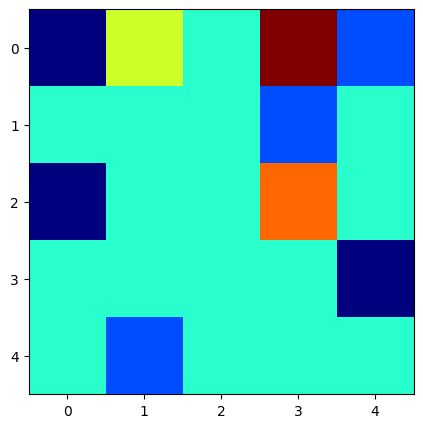

Agents' Status:
  Agent 1: Position (0, 1), Carrying: No
  Agent 2: Position (3, 3), Carrying: Yes
  Agent 3: Position (0, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


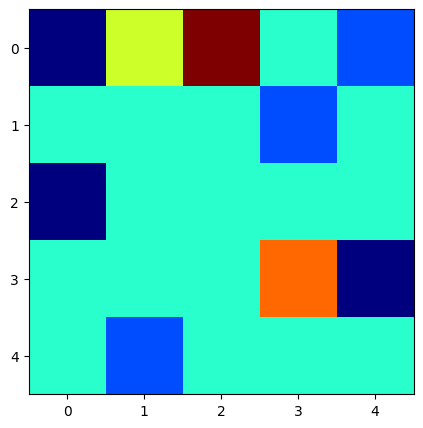

Agents' Status:
  Agent 1: Position (0, 1), Carrying: No
  Agent 2: Position (3, 2), Carrying: Yes
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


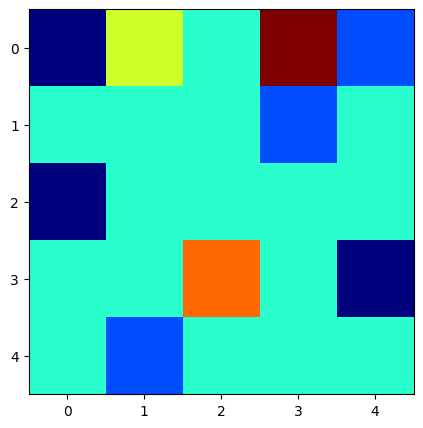

Agents' Status:
  Agent 1: Position (1, 1), Carrying: No
  Agent 2: Position (3, 1), Carrying: Yes
  Agent 3: Position (0, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


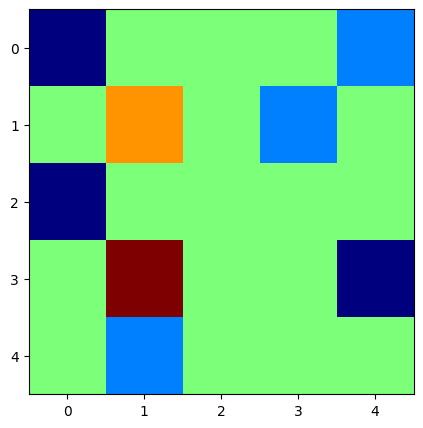

Agents' Status:
  Agent 1: Position (1, 0), Carrying: No
  Agent 2: Position (3, 2), Carrying: Yes
  Agent 3: Position (0, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


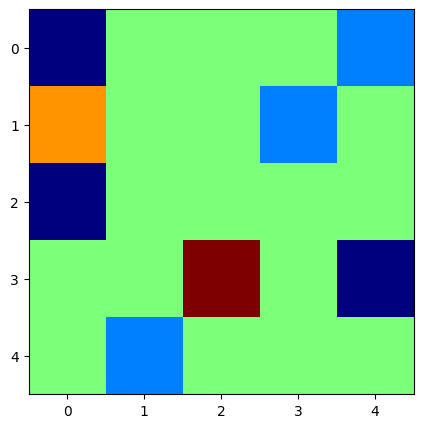

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (3, 1), Carrying: Yes
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


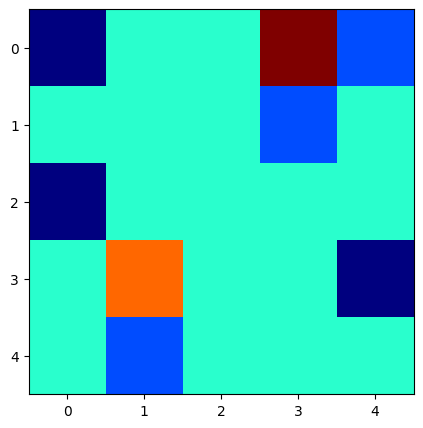

Agents' Status:
  Agent 1: Position (0, 1), Carrying: No
  Agent 2: Position (3, 0), Carrying: Yes
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


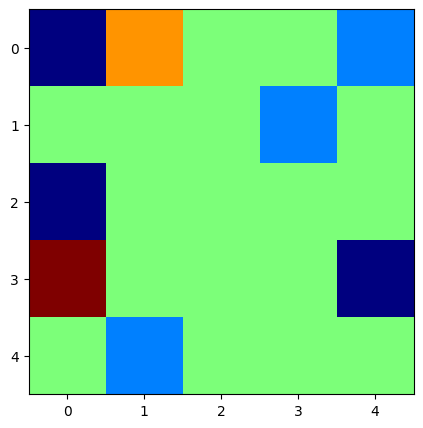

Agents' Status:
  Agent 1: Position (0, 2), Carrying: No
  Agent 2: Position (3, 1), Carrying: Yes
  Agent 3: Position (1, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


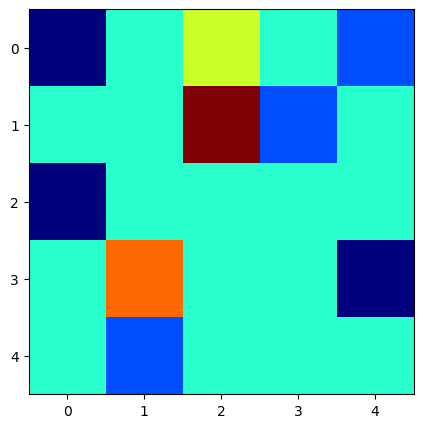

Agents' Status:
  Agent 1: Position (1, 2), Carrying: No
  Agent 2: Position (3, 0), Carrying: Yes
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 3
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


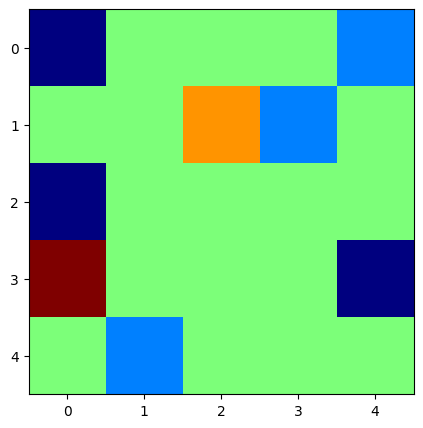

Agents' Status:
  Agent 1: Position (1, 3), Carrying: Yes
  Agent 2: Position (3, 0), Carrying: Yes
  Agent 3: Position (1, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


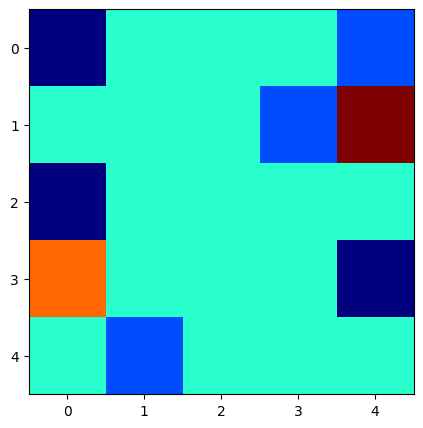

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (4, 0), Carrying: Yes
  Agent 3: Position (0, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


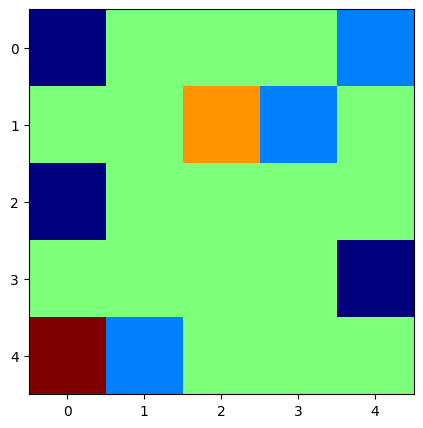

Agents' Status:
  Agent 1: Position (0, 2), Carrying: Yes
  Agent 2: Position (4, 0), Carrying: Yes
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


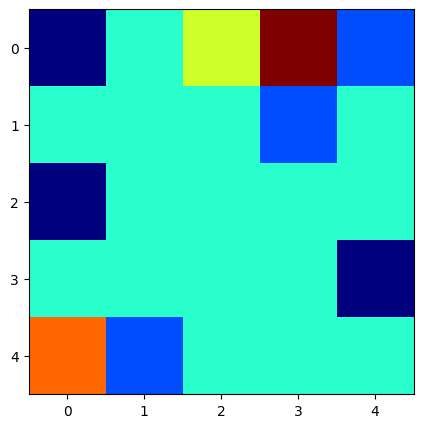

Agents' Status:
  Agent 1: Position (0, 2), Carrying: Yes
  Agent 2: Position (4, 0), Carrying: Yes
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


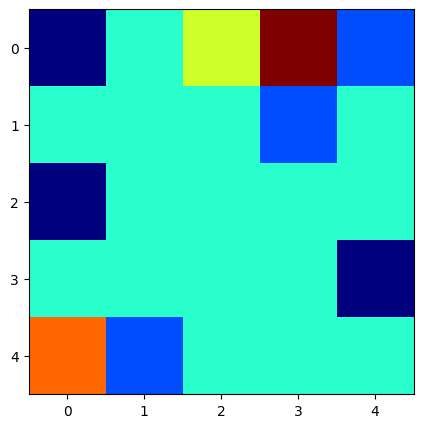

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (4, 0), Carrying: Yes
  Agent 3: Position (0, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


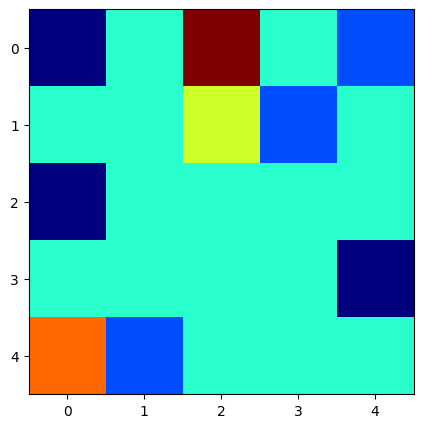

Agents' Status:
  Agent 1: Position (2, 2), Carrying: Yes
  Agent 2: Position (4, 0), Carrying: Yes
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


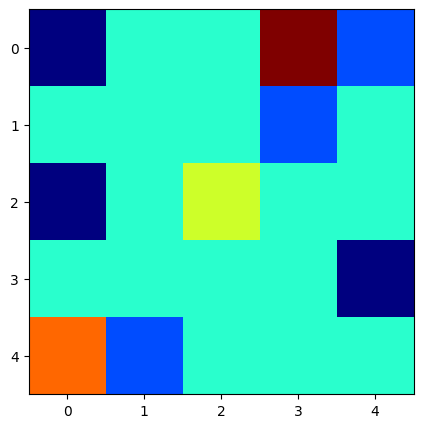

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (4, 1), Carrying: Yes
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


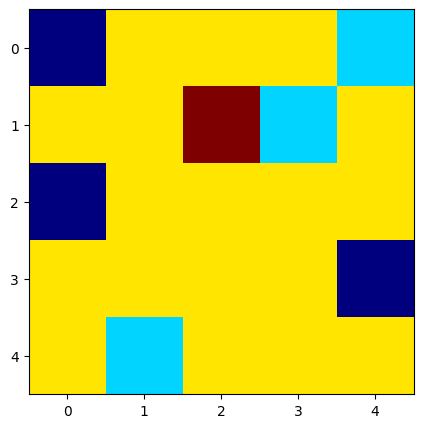

Agents' Status:
  Agent 1: Position (2, 2), Carrying: Yes
  Agent 2: Position (3, 1), Carrying: Yes
  Agent 3: Position (2, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


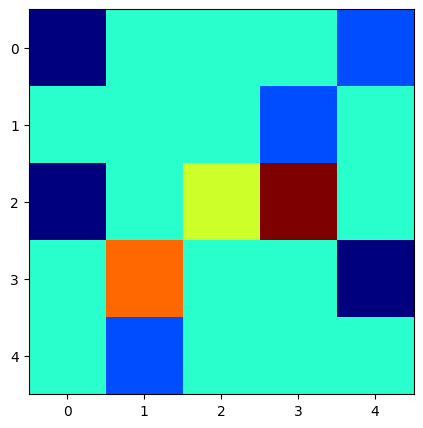

Agents' Status:
  Agent 1: Position (2, 3), Carrying: Yes
  Agent 2: Position (3, 0), Carrying: Yes
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


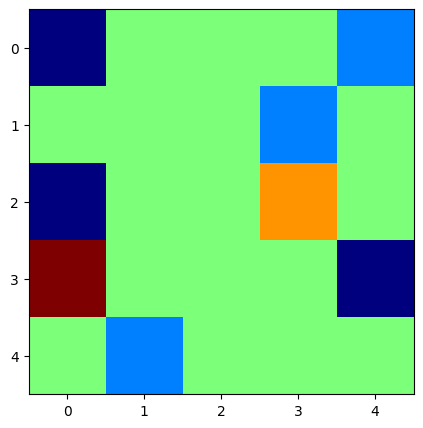

Agents' Status:
  Agent 1: Position (2, 2), Carrying: Yes
  Agent 2: Position (3, 1), Carrying: Yes
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


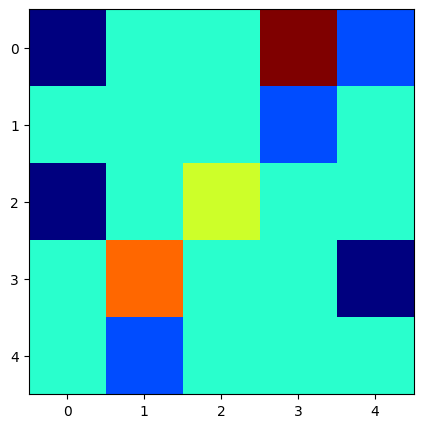

Agents' Status:
  Agent 1: Position (3, 2), Carrying: Yes
  Agent 2: Position (2, 1), Carrying: Yes
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


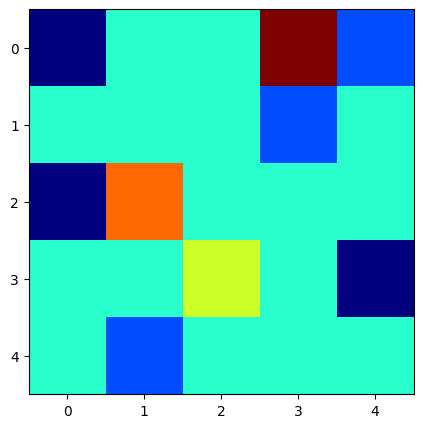

Agents' Status:
  Agent 1: Position (3, 1), Carrying: Yes
  Agent 2: Position (1, 1), Carrying: Yes
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


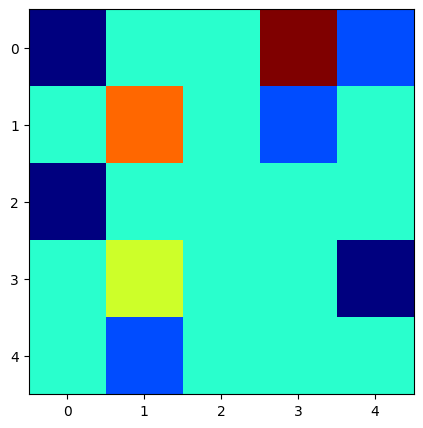

Agents' Status:
  Agent 1: Position (3, 0), Carrying: Yes
  Agent 2: Position (0, 1), Carrying: Yes
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 1
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


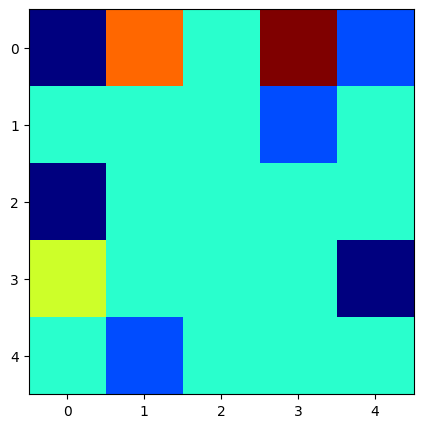

Agents' Status:
  Agent 1: Position (3, 1), Carrying: Yes
  Agent 2: Position (0, 0), Carrying: No
  Agent 3: Position (0, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


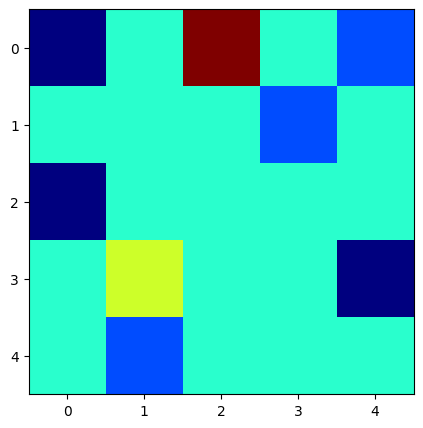

Agents' Status:
  Agent 1: Position (3, 2), Carrying: Yes
  Agent 2: Position (0, 0), Carrying: No
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


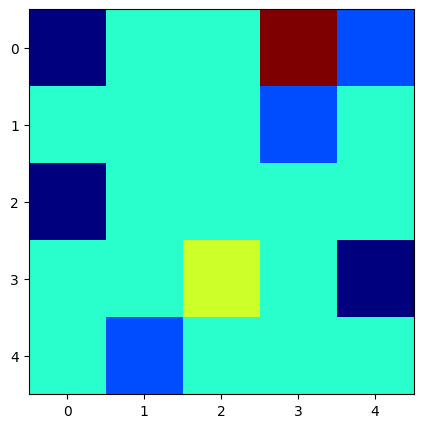

Agents' Status:
  Agent 1: Position (3, 1), Carrying: Yes
  Agent 2: Position (0, 0), Carrying: No
  Agent 3: Position (0, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


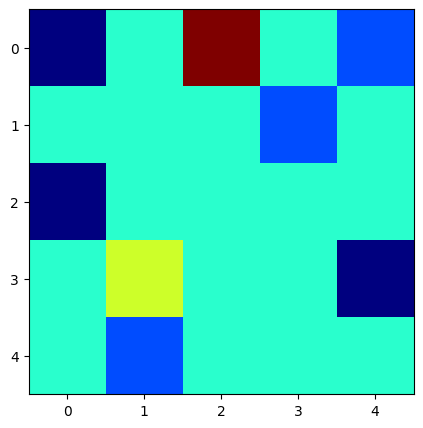

Agents' Status:
  Agent 1: Position (4, 1), Carrying: Yes
  Agent 2: Position (1, 0), Carrying: No
  Agent 3: Position (1, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


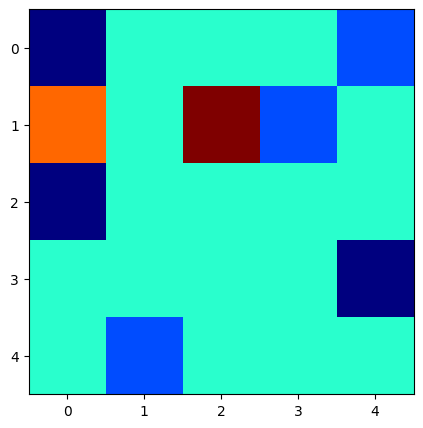

Agents' Status:
  Agent 1: Position (3, 1), Carrying: Yes
  Agent 2: Position (0, 0), Carrying: No
  Agent 3: Position (1, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


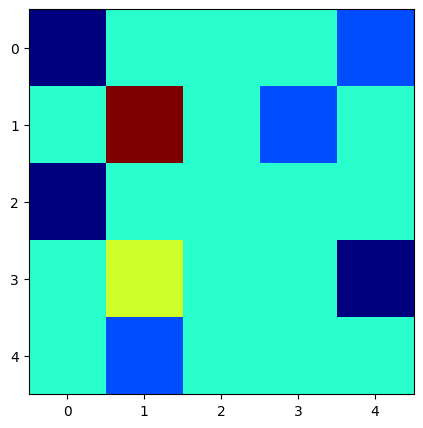

Agents' Status:
  Agent 1: Position (2, 1), Carrying: Yes
  Agent 2: Position (0, 0), Carrying: No
  Agent 3: Position (1, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


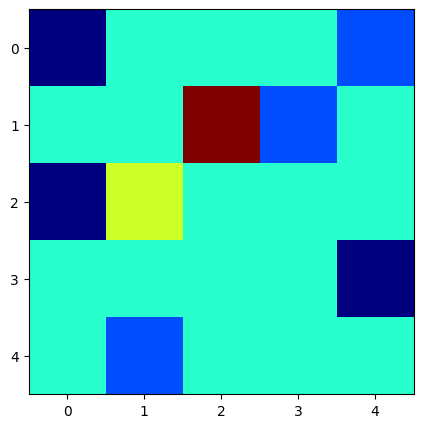

Agents' Status:
  Agent 1: Position (1, 1), Carrying: Yes
  Agent 2: Position (0, 1), Carrying: No
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


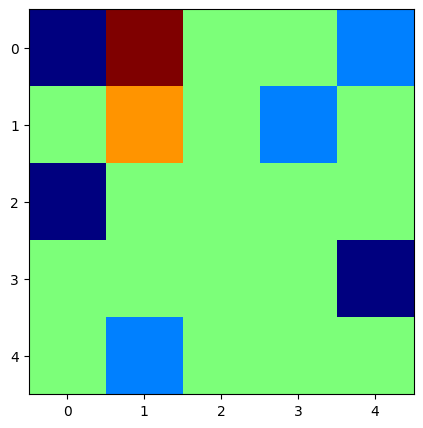

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (1, 1), Carrying: No
  Agent 3: Position (2, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


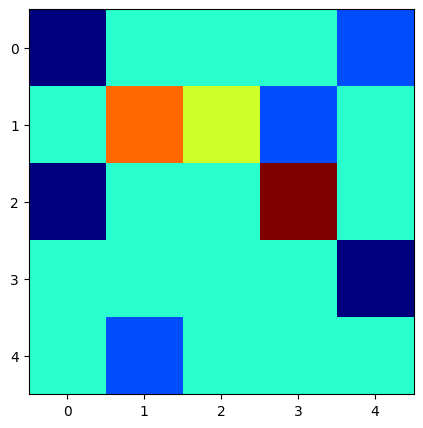

Agents' Status:
  Agent 1: Position (0, 2), Carrying: Yes
  Agent 2: Position (2, 1), Carrying: No
  Agent 3: Position (2, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


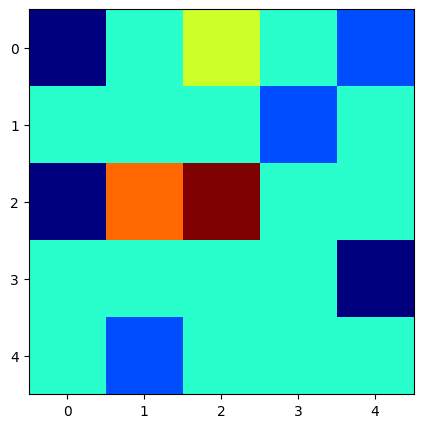

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (2, 2), Carrying: No
  Agent 3: Position (2, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 1
  Location (3, 4): Blocks delivered 2
------------------------------


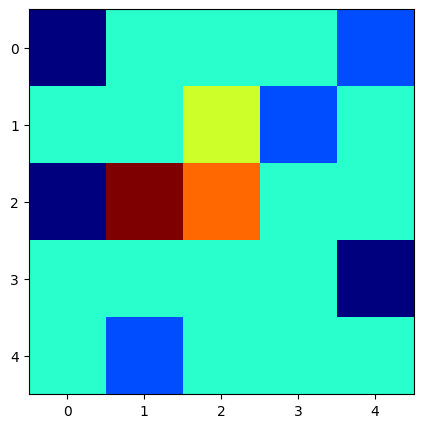

Agents' Status:
  Agent 1: Position (1, 1), Carrying: Yes
  Agent 2: Position (2, 1), Carrying: No
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 2
------------------------------


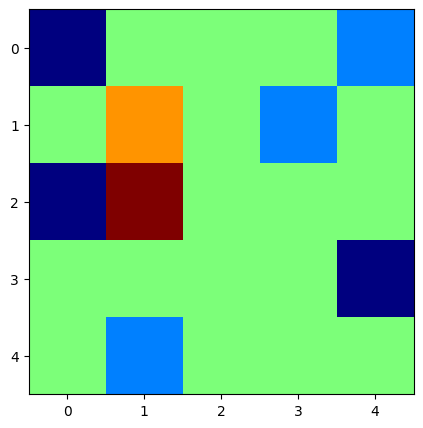

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (3, 1), Carrying: No
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 2
------------------------------


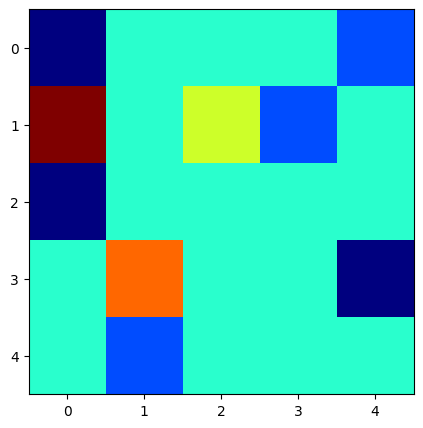

Agents' Status:
  Agent 1: Position (0, 2), Carrying: Yes
  Agent 2: Position (2, 1), Carrying: No
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 2
------------------------------


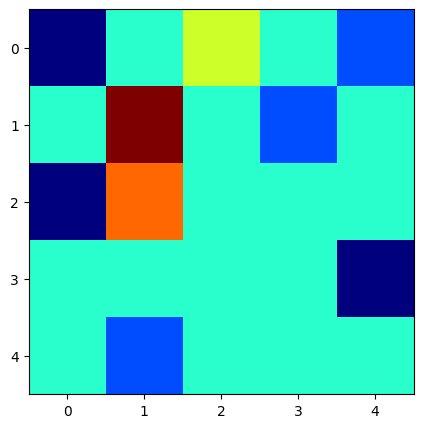

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (2, 2), Carrying: No
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 2
------------------------------


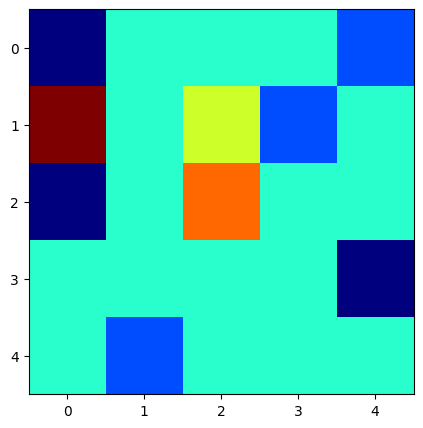

Agents' Status:
  Agent 1: Position (1, 1), Carrying: Yes
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 2
------------------------------


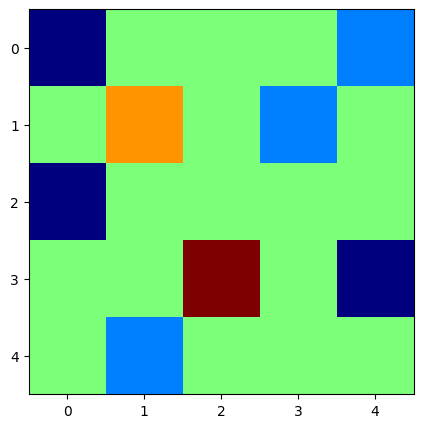

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (3, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 2
------------------------------


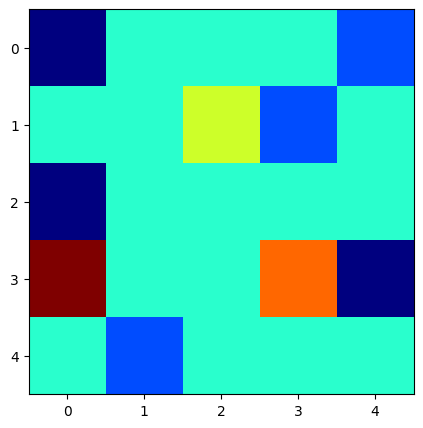

Agents' Status:
  Agent 1: Position (1, 3), Carrying: Yes
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (3, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 2
------------------------------


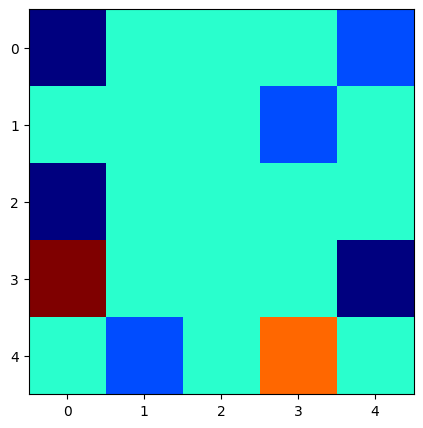

Agents' Status:
  Agent 1: Position (2, 3), Carrying: Yes
  Agent 2: Position (4, 4), Carrying: No
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 2
------------------------------


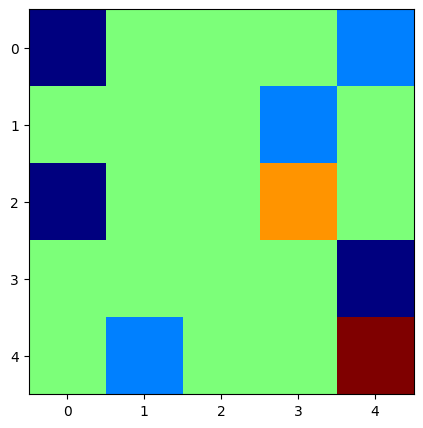

Agents' Status:
  Agent 1: Position (2, 4), Carrying: Yes
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (3, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 2
------------------------------


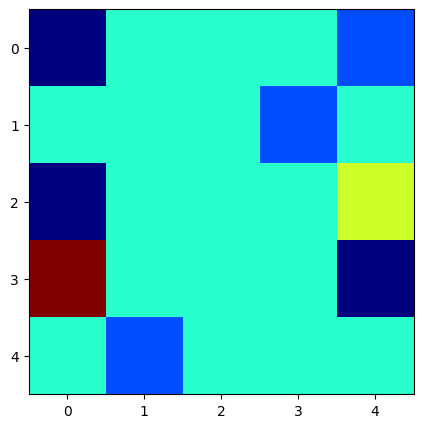

Agents' Status:
  Agent 1: Position (3, 4), Carrying: No
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


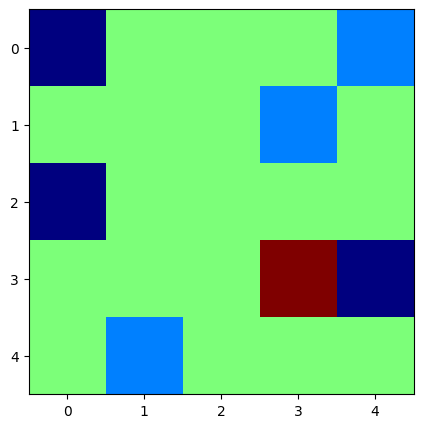

Agents' Status:
  Agent 1: Position (2, 4), Carrying: No
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (2, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


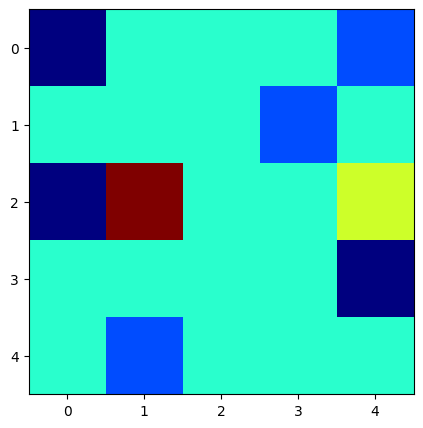

Agents' Status:
  Agent 1: Position (2, 4), Carrying: No
  Agent 2: Position (4, 4), Carrying: No
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


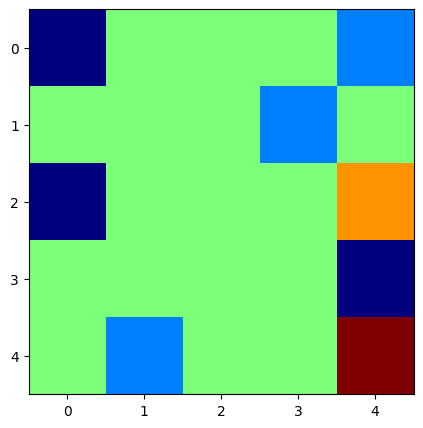

Agents' Status:
  Agent 1: Position (2, 3), Carrying: No
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 2
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


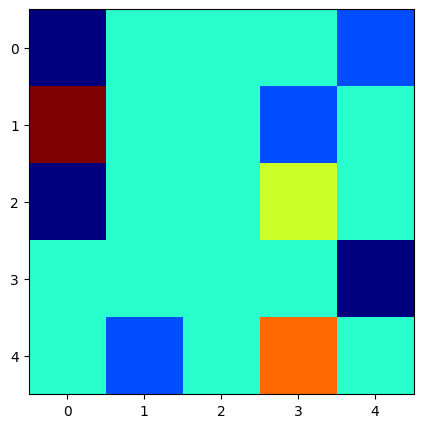

Agents' Status:
  Agent 1: Position (1, 3), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


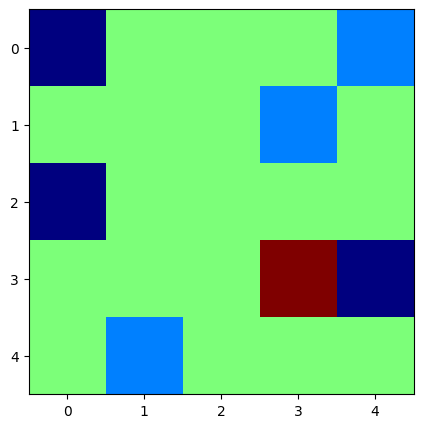

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


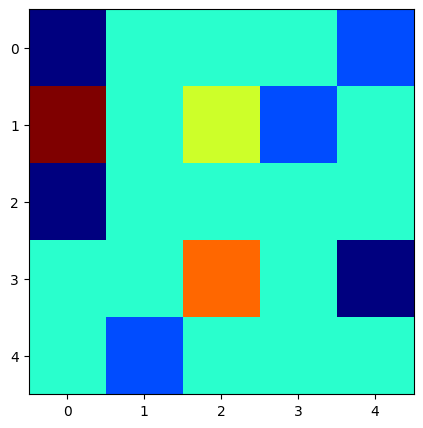

Agents' Status:
  Agent 1: Position (2, 2), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


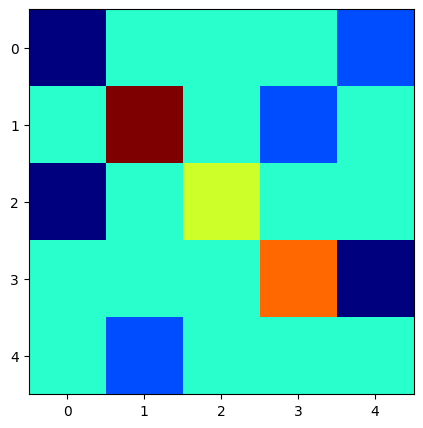

Agents' Status:
  Agent 1: Position (3, 2), Carrying: Yes
  Agent 2: Position (2, 3), Carrying: No
  Agent 3: Position (2, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


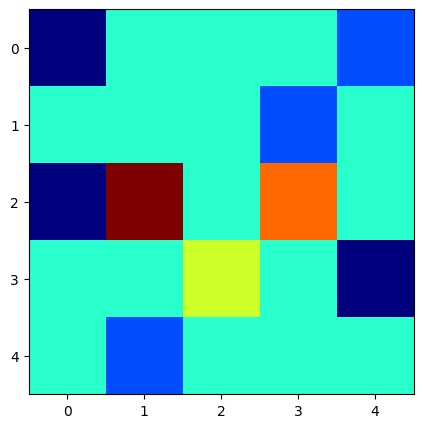

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


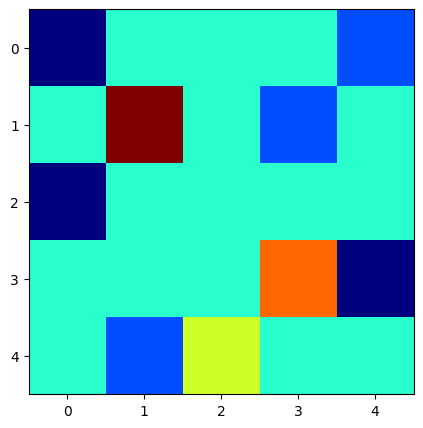

Agents' Status:
  Agent 1: Position (4, 1), Carrying: Yes
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


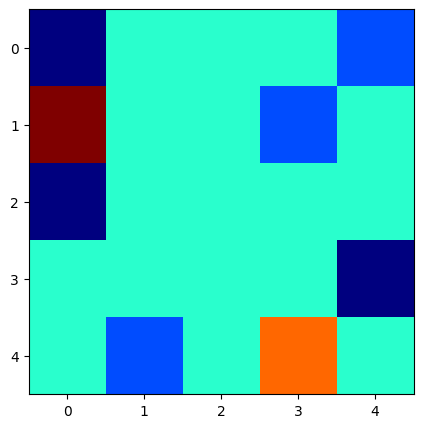

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


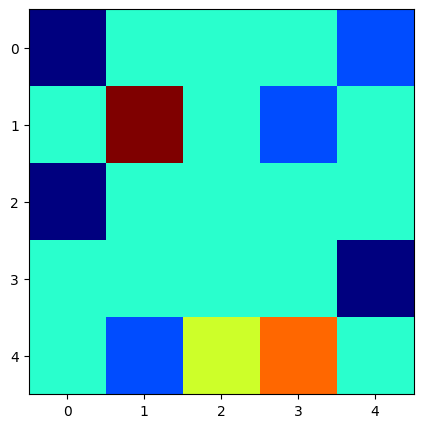

Agents' Status:
  Agent 1: Position (4, 3), Carrying: Yes
  Agent 2: Position (4, 4), Carrying: No
  Agent 3: Position (2, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


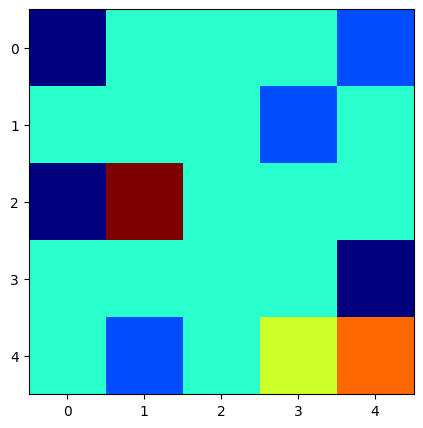

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (3, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 2

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


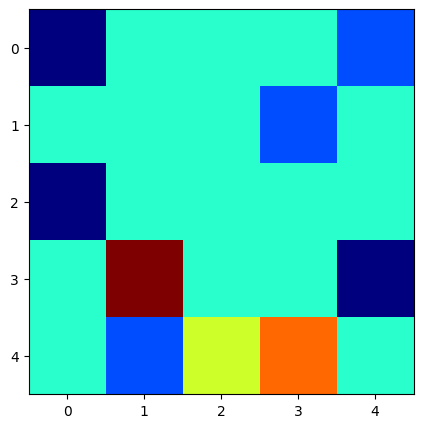

Agents' Status:
  Agent 1: Position (3, 2), Carrying: Yes
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (4, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


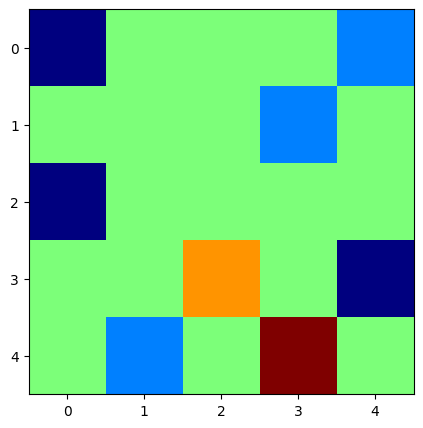

Agents' Status:
  Agent 1: Position (3, 3), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (3, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


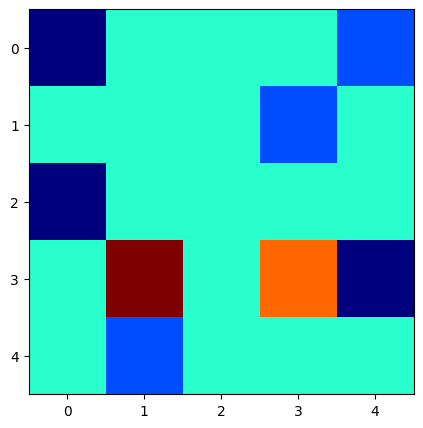

Agents' Status:
  Agent 1: Position (3, 2), Carrying: Yes
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (2, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


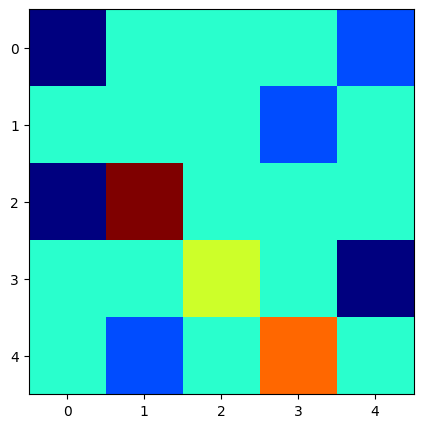

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (1, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


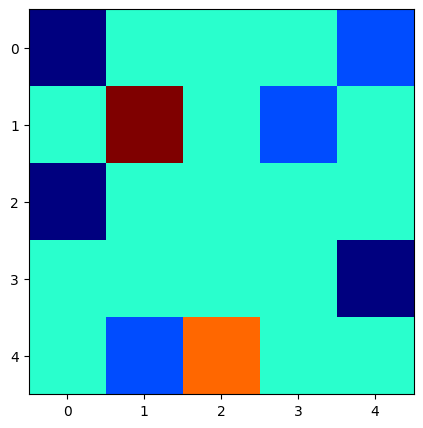

Agents' Status:
  Agent 1: Position (4, 3), Carrying: Yes
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (1, 0), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 2
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


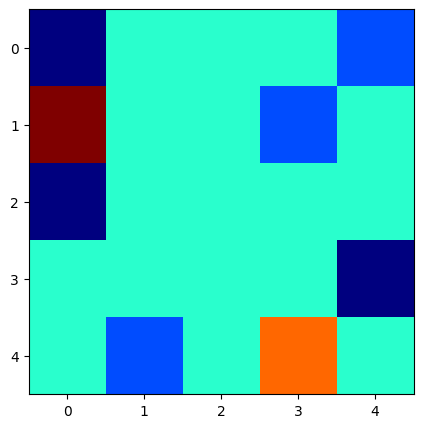

Agents' Status:
  Agent 1: Position (4, 3), Carrying: Yes
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


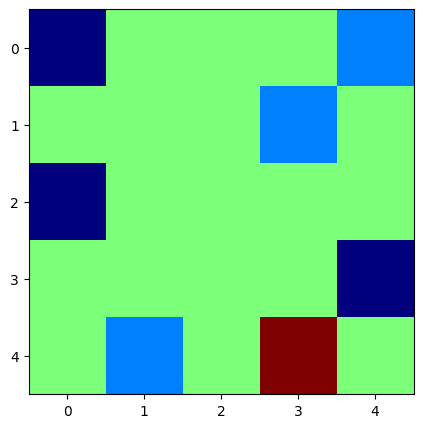

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


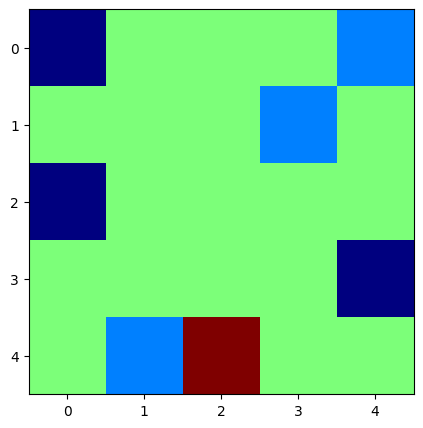

Agents' Status:
  Agent 1: Position (3, 2), Carrying: Yes
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


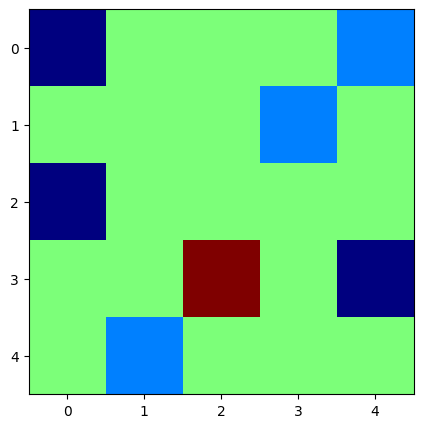

Agents' Status:
  Agent 1: Position (3, 1), Carrying: Yes
  Agent 2: Position (3, 1), Carrying: No
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


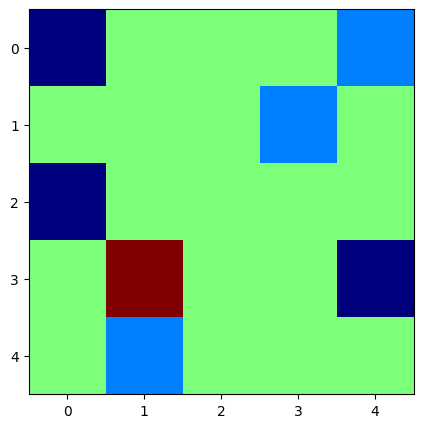

Agents' Status:
  Agent 1: Position (4, 1), Carrying: Yes
  Agent 2: Position (3, 0), Carrying: No
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


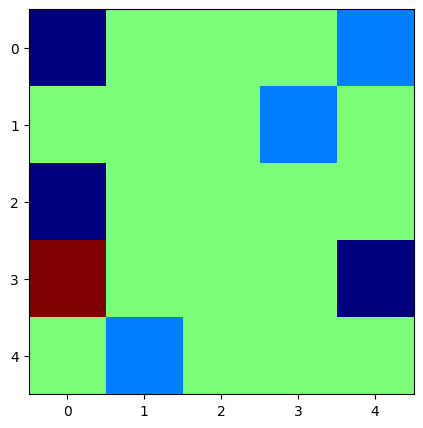

Agents' Status:
  Agent 1: Position (4, 0), Carrying: Yes
  Agent 2: Position (2, 0), Carrying: No
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


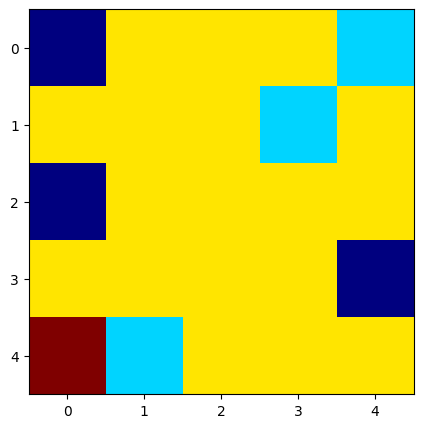

Agents' Status:
  Agent 1: Position (4, 0), Carrying: Yes
  Agent 2: Position (3, 0), Carrying: No
  Agent 3: Position (0, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


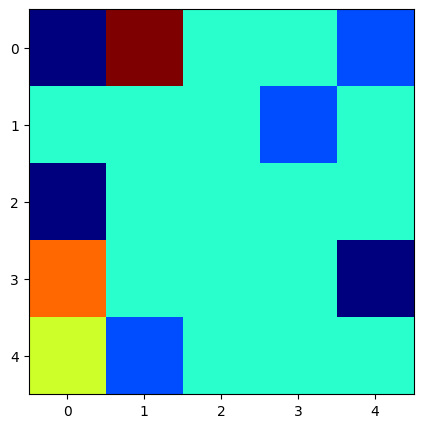

Agents' Status:
  Agent 1: Position (4, 0), Carrying: Yes
  Agent 2: Position (3, 0), Carrying: No
  Agent 3: Position (0, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


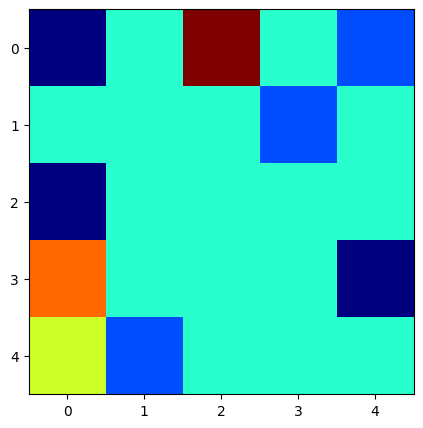

Agents' Status:
  Agent 1: Position (4, 0), Carrying: Yes
  Agent 2: Position (3, 0), Carrying: No
  Agent 3: Position (0, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


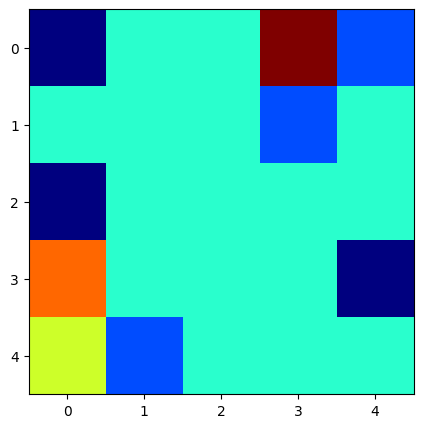

Agents' Status:
  Agent 1: Position (3, 0), Carrying: Yes
  Agent 2: Position (2, 0), Carrying: No
  Agent 3: Position (0, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


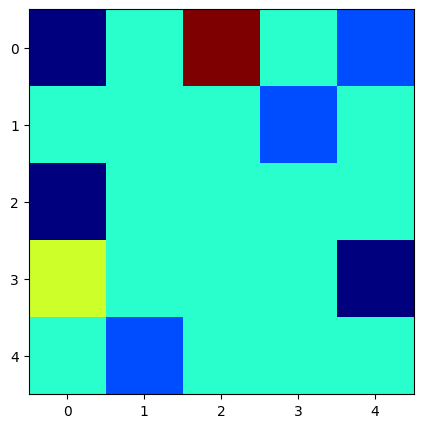

Agents' Status:
  Agent 1: Position (4, 0), Carrying: Yes
  Agent 2: Position (2, 0), Carrying: No
  Agent 3: Position (0, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


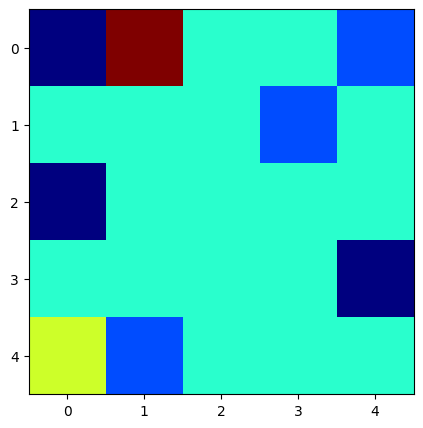

Agents' Status:
  Agent 1: Position (3, 0), Carrying: Yes
  Agent 2: Position (1, 0), Carrying: No
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


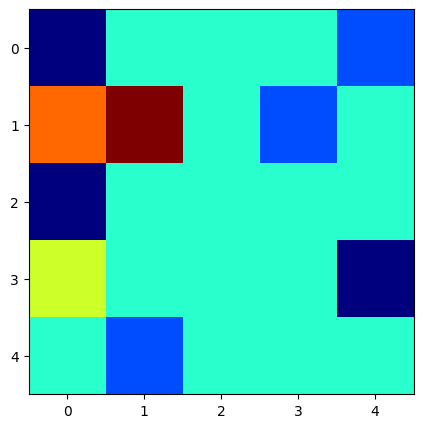

Agents' Status:
  Agent 1: Position (3, 1), Carrying: Yes
  Agent 2: Position (1, 0), Carrying: No
  Agent 3: Position (1, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


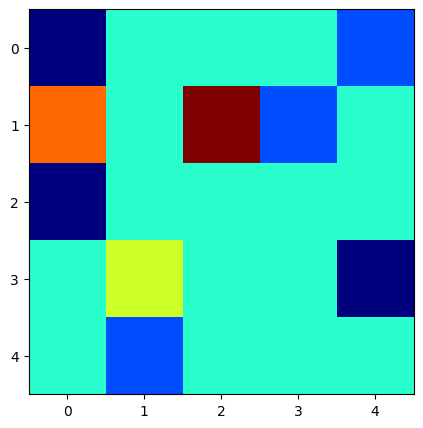

Agents' Status:
  Agent 1: Position (4, 1), Carrying: Yes
  Agent 2: Position (1, 0), Carrying: No
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


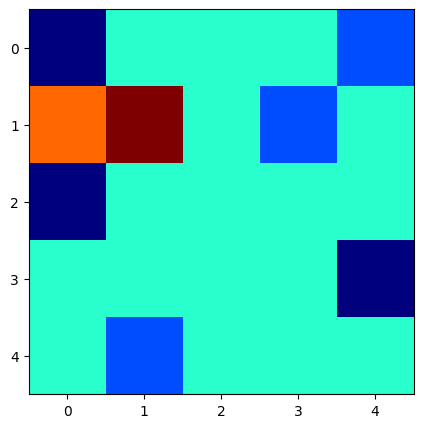

Agents' Status:
  Agent 1: Position (4, 0), Carrying: Yes
  Agent 2: Position (2, 0), Carrying: No
  Agent 3: Position (1, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 1
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


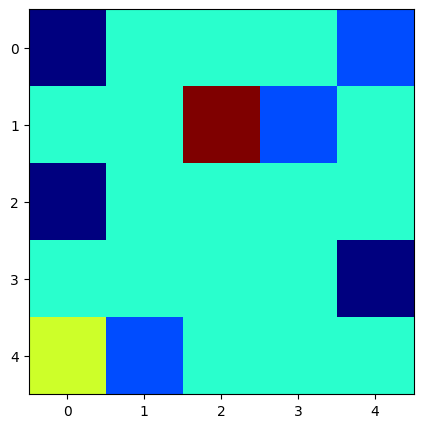

Agents' Status:
  Agent 1: Position (4, 1), Carrying: Yes
  Agent 2: Position (2, 0), Carrying: No
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


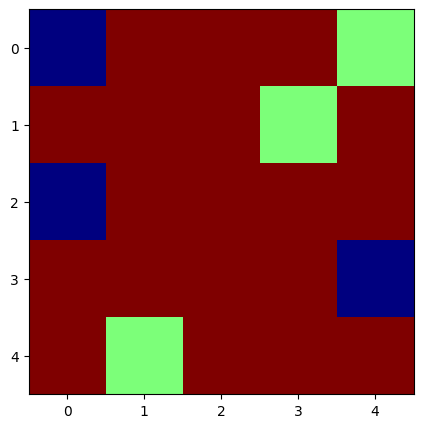

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (2, 1), Carrying: No
  Agent 3: Position (1, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


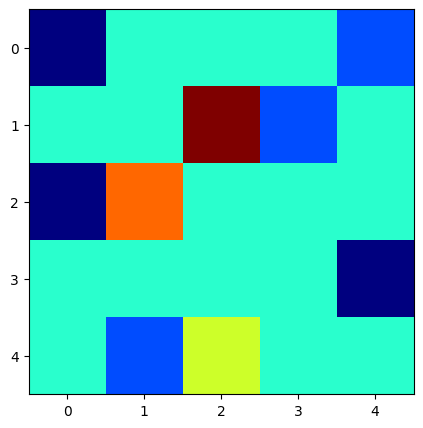

Agents' Status:
  Agent 1: Position (4, 3), Carrying: Yes
  Agent 2: Position (2, 0), Carrying: No
  Agent 3: Position (0, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


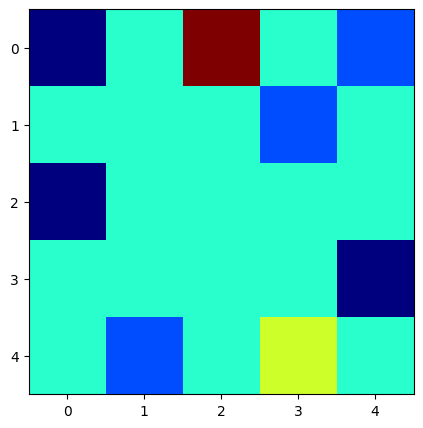

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (3, 0), Carrying: No
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


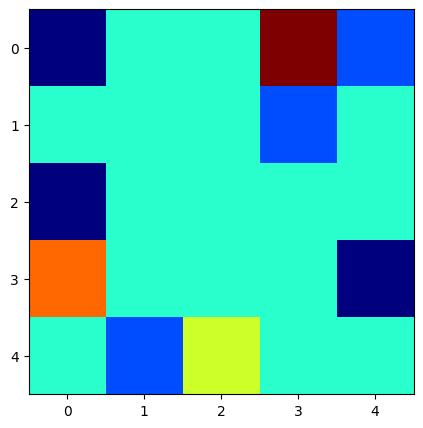

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (3, 1), Carrying: No
  Agent 3: Position (0, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


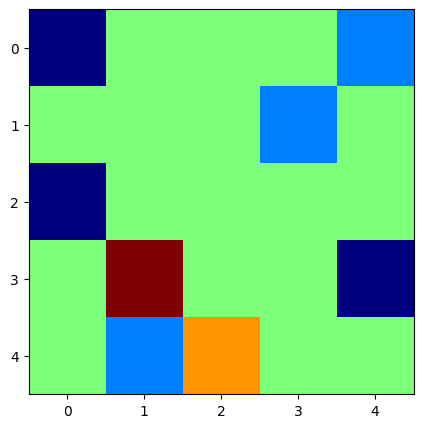

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (2, 1), Carrying: No
  Agent 3: Position (0, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


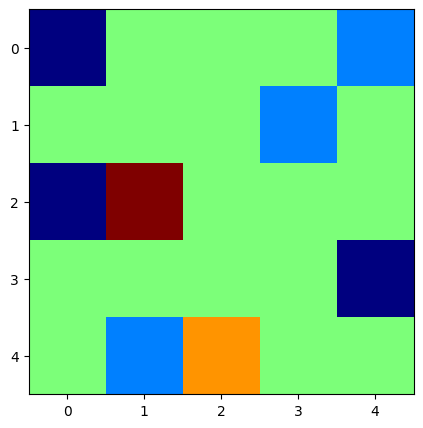

Agents' Status:
  Agent 1: Position (3, 2), Carrying: Yes
  Agent 2: Position (3, 1), Carrying: No
  Agent 3: Position (0, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


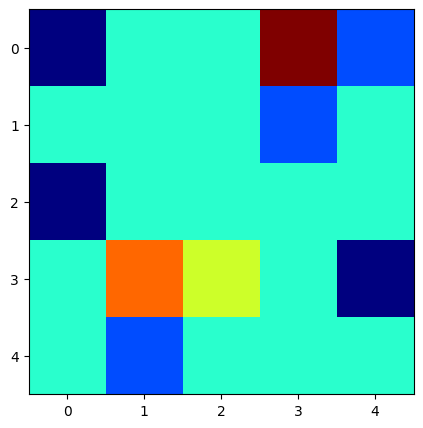

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (2, 1), Carrying: No
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


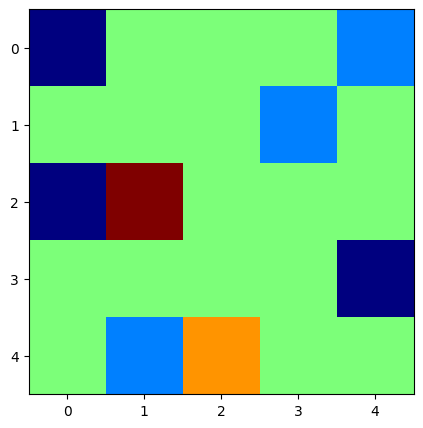

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (2, 2), Carrying: No
  Agent 3: Position (1, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


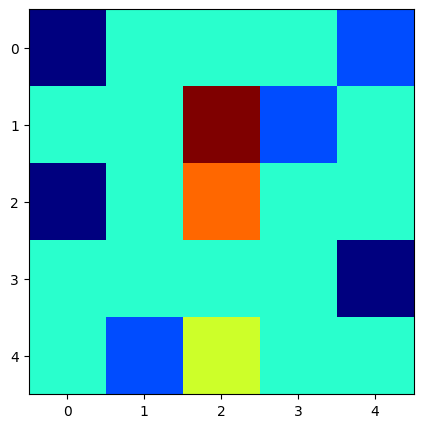

Agents' Status:
  Agent 1: Position (3, 2), Carrying: Yes
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (2, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


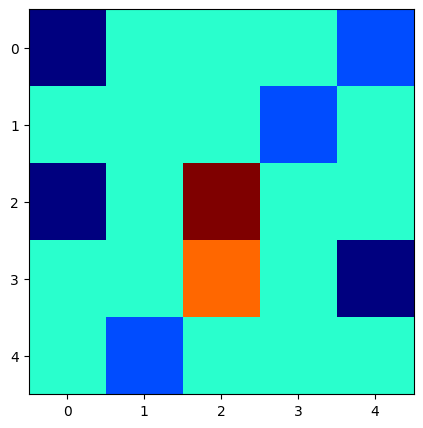

Agents' Status:
  Agent 1: Position (3, 3), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (3, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


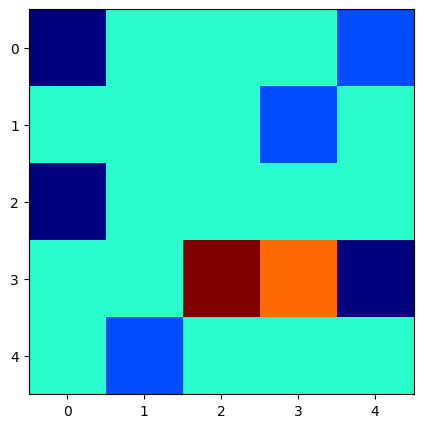

Agents' Status:
  Agent 1: Position (4, 3), Carrying: Yes
  Agent 2: Position (2, 3), Carrying: No
  Agent 3: Position (4, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


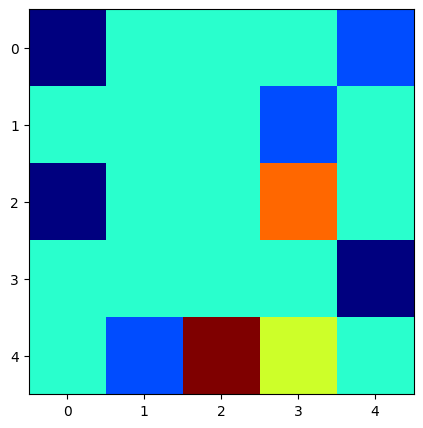

Agents' Status:
  Agent 1: Position (4, 3), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (4, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


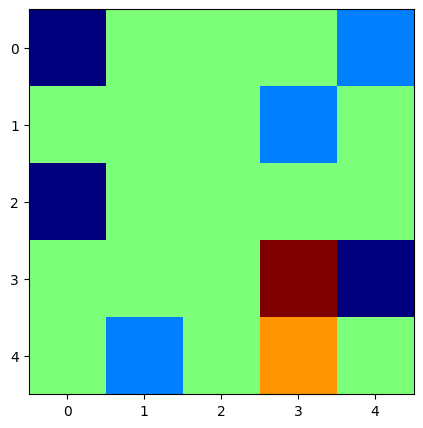

Agents' Status:
  Agent 1: Position (4, 3), Carrying: Yes
  Agent 2: Position (2, 3), Carrying: No
  Agent 3: Position (4, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


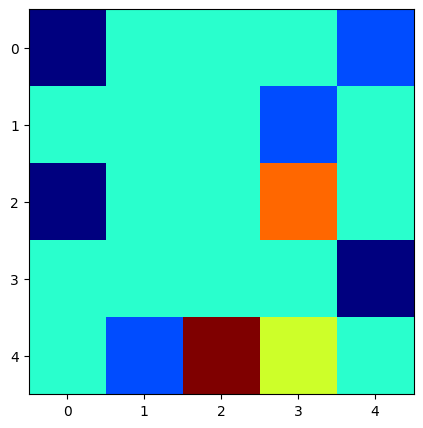

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (3, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


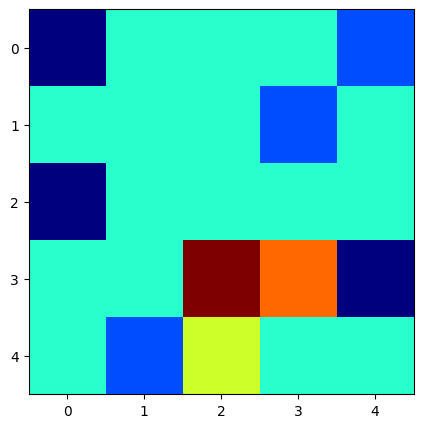

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (2, 3), Carrying: No
  Agent 3: Position (4, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


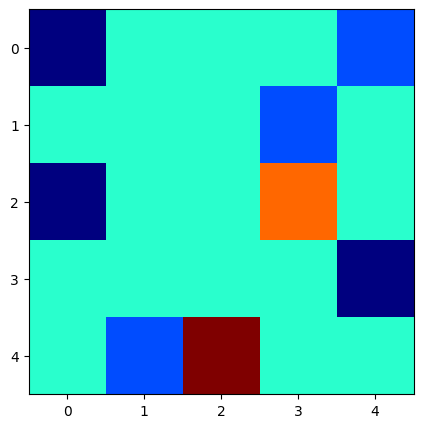

Agents' Status:
  Agent 1: Position (4, 2), Carrying: Yes
  Agent 2: Position (2, 4), Carrying: No
  Agent 3: Position (4, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


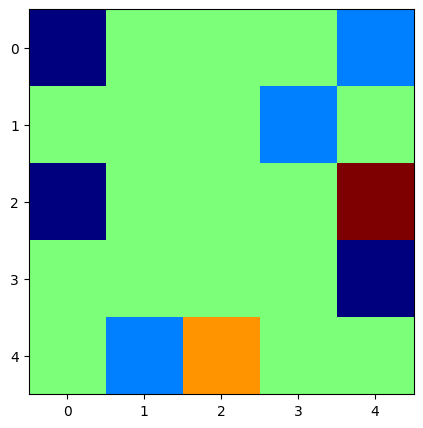

Agents' Status:
  Agent 1: Position (4, 3), Carrying: Yes
  Agent 2: Position (1, 4), Carrying: No
  Agent 3: Position (3, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


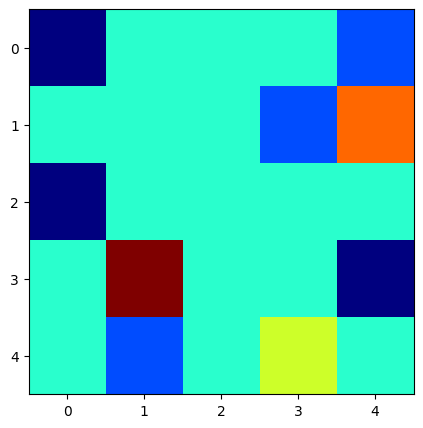

Agents' Status:
  Agent 1: Position (4, 3), Carrying: Yes
  Agent 2: Position (1, 3), Carrying: No
  Agent 3: Position (4, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


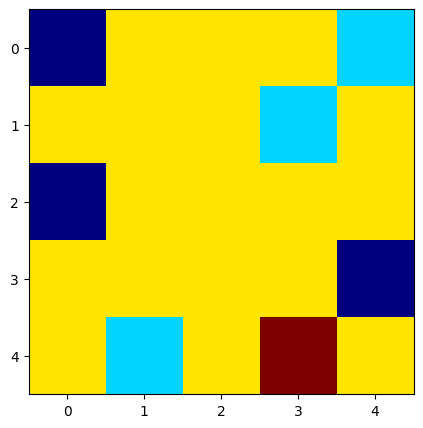

Agents' Status:
  Agent 1: Position (4, 3), Carrying: Yes
  Agent 2: Position (0, 3), Carrying: No
  Agent 3: Position (4, 0), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


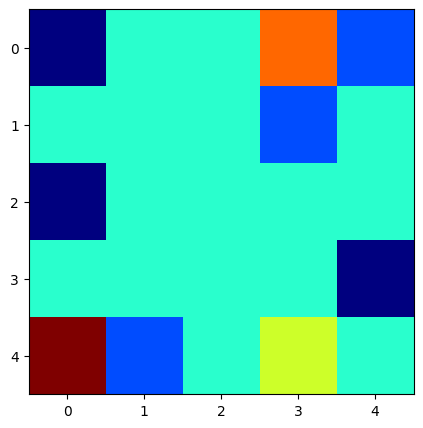

Agents' Status:
  Agent 1: Position (4, 4), Carrying: Yes
  Agent 2: Position (0, 2), Carrying: No
  Agent 3: Position (3, 0), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 2
  Location (3, 4): Blocks delivered 3
------------------------------


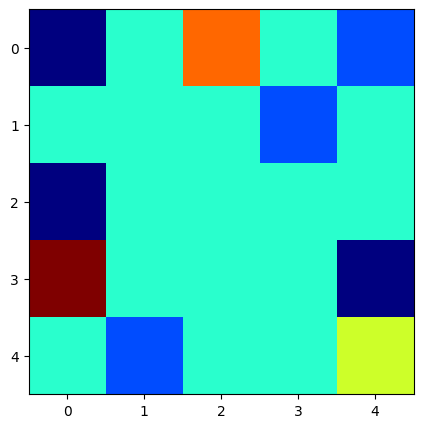

Agents' Status:
  Agent 1: Position (3, 4), Carrying: No
  Agent 2: Position (0, 3), Carrying: No
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 4
------------------------------


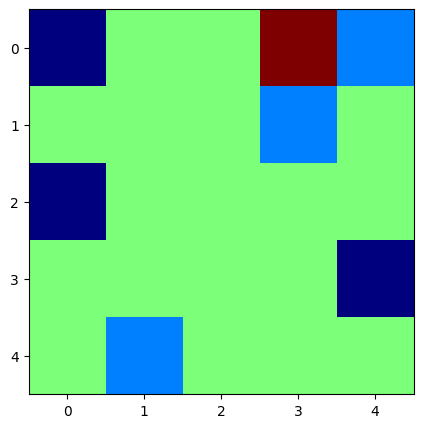

Agents' Status:
  Agent 1: Position (3, 3), Carrying: No
  Agent 2: Position (0, 3), Carrying: No
  Agent 3: Position (3, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 4
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 4
------------------------------


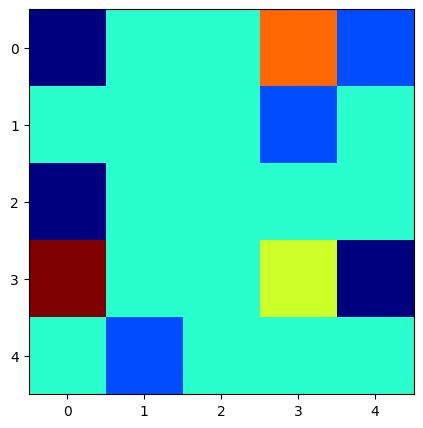

Agents' Status:
  Agent 1: Position (2, 3), Carrying: No
  Agent 2: Position (0, 4), Carrying: Yes
  Agent 3: Position (4, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 3
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 4
------------------------------


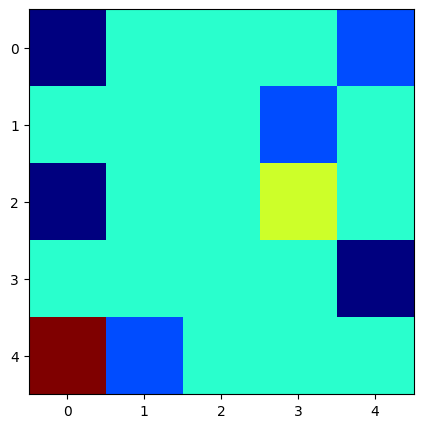

Agents' Status:
  Agent 1: Position (2, 4), Carrying: No
  Agent 2: Position (1, 4), Carrying: Yes
  Agent 3: Position (4, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 3
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 4
------------------------------


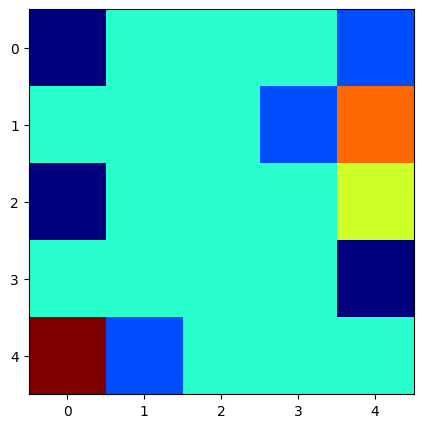

Agents' Status:
  Agent 1: Position (1, 4), Carrying: No
  Agent 2: Position (2, 4), Carrying: Yes
  Agent 3: Position (4, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 3
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 4
------------------------------


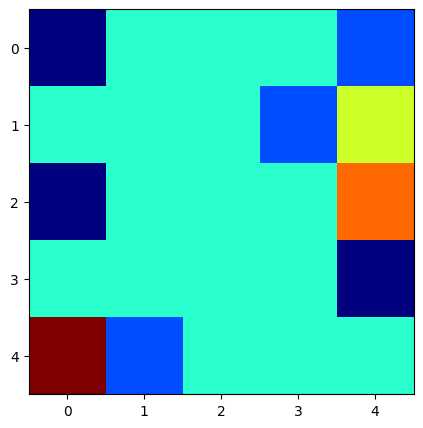

Agents' Status:
  Agent 1: Position (1, 4), Carrying: No
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (4, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 3
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


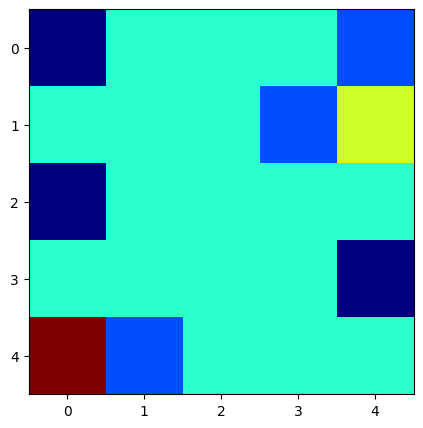

Agents' Status:
  Agent 1: Position (0, 4), Carrying: Yes
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (4, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


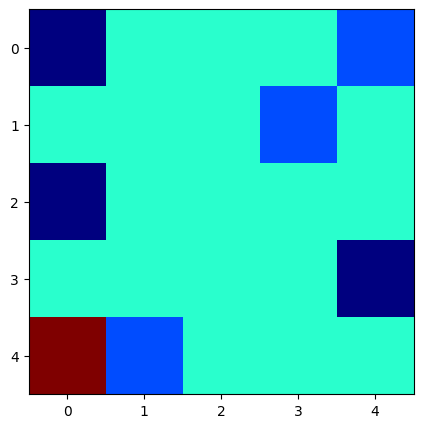

Agents' Status:
  Agent 1: Position (0, 3), Carrying: Yes
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (4, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


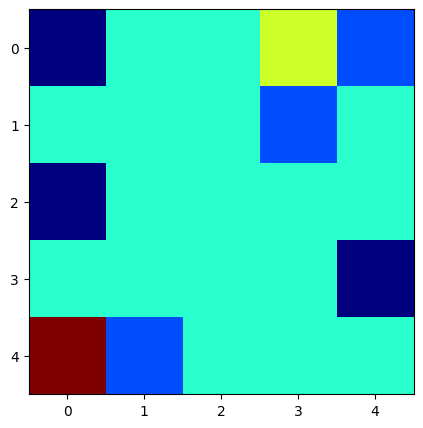

Agents' Status:
  Agent 1: Position (1, 3), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (3, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


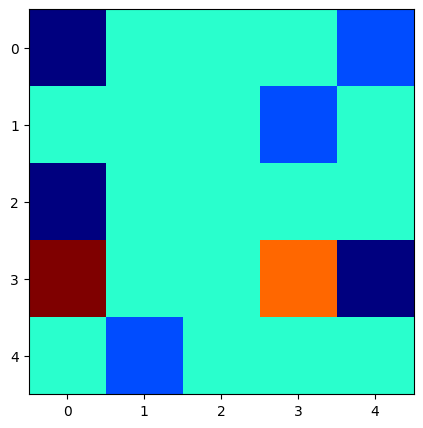

Agents' Status:
  Agent 1: Position (2, 3), Carrying: Yes
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (3, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


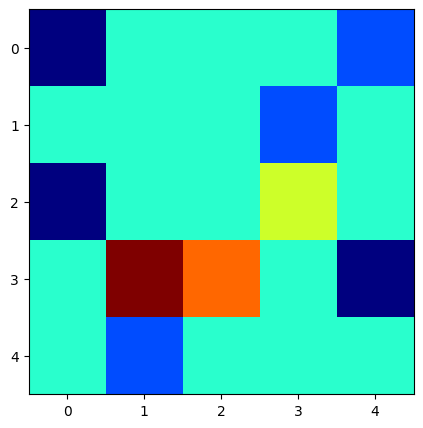

Agents' Status:
  Agent 1: Position (2, 4), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (2, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


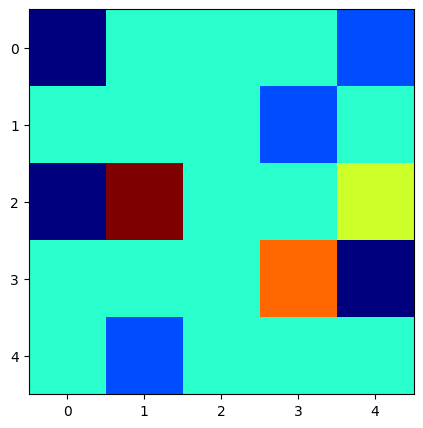

Agents' Status:
  Agent 1: Position (1, 4), Carrying: Yes
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


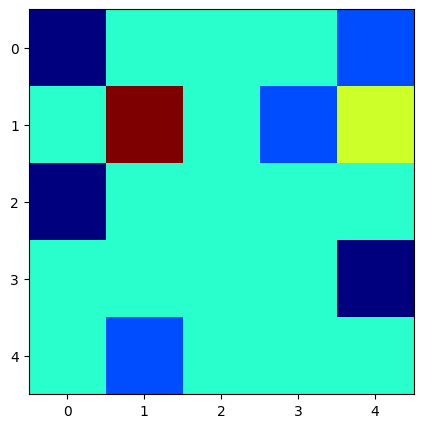

Agents' Status:
  Agent 1: Position (1, 4), Carrying: Yes
  Agent 2: Position (4, 4), Carrying: No
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


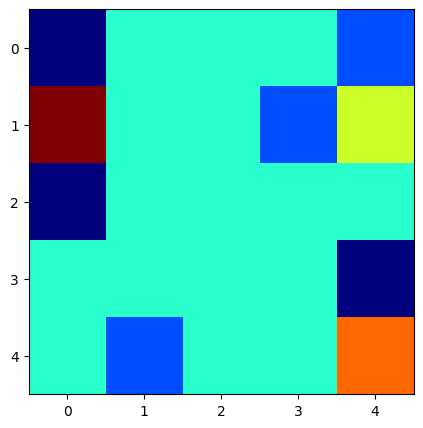

Agents' Status:
  Agent 1: Position (1, 4), Carrying: Yes
  Agent 2: Position (4, 4), Carrying: No
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


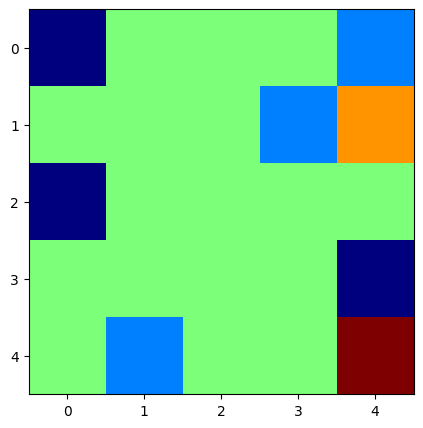

Agents' Status:
  Agent 1: Position (1, 4), Carrying: Yes
  Agent 2: Position (4, 4), Carrying: No
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


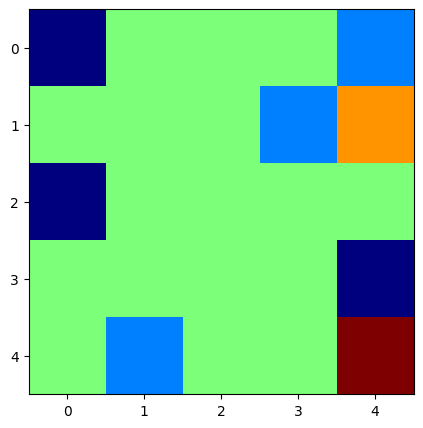

Agents' Status:
  Agent 1: Position (0, 4), Carrying: Yes
  Agent 2: Position (4, 4), Carrying: No
  Agent 3: Position (0, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


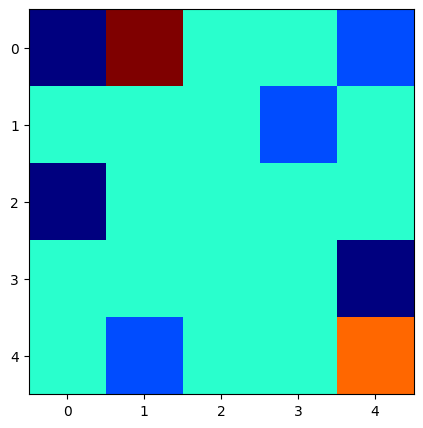

Agents' Status:
  Agent 1: Position (1, 4), Carrying: Yes
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (0, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


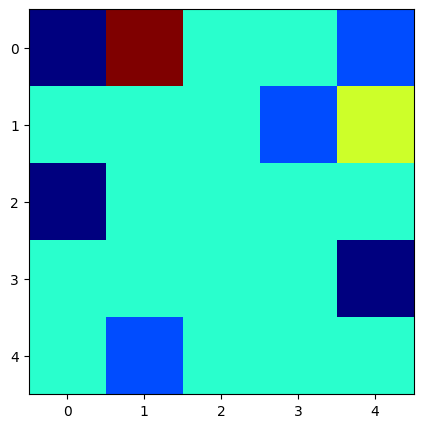

Agents' Status:
  Agent 1: Position (1, 3), Carrying: Yes
  Agent 2: Position (4, 4), Carrying: No
  Agent 3: Position (0, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


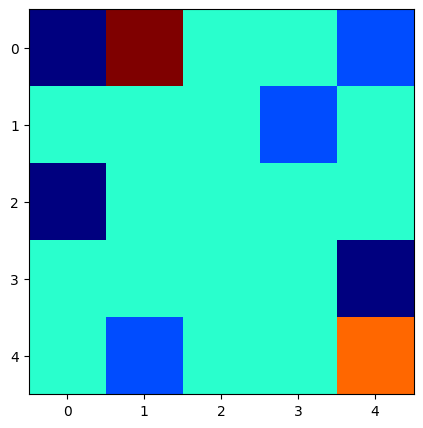

Agents' Status:
  Agent 1: Position (2, 3), Carrying: Yes
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


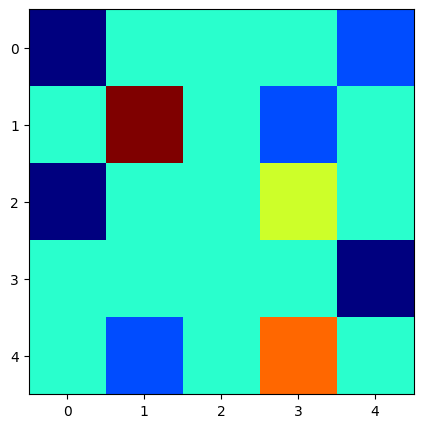

Agents' Status:
  Agent 1: Position (2, 2), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (1, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


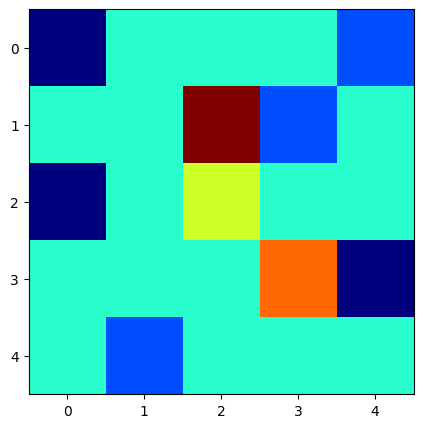

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (2, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


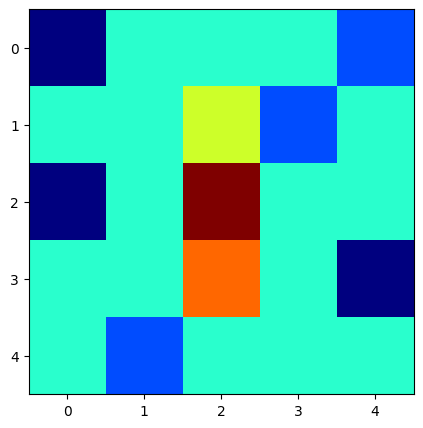

Agents' Status:
  Agent 1: Position (0, 2), Carrying: Yes
  Agent 2: Position (2, 2), Carrying: No
  Agent 3: Position (2, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


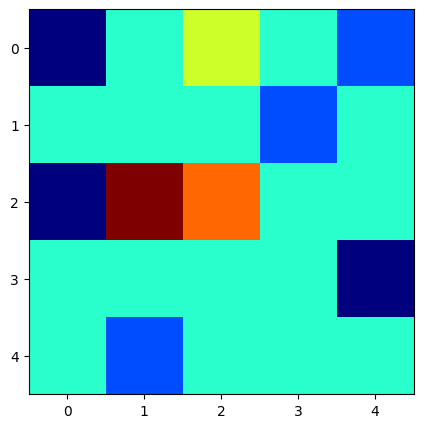

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


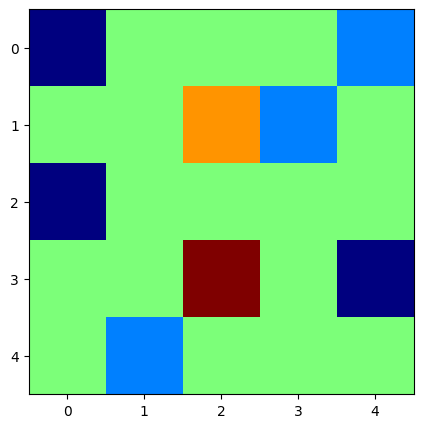

Agents' Status:
  Agent 1: Position (1, 1), Carrying: Yes
  Agent 2: Position (2, 2), Carrying: No
  Agent 3: Position (2, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


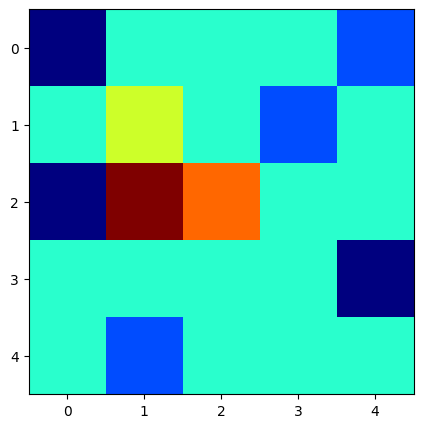

Agents' Status:
  Agent 1: Position (0, 1), Carrying: Yes
  Agent 2: Position (1, 2), Carrying: No
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


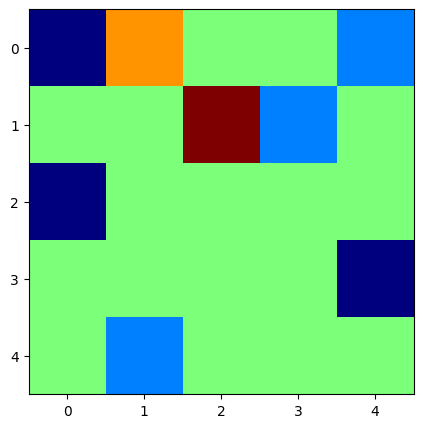

Agents' Status:
  Agent 1: Position (0, 2), Carrying: Yes
  Agent 2: Position (2, 2), Carrying: No
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


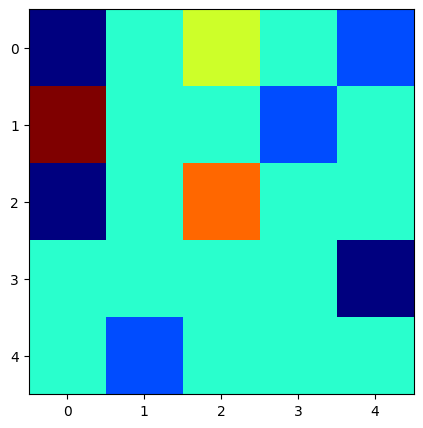

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (2, 1), Carrying: No
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


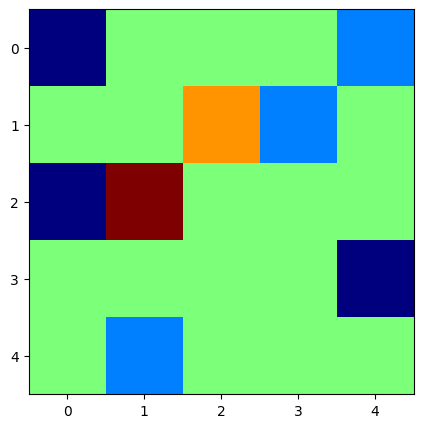

Agents' Status:
  Agent 1: Position (0, 2), Carrying: Yes
  Agent 2: Position (2, 2), Carrying: No
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


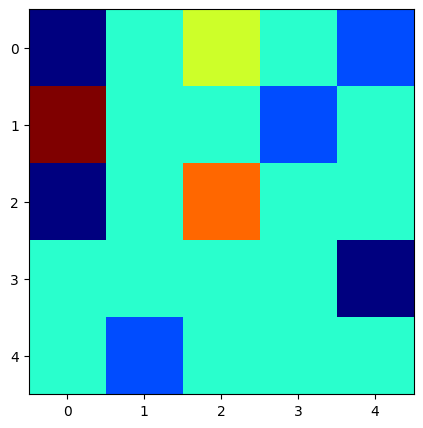

Agents' Status:
  Agent 1: Position (1, 2), Carrying: Yes
  Agent 2: Position (2, 3), Carrying: No
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


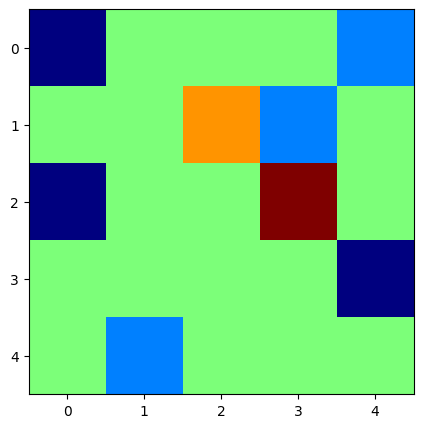

Agents' Status:
  Agent 1: Position (0, 2), Carrying: Yes
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


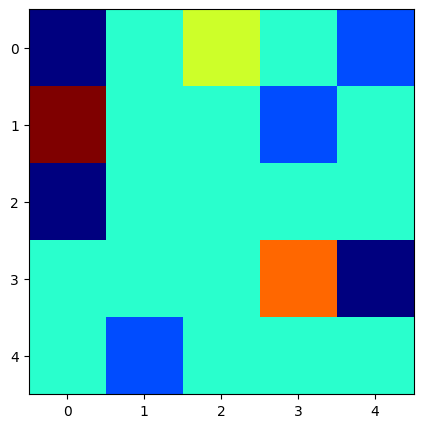

Agents' Status:
  Agent 1: Position (0, 1), Carrying: Yes
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 3
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


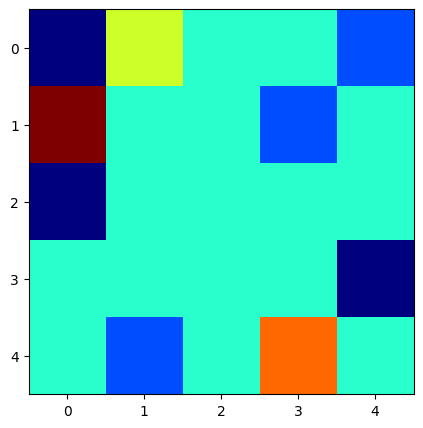

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


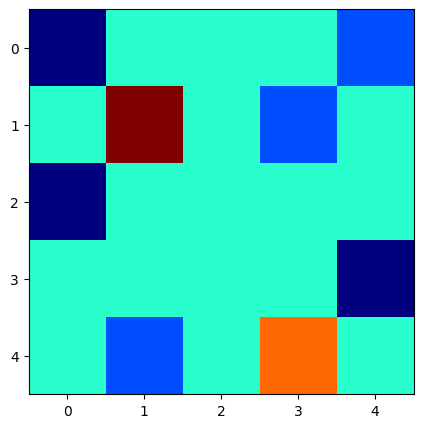

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (2, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


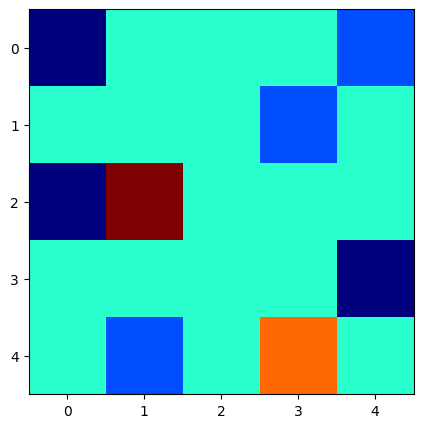

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (3, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 1

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


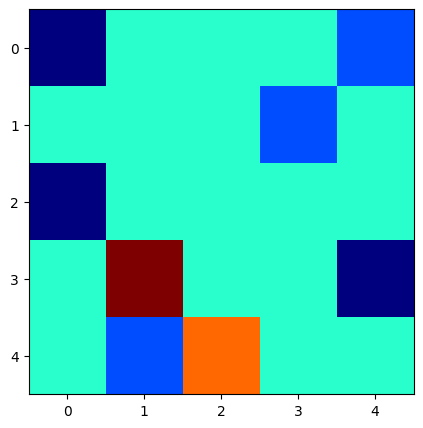

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (4, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


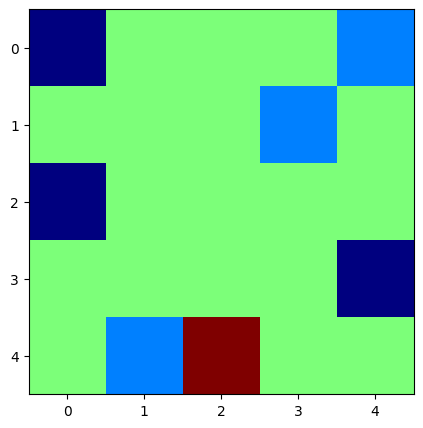

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (4, 1), Carrying: No
  Agent 3: Position (3, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


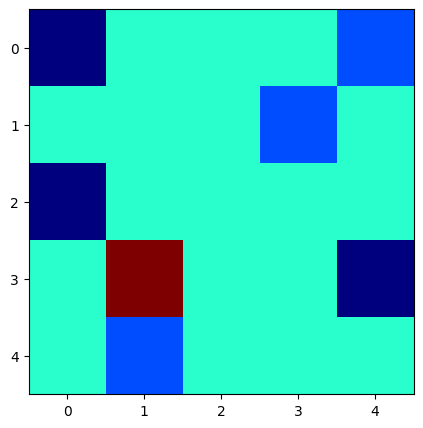

Agents' Status:
  Agent 1: Position (0, 1), Carrying: No
  Agent 2: Position (3, 1), Carrying: No
  Agent 3: Position (3, 0), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


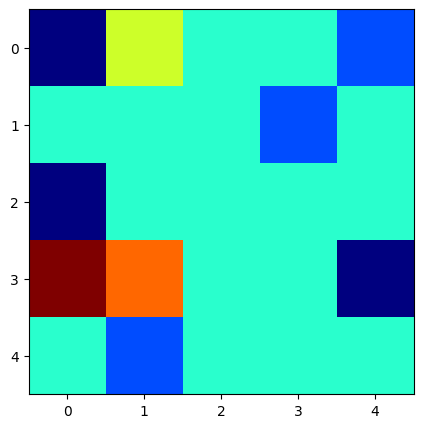

Agents' Status:
  Agent 1: Position (0, 1), Carrying: No
  Agent 2: Position (4, 1), Carrying: No
  Agent 3: Position (4, 0), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


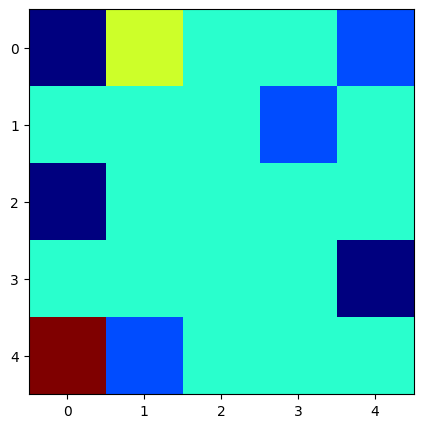

Agents' Status:
  Agent 1: Position (1, 1), Carrying: No
  Agent 2: Position (3, 1), Carrying: No
  Agent 3: Position (3, 0), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


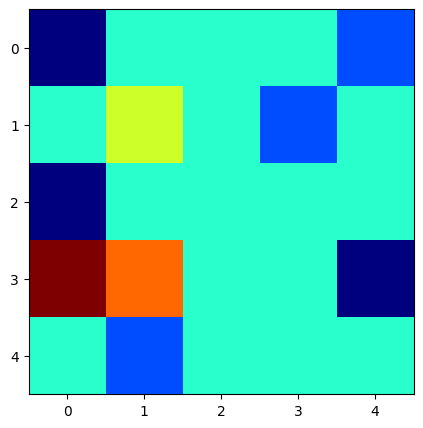

Agents' Status:
  Agent 1: Position (1, 2), Carrying: No
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (4, 0), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


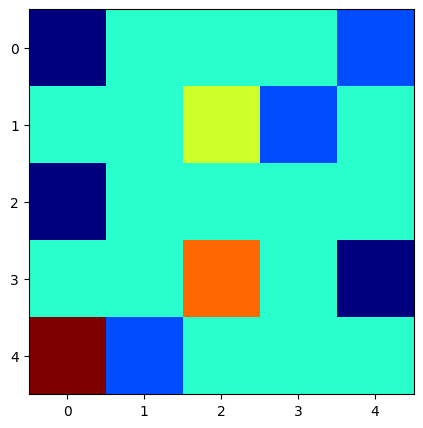

Agents' Status:
  Agent 1: Position (0, 2), Carrying: No
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (4, 0), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


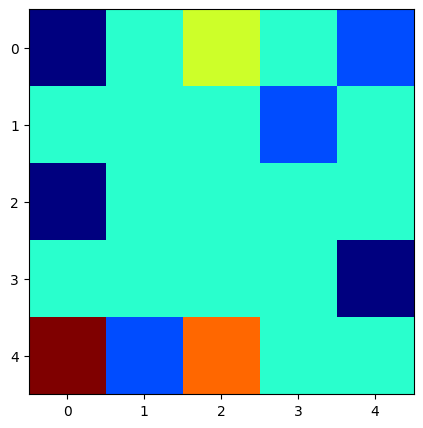

Agents' Status:
  Agent 1: Position (1, 2), Carrying: No
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (3, 0), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 3
  Location (3, 4): Blocks delivered 5
------------------------------


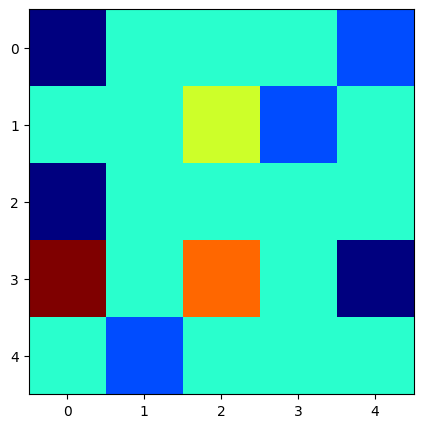

Agents' Status:
  Agent 1: Position (2, 2), Carrying: No
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


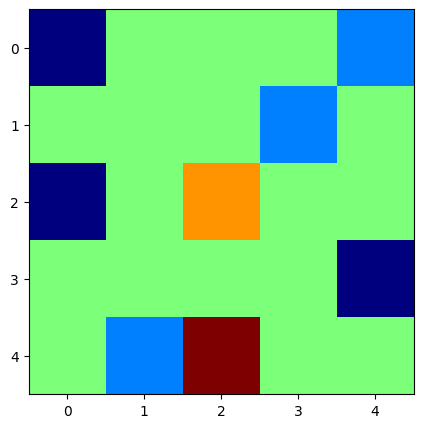

Agents' Status:
  Agent 1: Position (2, 1), Carrying: No
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (3, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


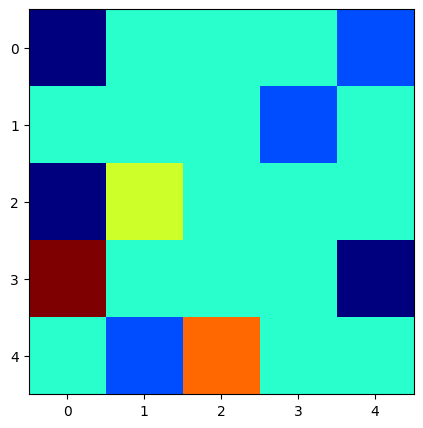

Agents' Status:
  Agent 1: Position (1, 1), Carrying: No
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (3, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


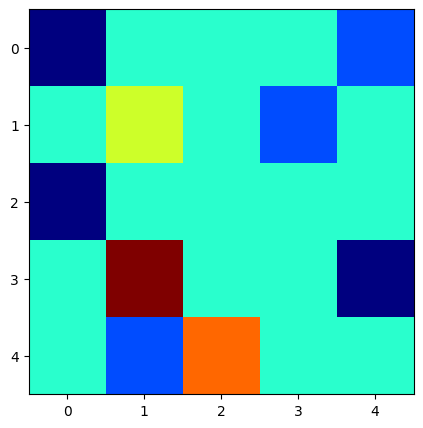

Agents' Status:
  Agent 1: Position (2, 1), Carrying: No
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (2, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


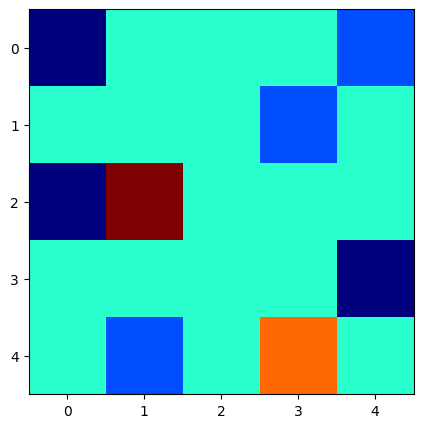

Agents' Status:
  Agent 1: Position (3, 1), Carrying: No
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


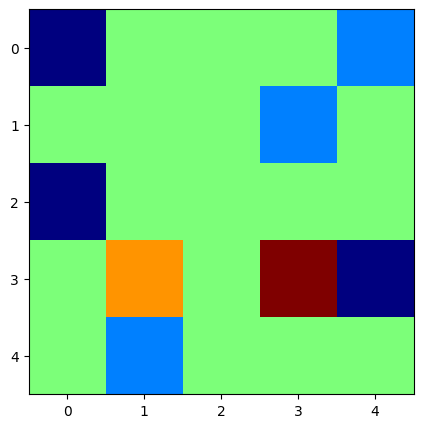

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


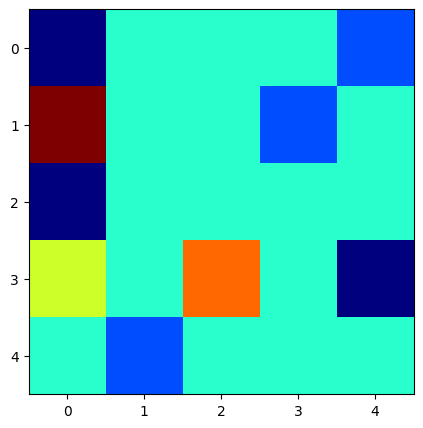

Agents' Status:
  Agent 1: Position (2, 0), Carrying: No
  Agent 2: Position (2, 2), Carrying: No
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


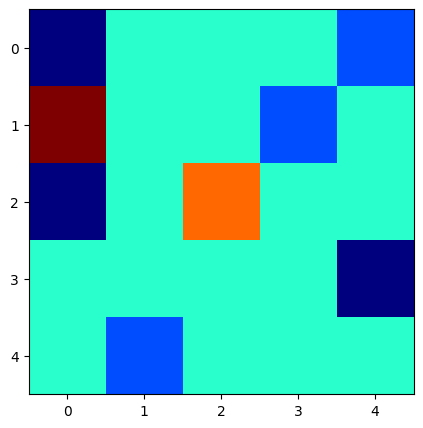

Agents' Status:
  Agent 1: Position (2, 0), Carrying: No
  Agent 2: Position (2, 3), Carrying: No
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


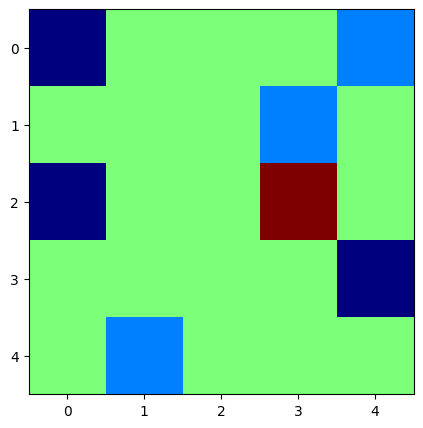

Agents' Status:
  Agent 1: Position (1, 0), Carrying: No
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


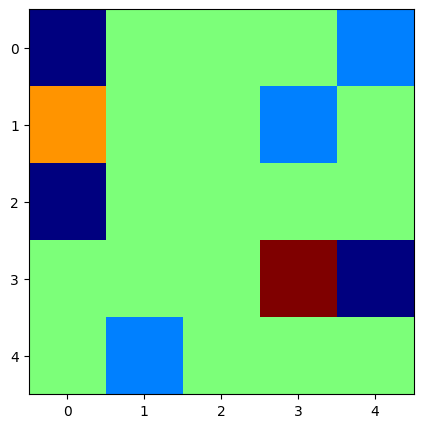

Agents' Status:
  Agent 1: Position (1, 1), Carrying: No
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (0, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


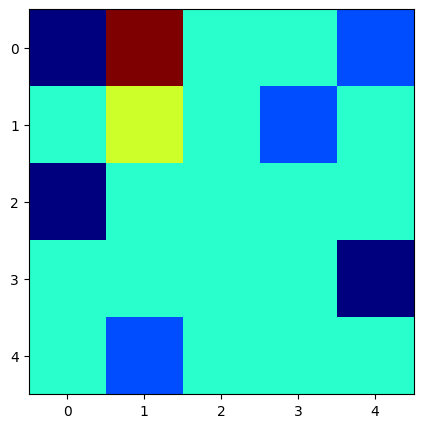

Agents' Status:
  Agent 1: Position (0, 1), Carrying: No
  Agent 2: Position (2, 4), Carrying: No
  Agent 3: Position (0, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


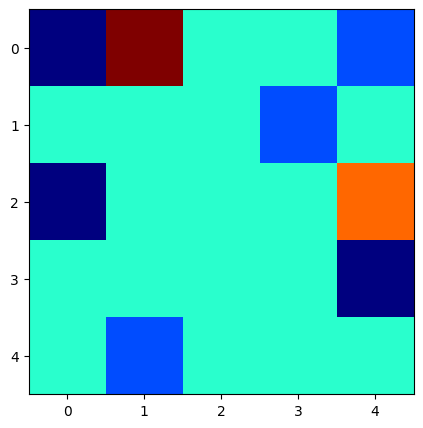

Agents' Status:
  Agent 1: Position (0, 0), Carrying: No
  Agent 2: Position (1, 4), Carrying: No
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


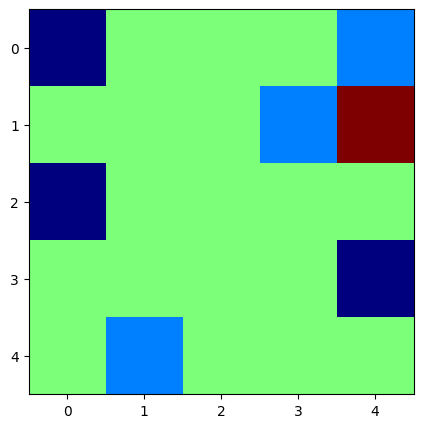

Agents' Status:
  Agent 1: Position (1, 0), Carrying: No
  Agent 2: Position (1, 3), Carrying: No
  Agent 3: Position (0, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


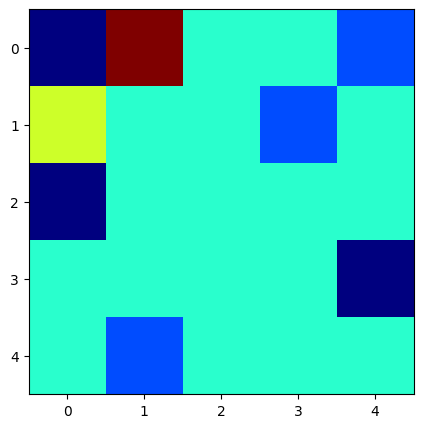

Agents' Status:
  Agent 1: Position (2, 0), Carrying: No
  Agent 2: Position (1, 2), Carrying: No
  Agent 3: Position (0, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


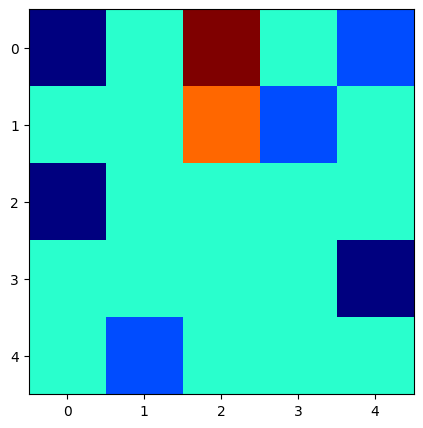

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (2, 2), Carrying: No
  Agent 3: Position (0, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 2
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


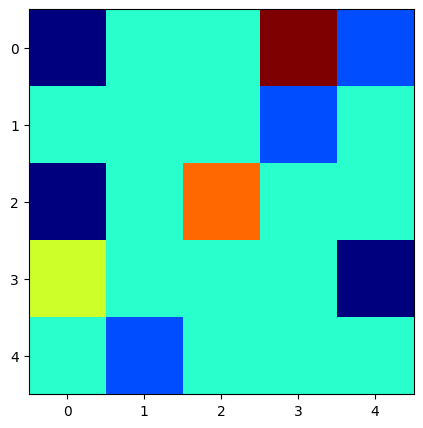

Agents' Status:
  Agent 1: Position (4, 0), Carrying: No
  Agent 2: Position (2, 3), Carrying: No
  Agent 3: Position (0, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


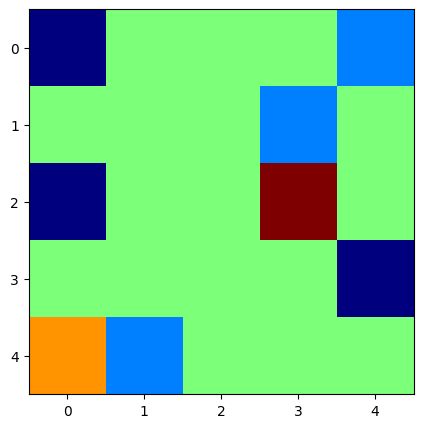

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (1, 3), Carrying: No
  Agent 3: Position (0, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


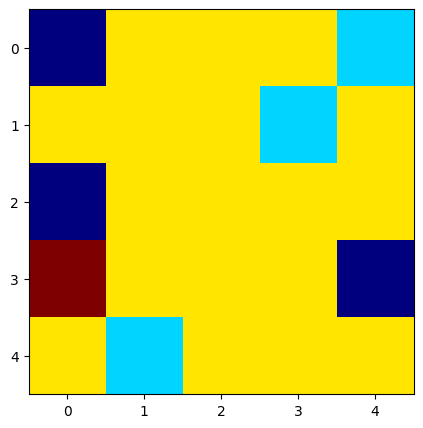

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (2, 3), Carrying: No
  Agent 3: Position (1, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


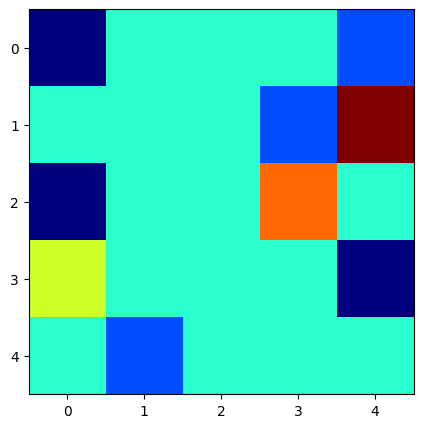

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (2, 4), Carrying: No
  Agent 3: Position (2, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


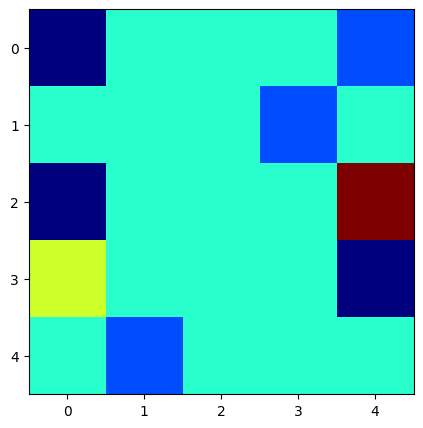

Agents' Status:
  Agent 1: Position (3, 1), Carrying: No
  Agent 2: Position (2, 4), Carrying: No
  Agent 3: Position (2, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


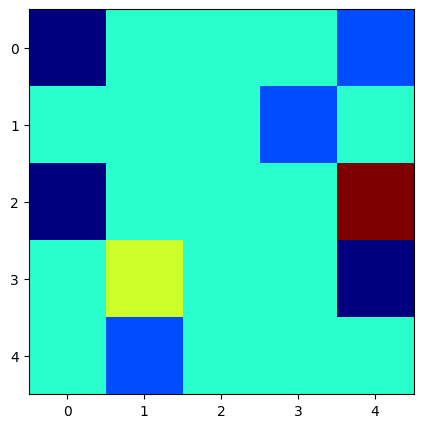

Agents' Status:
  Agent 1: Position (2, 1), Carrying: No
  Agent 2: Position (3, 4), Carrying: No
  Agent 3: Position (2, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


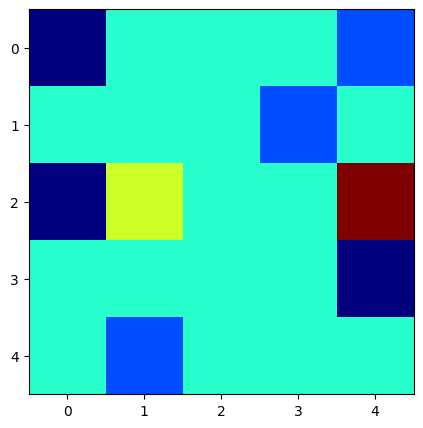

Agents' Status:
  Agent 1: Position (2, 0), Carrying: No
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (1, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


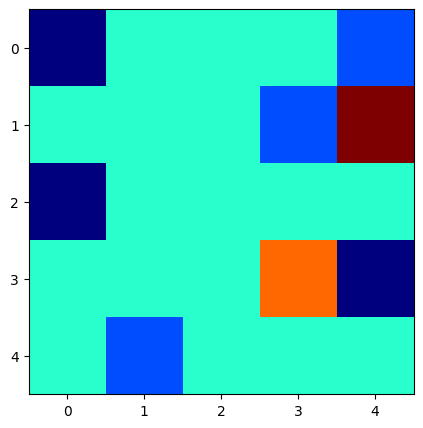

Agents' Status:
  Agent 1: Position (1, 0), Carrying: No
  Agent 2: Position (4, 3), Carrying: No
  Agent 3: Position (0, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


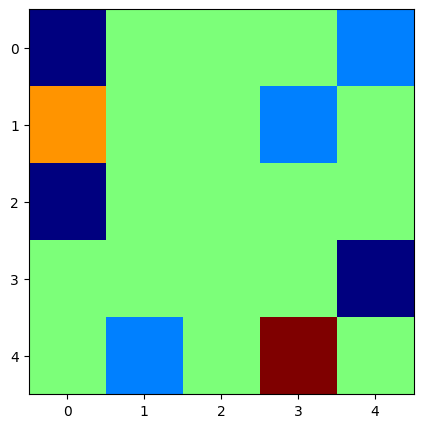

Agents' Status:
  Agent 1: Position (1, 0), Carrying: No
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (1, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


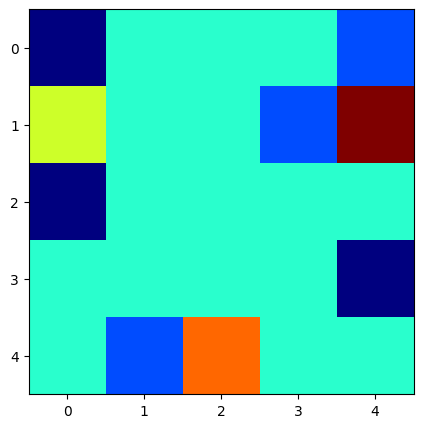

Agents' Status:
  Agent 1: Position (2, 0), Carrying: No
  Agent 2: Position (4, 2), Carrying: No
  Agent 3: Position (2, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


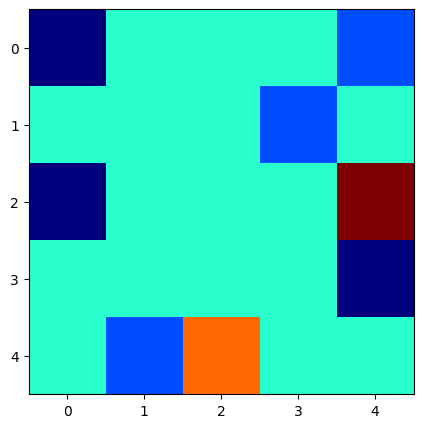

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (3, 2), Carrying: No
  Agent 3: Position (2, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


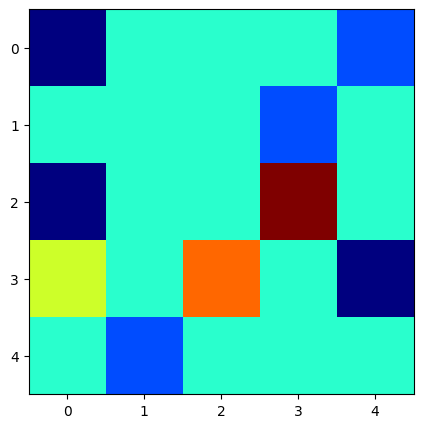

Agents' Status:
  Agent 1: Position (3, 1), Carrying: No
  Agent 2: Position (3, 3), Carrying: No
  Agent 3: Position (3, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


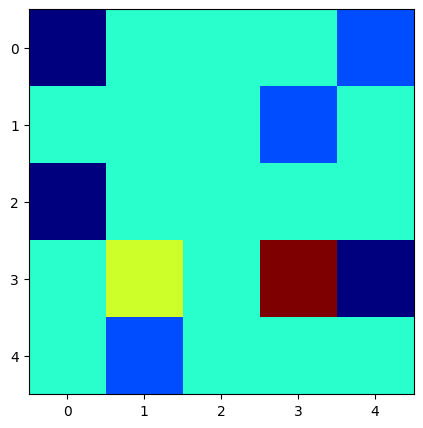

Agents' Status:
  Agent 1: Position (4, 1), Carrying: No
  Agent 2: Position (2, 3), Carrying: No
  Agent 3: Position (3, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


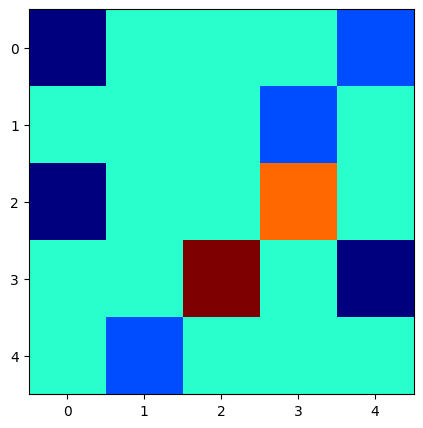

Agents' Status:
  Agent 1: Position (3, 1), Carrying: No
  Agent 2: Position (1, 3), Carrying: No
  Agent 3: Position (3, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


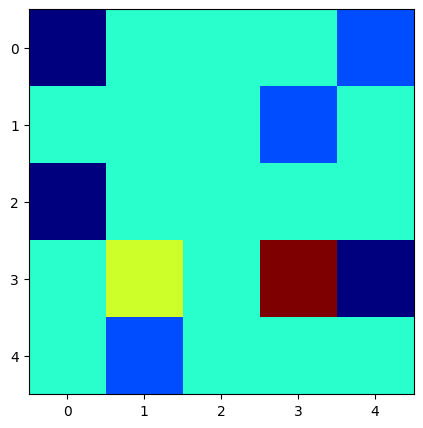

Agents' Status:
  Agent 1: Position (4, 1), Carrying: No
  Agent 2: Position (1, 4), Carrying: No
  Agent 3: Position (3, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 1
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


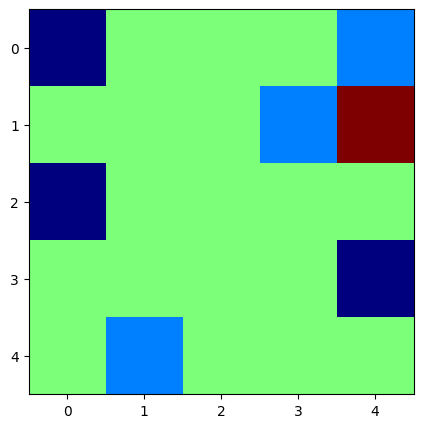

Agents' Status:
  Agent 1: Position (4, 0), Carrying: No
  Agent 2: Position (0, 4), Carrying: Yes
  Agent 3: Position (2, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


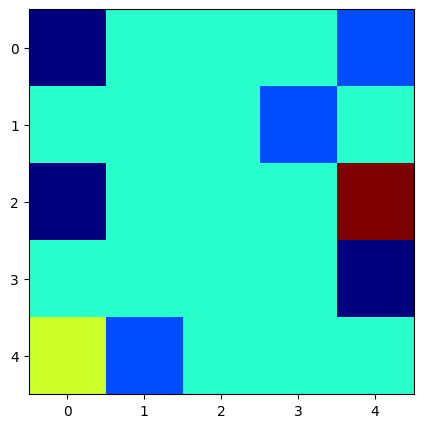

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (1, 4), Carrying: Yes
  Agent 3: Position (2, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


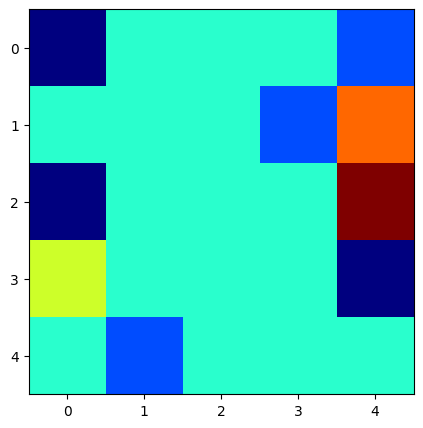

Agents' Status:
  Agent 1: Position (4, 0), Carrying: No
  Agent 2: Position (2, 4), Carrying: Yes
  Agent 3: Position (3, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


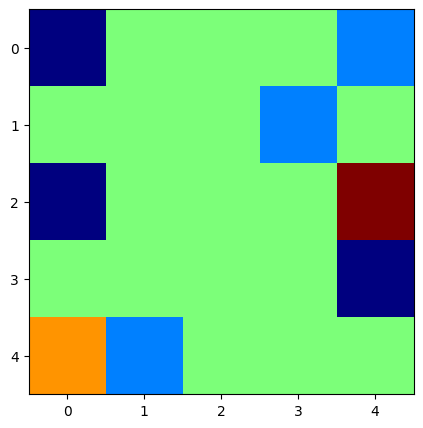

Agents' Status:
  Agent 1: Position (4, 1), Carrying: No
  Agent 2: Position (2, 4), Carrying: Yes
  Agent 3: Position (3, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


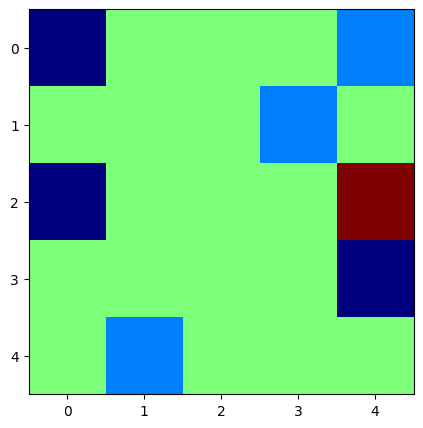

Agents' Status:
  Agent 1: Position (3, 1), Carrying: No
  Agent 2: Position (1, 4), Carrying: Yes
  Agent 3: Position (3, 4), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


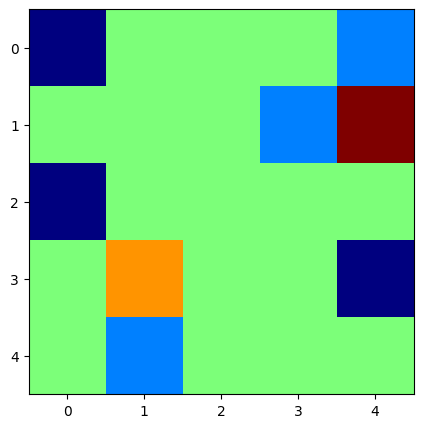

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (1, 3), Carrying: Yes
  Agent 3: Position (3, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


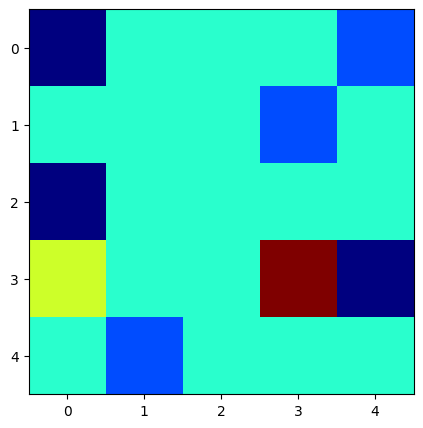

Agents' Status:
  Agent 1: Position (4, 0), Carrying: No
  Agent 2: Position (1, 2), Carrying: Yes
  Agent 3: Position (2, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


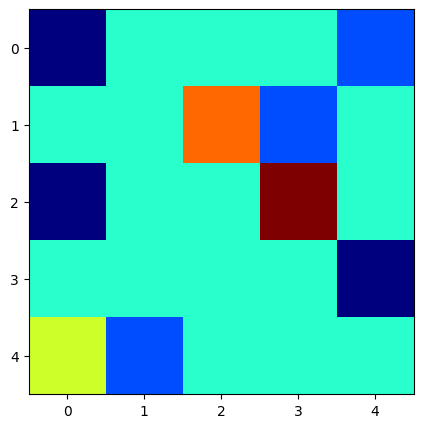

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (1, 1), Carrying: Yes
  Agent 3: Position (1, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


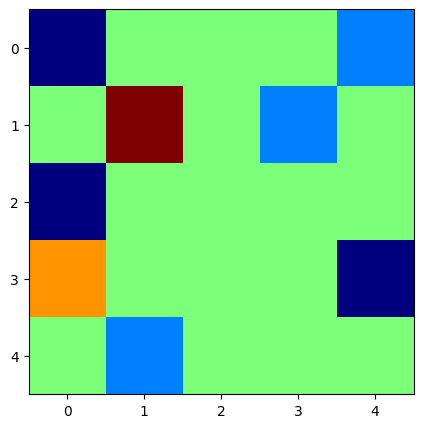

Agents' Status:
  Agent 1: Position (3, 1), Carrying: No
  Agent 2: Position (2, 1), Carrying: Yes
  Agent 3: Position (2, 3), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


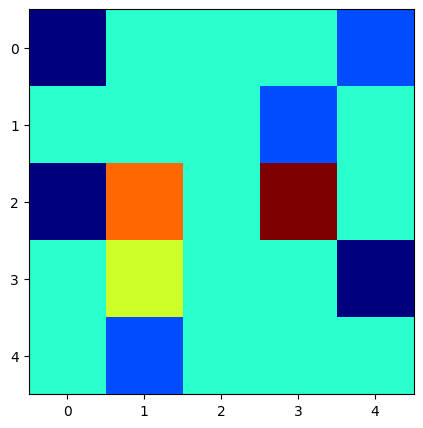

Agents' Status:
  Agent 1: Position (4, 1), Carrying: No
  Agent 2: Position (3, 1), Carrying: Yes
  Agent 3: Position (2, 2), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


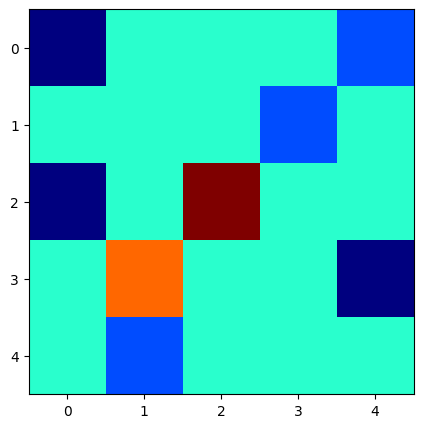

Agents' Status:
  Agent 1: Position (4, 0), Carrying: No
  Agent 2: Position (3, 0), Carrying: Yes
  Agent 3: Position (2, 1), Carrying: Yes

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 4
  Location (3, 4): Blocks delivered 5
------------------------------


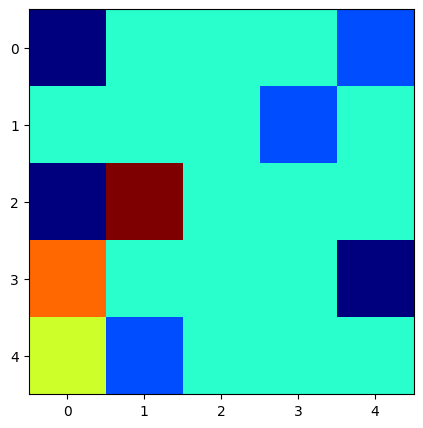

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (3, 1), Carrying: Yes
  Agent 3: Position (2, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


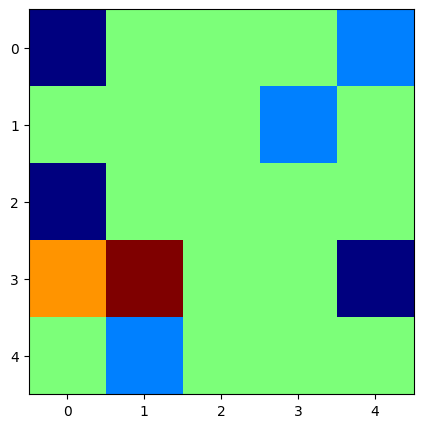

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (2, 1), Carrying: Yes
  Agent 3: Position (2, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


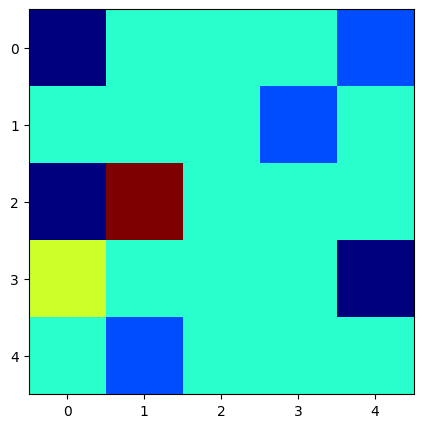

Agents' Status:
  Agent 1: Position (4, 0), Carrying: No
  Agent 2: Position (1, 1), Carrying: Yes
  Agent 3: Position (2, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


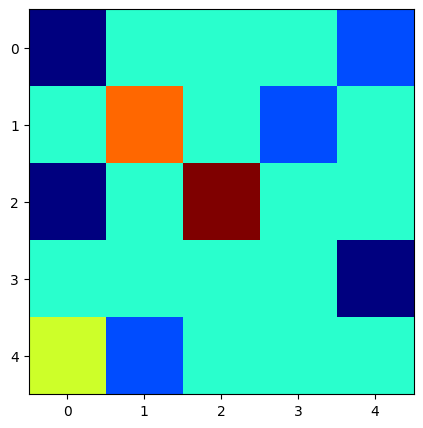

Agents' Status:
  Agent 1: Position (4, 0), Carrying: No
  Agent 2: Position (2, 1), Carrying: Yes
  Agent 3: Position (2, 3), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


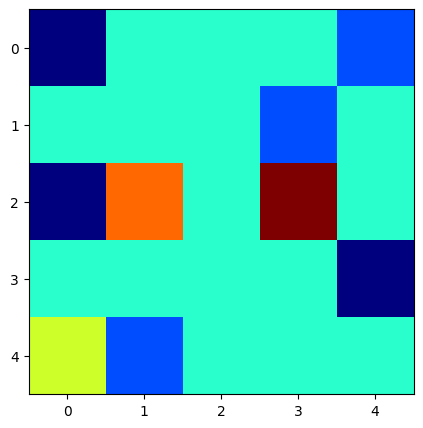

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (3, 1), Carrying: Yes
  Agent 3: Position (2, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


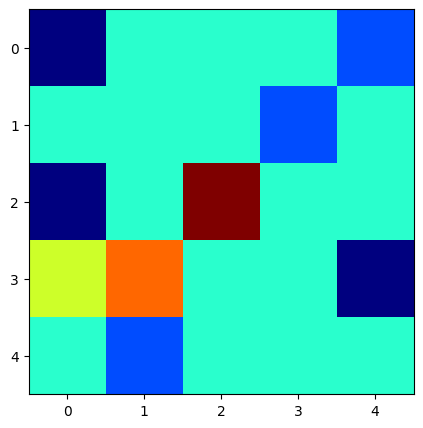

Agents' Status:
  Agent 1: Position (4, 0), Carrying: No
  Agent 2: Position (2, 1), Carrying: Yes
  Agent 3: Position (1, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


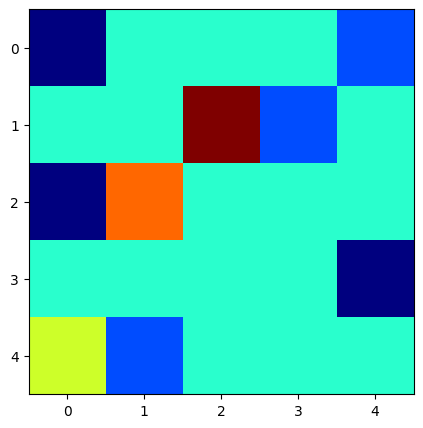

Agents' Status:
  Agent 1: Position (4, 0), Carrying: No
  Agent 2: Position (3, 1), Carrying: Yes
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


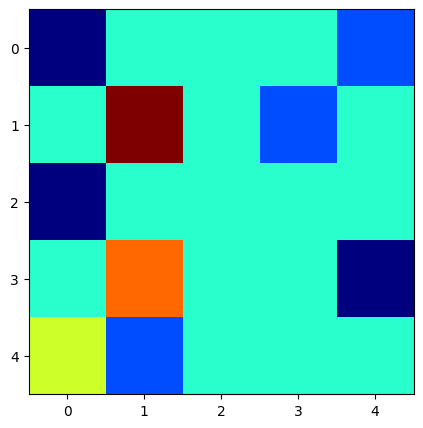

Agents' Status:
  Agent 1: Position (3, 0), Carrying: No
  Agent 2: Position (2, 1), Carrying: Yes
  Agent 3: Position (0, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


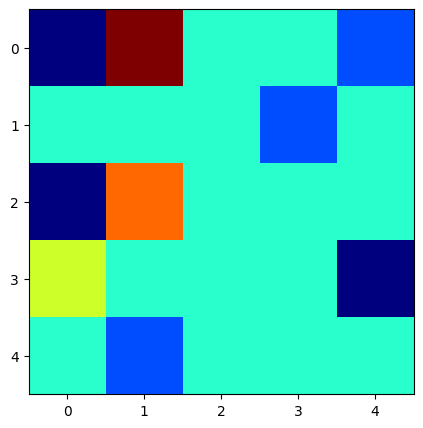

Agents' Status:
  Agent 1: Position (3, 1), Carrying: No
  Agent 2: Position (2, 0), Carrying: Yes
  Agent 3: Position (0, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


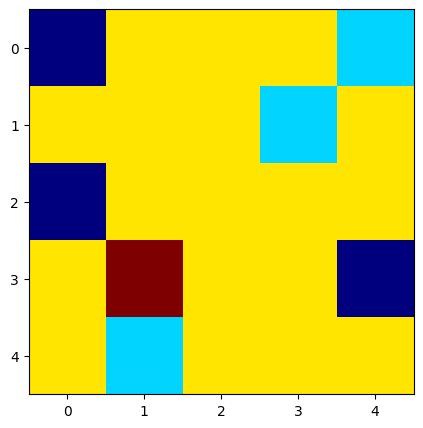

Agents' Status:
  Agent 1: Position (4, 1), Carrying: No
  Agent 2: Position (2, 0), Carrying: Yes
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


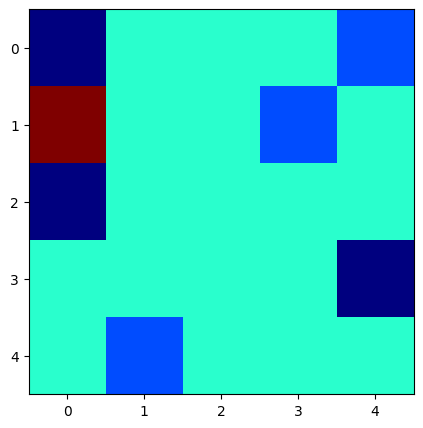

Agents' Status:
  Agent 1: Position (4, 0), Carrying: No
  Agent 2: Position (3, 0), Carrying: Yes
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


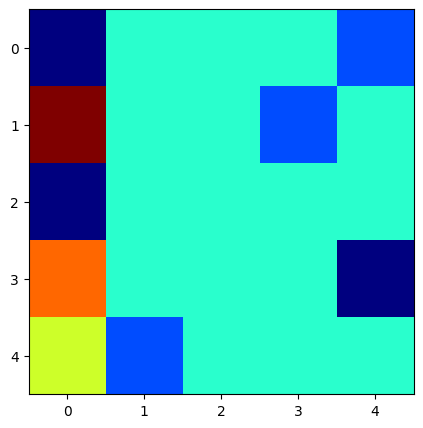

Agents' Status:
  Agent 1: Position (4, 0), Carrying: No
  Agent 2: Position (4, 0), Carrying: Yes
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


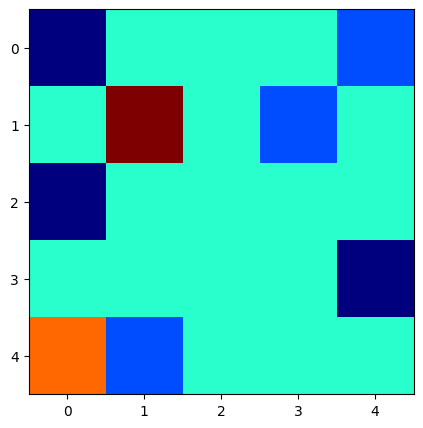

Agents' Status:
  Agent 1: Position (4, 1), Carrying: No
  Agent 2: Position (3, 0), Carrying: Yes
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


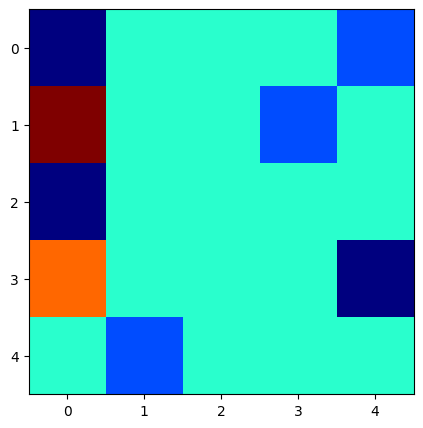

Agents' Status:
  Agent 1: Position (3, 1), Carrying: No
  Agent 2: Position (3, 0), Carrying: Yes
  Agent 3: Position (1, 0), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


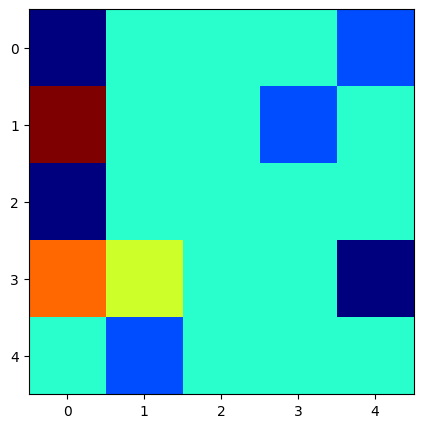

Agents' Status:
  Agent 1: Position (2, 1), Carrying: No
  Agent 2: Position (2, 0), Carrying: Yes
  Agent 3: Position (1, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


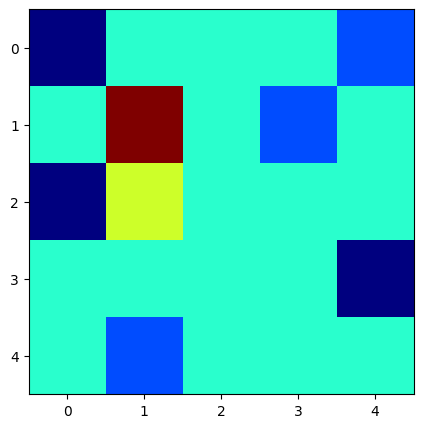

Agents' Status:
  Agent 1: Position (2, 2), Carrying: No
  Agent 2: Position (2, 1), Carrying: Yes
  Agent 3: Position (2, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


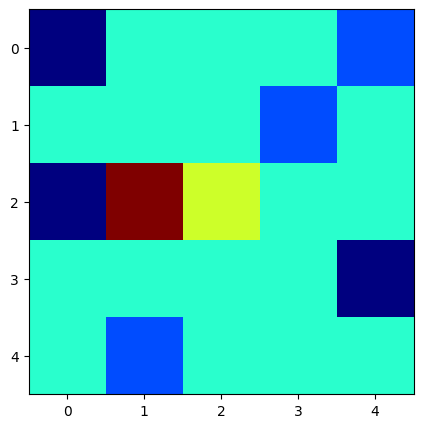

Agents' Status:
  Agent 1: Position (2, 1), Carrying: No
  Agent 2: Position (1, 1), Carrying: Yes
  Agent 3: Position (3, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


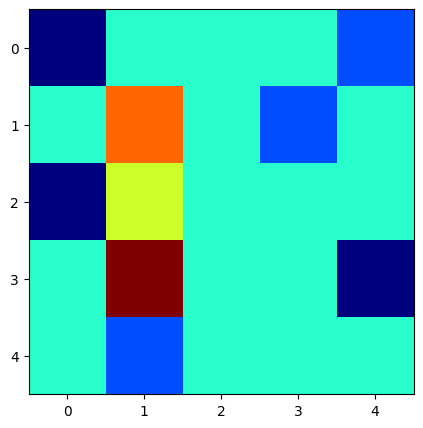

Agents' Status:
  Agent 1: Position (1, 1), Carrying: No
  Agent 2: Position (1, 0), Carrying: Yes
  Agent 3: Position (3, 2), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 4
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------


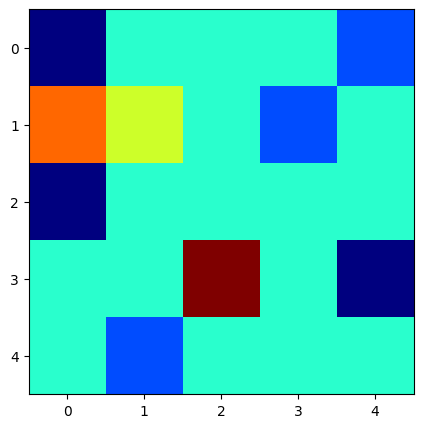

Agents' Status:
  Agent 1: Position (1, 2), Carrying: No
  Agent 2: Position (0, 0), Carrying: No
  Agent 3: Position (3, 1), Carrying: No

Pickups' Status:
  Location (0, 4): Blocks remaining 0
  Location (1, 3): Blocks remaining 0
  Location (4, 1): Blocks remaining 0

Dropoffs' Status:
  Location (0, 0): Blocks delivered 5
  Location (2, 0): Blocks delivered 5
  Location (3, 4): Blocks delivered 5
------------------------------
Task Completed: All dropoff locations have 5 blocks each.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Grid dimensions
GRID_SIZE = 5

# Agent state initialization (x, y, carrying)
agent_states = [(2, 2, False), (4, 2, False), (0, 2, False)]

# Pickups and dropoffs
pickups = {(0, 4): 5, (1, 3): 5, (4, 1): 5}
dropoffs = {(0, 0): 0, (2, 0): 0, (3, 4): 0}

# Define actions (moving 1 cell North, South, East, or West)
actions = {'N': (-1, 0), 'S': (1, 0), 'E': (0, 1), 'W': (0, -1)}

def is_valid_position(position):
    x, y = position
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE

def move_agent(agent_state, action):
    x, y, carrying = agent_state
    move_x, move_y = actions[action]
    new_position = (x + move_x, y + move_y)
    if is_valid_position(new_position):
        return (new_position[0], new_position[1], carrying)
    else:
        return agent_state  # Return the original state if the move is invalid

def update_pickup_dropoff(agent_state):
    x, y, carrying = agent_state
    # Check if we're at a pickup location and not carrying anything
    if (x, y) in pickups and pickups[(x, y)] > 0 and not carrying:
        pickups[(x, y)] -= 1
        carrying = True
    # Check if we're at a dropoff location and carrying something
    elif (x, y) in dropoffs and carrying:
        if dropoffs[(x, y)] < 5:
            dropoffs[(x, y)] += 1
            carrying = False
    return (x, y, carrying)

def all_pickups_delivered():
    return all(value == 5 for value in dropoffs.values())

# Visualization function
def plot_grid(agent_states):
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    plt.figure(figsize=(5, 5))
    for idx, state in enumerate(agent_states):
        x, y, _ = state
        grid[x, y] = idx + 1  # Different integer for each agent
    for pickup in pickups:
        x, y = pickup
        grid[x, y] = -1  # Negative value for pickup locations
    for dropoff in dropoffs:
        x, y = dropoff
        grid[x, y] = -2  # Another negative value for dropoff locations
    plt.imshow(grid, cmap='jet')
    plt.show()

# Function to print the current status
def print_status(agent_states, pickups, dropoffs):
    print("Agents' Status:")
    for i, (x, y, carrying) in enumerate(agent_states, start=1):
        print(f"  Agent {i}: Position ({x}, {y}), Carrying: {'Yes' if carrying else 'No'}")
    print("\nPickups' Status:")
    for location, count in pickups.items():
        print(f"  Location {location}: Blocks remaining {count}")
    print("\nDropoffs' Status:")
    for location, count in dropoffs.items():
        print(f"  Location {location}: Blocks delivered {count}")
    print('-' * 30)

# Simulation loop
def simulate_agents():
    while not all_pickups_delivered():
        plot_grid(agent_states)  # Visualize the grid and agents
        for i, agent_state in enumerate(agent_states):
            action = np.random.choice(list(actions.keys()))  # Random action
            new_agent_state = move_agent(agent_state, action)  # Move agent
            new_agent_state = update_pickup_dropoff(new_agent_state)  # Try to pick up or drop off
            agent_states[i] = new_agent_state

        print_status(agent_states, pickups, dropoffs)  # Print the status after each move

        # Check if the task is completed
        if all_pickups_delivered():
            print("Task Completed: All dropoff locations have 5 blocks each.")
            break

        plt.pause(1)  # Pause to slow down the simulation loop for visualization

simulate_agents()
